# Introduction

Since the beginning of 2010s, with increasing availability of computing resources and advances in computer vision applications, the Deep Learning has become a primary choice of ML engineers for addressing different classes of supervised learning problems, including time series forecasting. This has become even more evident after the exploding progress in training and using Large Language Models, which rely to sequential data.

However, not only that use of Deep Learning implies significant computational cost and lack of explainability as two well known drawbacks, there are too many cases in which its use in time series forecasting problems will not even lead to the best performance. There are three main arguments for that statement.

First, many time series forecasting problems assume single step forecast which often does not require insights into longer lookback periods. Single-step forecasting refers to predicting only the next value in the time series, given the past observations. In contrast, sequence forecasting (or multi-step forecasting) involves predicting a sequence of future values in the time series. Sequence forecasting facilitates extended foresight: it provides predictions for a longer horizon, which can be more useful for more strategic planning and decision-making. When compared with single-step forecasting, it exhibits error accumulation, where errors from earlier predictions are propagated and amplified in subsequent steps.

Second, in spite of the strong academic bias towards Deep Learning methods, statistical methods and to some extent, ML models are visibly more successful in time series forecasting being it a single-step or sequence forecasting. Success of more simplistic methods has been convincingly proven in M competitions organized for more than 40 years (Makridakis et al, 1982) aiming to identify ways to improve the accuracy of forecasting. M5 competition was the first where all of the top-performing methods were either 'pure' ML approaches or their combinations, with only occasional competitive DL approaches. LightGBM (Ke et al, 2017), a decision tree-based ML approach has shown superior forecasting performance compared with all other alternatives. However, it was also found that simple and computationally cheap methods such as exponential smoothing were still competitive.

Third, there are time series forecasting problems which can be interpreted as conventional ones, due to a strong and certain short-term seasonality leading to approaches in using individual seasons' features rather than the features at each time point. This is exactly the case with hourly forecasting of the heat demand.

In a District Heating System (DHS), heat transfer occurs via fluid flow through primary and secondary circuits, connected by a heat exchanger. The system starts at a central heating plant, where hot water or steam is produced to serve as the heat medium. This high-temperature fluid then transports heat from the plant to different locations, specifically to substations, through what is known as the primary supply line. At each substation, the heat from the primary system's high-temperature fluid is transferred to a separate, secondary system through a heat exchanger. The secondary system operates in a closed loop, meaning it circulates fluid to and from the individual consumer's heating systems without mixing with the fluid in the primary system. Once the fluid in the secondary system has delivered its heat, its temperature drops. This cooler fluid then returns to the substation via the secondary return line, where it is reheated by the heat exchanger using energy from the central plant's fluid. The effectiveness of this heat transfer is monitored using a calorimeter located in the primary return line, which measures the heat energy based on the temperature differences and flow rate in the secondary lines.

District Heating System is operated at two levels. At the plant level, control is manual and it involves turning the heating on and off. At the substation level, control is automatic and it is commonly implemented by so called control curve, setting up the target dependency between the ambient temperature, as measured by the sensor which is integral part of DHS and connected to SCADA system and heating fluid temperature at the supply line of the secondary flow. Inefficiencies causing the suboptimal thermal comfort level, excess gas consumption and consequent CO2 emissions at the plan level are rooted in both of the above levels of control. Manual control decisions depend on the plant operator's experience and daily heating strategies considering weather forecasts. Automatic control is dependent on only one variable, namely the ambient temperature measured at the current timepoint.

Heat demand forecasting is a popular tool for reducing uncertainty, leading to more appropriate manual decisions, as well as more balanced delivery to heat energy at the substations level. Forecast driven control strategies are widely discussed in scientific literature (Zdravković et al, 2022) and they will not be further elaborated in this paper. Heat demand forecasting problem is addressed by using a wide range of approaches, from statistical methods such as ARIMA or Exponential Smoothing, overuse of traditional Machine Learning algorithms, to very complex, novel Deep Learning approaches.

In this paper, we use the real case of small District Heating System, with data from 5 substations to demonstrate that recent excess use of Deep Learning algorithms for heat demand forecasting, introducing extremely high computational overload and reducing the explainability cannot be justified from the accuracy point of view. Thus, our hypothesis is that traditional ML models are better or competitive alternatives to modern DL approaches in the domain of heat demand forecasting. In section 2 of this paper, we introduced some results of a background research which clearly show the bias of academic community towards modern DL methods, but also introduce some best practices in general time series forecasting as identified by one of the largest engineers' community in series of so-called M competitions (Makridakis, 2022). In section 3, methodology for the experiment aiming at proving the above hypothesis is described and results and discussion are following in Section 4. Finally, in section 5, we introduce some of the future work in advancing performance of heat demand forecasting approach by solely relying on computationally efficient statistical and ML algorithms.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from scipy.stats import zscore

from IPython.display import Image, display, HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [2]:
#Configuration parameters
github_folder = 'https://github.com/xai4heat/xai4heat/raw/main/datasets/'
files = ['xai4heat_scada_L4.csv',
         'xai4heat_scada_L8.csv',
         'xai4heat_scada_L12.csv',
         'xai4heat_scada_L17.csv',
         'xai4heat_scada_L22.csv']

substations=['L4','L8','L12','L17','L22']
weather_file='weather/ni_20_rs.csv'

# Background research

The aim of the background research was twofold. Our first objective was to determine the trend of using different algorithms in addressing heat demand forecasting problem, as reported in the scientific literature. The second objective was to highlight the best engineering practices in time series forecasting. In the latter case, we are going to consider the findings from so-called M competitions, widely accepted reference in the world of time series forecasting.

## Heat demand forecasting algorithms

The literature review has considered the most cited journal papers published in last 5 years (since 2019) addressing the problem of heat demand forecasting on hourly and daily scale. The objective was to investigate the academic trend of using different types of time series forecasting methods and models, clearly distinguishing between traditional Machine Learning and Deep Learning approaches. Traditional statistics-based models like ARIMA or Exponential Smoothing have not been found among the selected papers.

It was found that the use of Deep Learning approach is overwhelming. Traditional ML methods, mostly ensembles based on the decision trees, like Gradient Boosting Machine (Gong et al, 2020) and improved XGBoost (Runge and Saloux, 2023)(Wei et al, 2021) are used in a few cases.

Deep Learning was found as the heat demand forecasting method of first choice. The choice of approaches starts at multi-layer Artificial Neural Networks (ANN) (Kurek et al, 2021)(Bünning et al, 2020). Long-Short Term Memory (LSTM) networks in its original (Runge and Saloux, 2023)(Zdravković et al, 2022)(Wei et al, 2021) or other forms, such as bidirectional LSTMs (Cui, 2022) or those combined with convolutional layers for temporal pattern recognition CNN-LSTM (Song et al, 2021)(Chung et al, 2022)(Yao et al, 2022)(Zdravković et al, 2022) are obviously considered as the most performant approach. In CNN-LSTM topology, 1D convolutional layers are used to extract local patterns and features like trends, seasonality, and local variations in the time series data. The LSTM layers are then used to capture the temporal dependencies and sequential patterns in the data. Since recently, novel time series forecasting approaches are being used for heat demand forecasting, such as Informer (Zhou et al, 2020) model (Gong et al, 2022)(Zhang et al, 2024) and even various forms of Graph Neural Network (GNN) architectures (Huang et al, 2023)(Wang et al, 2023). GNNs are an advanced type of ANN designed to work directly with graph structures. When it comes to time series forecasting, GNNs can be used to model complex dependencies between different time series that are related or influence each other.

Besides LSTMs which are the most commonly used algorithm among DL methods in time series forecasting, there are also many novel approaches in DL arena which have not been used in addressing the heat demand forecasting problem, to the best of our knowledge. Some of those algorithms are DeepAR (Salinas et al, 2020), Neural Basis Expansion Analysis (N-BEATS) (Oreshkin et al, 2020), Neural Hierarchical Interpolation for Time Series (NHITS) (Chalu et al, 2022), Neural basis expansion analysis with exogenous variables (N-BEATSx) (Olivares et al, 2023), Temporal Fusion Transformer (TFT) (Lim et al, 2021), Autoformer (Wu et al, 2021), PatchTST (Nie et al, 2022), TimesNet (Wu et al, 2022), Hierarchical Mixture Networks (HINT) (Olivares et al, 2023) and Spectral Temporal Graph Neural Network (StemGNN) (Cao et al, 2021). The above methods are designed for different classes of time series forecasting problems, such as single-step and sequence forecasting, for univariate and/or multivariate datasets. Their explanation is beyond the scope of research presented in this paper.

## Key findings from M competitions

The competitions have introduced several best practices and principles, such as merits of simplicity (statistical methods have dominated the competitions for years), ensembling, cross-learning approaches that allow models to learn from multiple series how to accurately predict individual ones (Semenoglou et al, 2021), and others. The last, M5 competition with case of retail sales forecasting has confirmed and further extend those principles (Makridakis et al, 2022).

The last competition has also introduced a novelty in metrics used. Time series forecasting problems are normally addressed by using simplistic metrics such as RMSE or MAE. However, there is a wide agreement that those metrics do not convincingly expose many important statistical properties. Instead, scaled errors, such as Root Mean Squared Scaled Error (RMSSE) (Hyndman et al, 2006) are considered to be more appropriate. Also, scaled error metrics enable effective comparison between models trained on datasets with different scales.

It became evident that performance can be significantly improved by using the combination of different forecasting models (Petropoulos and Svetunkov, 2020) trained on different datasets, different algorithms, or even same algorithms with different sets of hyperparameters, where the adopted predicted values are equally weighted combination of values predicted by the individual models. Such an approach has been widely used in M5 competition with great success (Makridakis et al, 2022).

Another approach that became a good practice is the use of cross-learning. One model is characterized as CL model when it is trained using data from multiple series without focusing only on the observations originating from the particular series it is going to predict (Semenoglou et al, 2021).

There are also other findings, which are not elaborated in detail here as they refer to the common best practices in time series forecasting, such as the value of exogenous features, exploration of the most beneficial cross-validation approaches, and others.

It is very important to highlight that all of the M competitions were organized on the specific datasets, where none of those datasets were related to heat demand. So, while they are strong and convincing evidence-based testimonials on the effectiveness of state of the art time series forecasting approaches, they should be considered with care.

# Methodology

In this research, we will be using the data from the small District Heating System managed by the Faculty of Mechanical Engineering (FMEDH). FMEDH has 12 consumers (and respective heating substations) of different demands, namely secondary education, higher-education and research organizations, student dormitory, restaurant and a residential block and total of nearly 120.000m2 heating area. Natural gas is used as primary fuel. Find below simplified  scheme of the system with 5 selected substations used in data acquisition process.

The experiment aims at testing the accuracy of heat demand forecasting approaches with two decision tree gradient boosting ensembles (XGBoost and Light GBM) and stacked LSTM (Long Short-Term Memory) configuration. For all tested approaches, data is pre-processed by using the same principles.

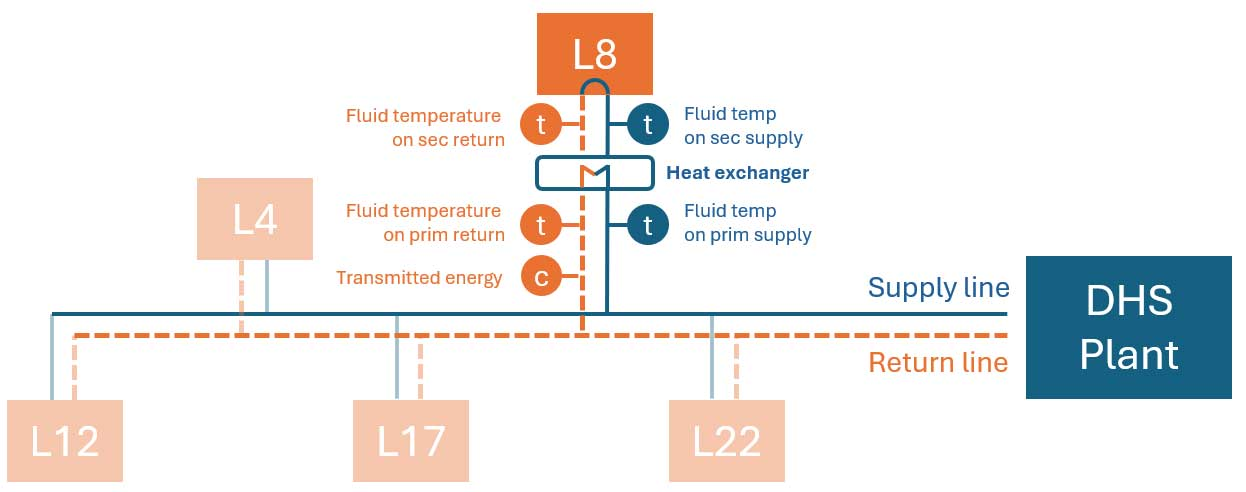

Fig. 1 Simplified scheme of FMEDH, considering only substations with data used in this research

The datasets include following relevant features:

- Outside air temperature, acquired by the sensor at the substation level (C, t_amb). This measures the ambient air temperature outside the substation. It's important for the DHS because the demand for heating generally increases as the outside temperature decreases. This parameter helps in adjusting the heat supply to maintain comfortable indoor temperatures efficiently.
- Reference temperature in the substation, control curve (C, t_ref). This is a calculated temperature that the DHS aims to achieve within the substation to efficiently meet the heating demand of the connected buildings. It is calculated by using a control curve.
- Water temperature in the secondary supply line (C, t_sup_sec). This refers to the temperature of the water as it leaves the substation to be distributed to the buildings. This temperature indicates how much heat is being transferred to the secondary system, which directly heats the buildings.
- Water temperature in the secondary return line (C, t_ret_sec). This is the temperature of the water as it returns to the substation after circulating through the buildings. A lower return temperature generally indicates better heat extraction by the buildings, which enhances system efficiency.
- Water temperature in the primary supply line (C, t_sup_prim). This measures the temperature of the water as it enters the substation from the central heating plant. This temperature is typically higher than the secondary supply temperature because it comes directly from the central heat source and has not yet transferred heat to the buildings.
- Water temperature in the primary return line (C, t_ret_prim). This is the temperature of the water as it returns to the central heating plant from the substation.
- Heat energy transmitted (MWh, e). This quantifies the amount of heat energy that has been transferred from the primary system through the substation to the secondary system and eventually to the buildings. It is a critical metric for assessing the efficiency and effectiveness of the DHS in fulfilling heating requirements.

The data is acquired from the Supervisory Control and Data Acquisition (SCADA) system of FMEDH. Before it was used for training the algorithms, data is pre-processed and analysed by using conventional Machine Learning model training pipeline. The full pipeline is explained in this section.

## Data pre-processing

FMEDH data is collected from its destination, pre-processed and merged with weather data. The pre-processing included:

- Removing irrelevant data coming from the weather dataset. Historical weather data for the given location was acquired from the Visual Crossing Weather Data and Weather API source. The dataset includes wide range of meteorological data, but also some data of obvious irrelevance, such as name, precipitation type, icon, severerisk, conditions and stations;


In [3]:
#Opening and initial processing of weather data
dfw = pd.read_csv(github_folder+weather_file)
dfw['datetime'] = pd.to_datetime(dfw['datetime'])
dfw.set_index('datetime',inplace=True)

# Removing irrelevant data
dfw=dfw.drop(['name',
              'preciptype',
              'icon',
              'stations',
              'severerisk',
              'conditions'], axis=1)
dfw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38735 entries, 2019-11-01 00:00:00 to 2024-04-01 23:00:00
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              38735 non-null  float64
 1   feelslike         38735 non-null  float64
 2   dew               38735 non-null  float64
 3   humidity          38735 non-null  float64
 4   precip            38735 non-null  float64
 5   precipprob        38735 non-null  int64  
 6   snow              38716 non-null  float64
 7   snowdepth         38735 non-null  float64
 8   windgust          38733 non-null  float64
 9   windspeed         38735 non-null  float64
 10  winddir           38735 non-null  float64
 11  sealevelpressure  38735 non-null  float64
 12  cloudcover        38735 non-null  float64
 13  visibility        38639 non-null  float64
 14  solarradiation    38735 non-null  float64
 15  solarenergy       38735 non-null  float64
 16  uvind

- Stripping all data except data acquired at full hour,
- Inserting missing timepoints (which occurence is related to data transmission issues from SCADA unit in substations to central server) and their population with missing values (NaN),
- Addressing the issue of number of energy zero data occuring due to the lost connectivity at calorimeter, where zero data is replaced with linearly interpolated values. Data from DHS is acquired by using two 3G services. One is responsible for data in primary flow and calorimeter while another delivers data from the substations. Thus, for temperature readings in primary flow, data corresponding to the location of zero data in e column is replaced with NaNs. Finally, all NaNs are imputed by using simple linear interpolation which is considered a sufficiently good approximation for the hourly time series data.
- Introducing transmitted energy feature, equal to the difference between calorimeter readings at the current and previous time point (hour),
- Basic feature engineering - introducing time feature of hour of the day (the model was also tested with other time features such as day of the week and month, but without improvement in selected metrics) and indication if central heating is turned off or on (based on the readings at the calorimeter). It is worth noting that in the early experiments, several other features, mostly those related to time were also introduced, but their use did not appear to be improve the accuracies of the models.

In [4]:
#Opening and initial processing of DHS data + merging with weather
all_data=[]
for i in files:
  df = pd.read_csv(github_folder+i)
  df['datetime'] = pd.to_datetime(df['datetime'])
  df.set_index('datetime',inplace=True)

  # For each sub, show data acquisition periods
  print(i)
  print('Timeline (from/to): ', df.index.min(), df.index.max())

  # Strip all data except data acquired at full hour
  df = df[df.index.minute == 0]

  #Insert missing timepoints, populate with NaNs
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
  df = df.reindex(complete_time_index)

  #Show number of energy zero data
  zero_count = (df['e'] == 0).sum()
  print('data transmission failures: ', str(zero_count)+'/'+str(len(df)))

  #Merging with weather data
  df = pd.merge(df, dfw, left_index=True, right_index=True, how='inner')

  all_data.append(df)

# zero data in e column is replaced with NaNs.
columns_to_update = ['t_sup_prim', 't_ret_prim']

for i, df in enumerate(all_data):
  dfa=df.copy()
  dfa['e'] = dfa['e'].replace(0, np.nan)
  for column in columns_to_update:
    dfa.loc[dfa['e'].isna(), column] = np.nan
  dfa.interpolate(method='linear', inplace=True)
  all_data[i]=dfa


#Removing calorimeter readings data.
dropcolumns=['e',
             'pe']

for i, dfa in enumerate(all_data):
  df=dfa.copy()
  df['hour_of_day'] = df.index.hour
  deltae=(df['e']-df['e'].shift(1))*1000
  df['heating_on'] = deltae.apply(lambda x: 1 if x > 11 else 0)
  df['deltae']=deltae
  df=df.drop(columns=dropcolumns, axis=1)
  df=df.dropna()
  all_data[i]=df

xai4heat_scada_L4.csv
Timeline (from/to):  2019-08-05 13:00:00 2024-04-04 11:52:00
data transmission failures:  5669/40817


C:\Users\Milan\AppData\Local\Temp\ipykernel_22448\586323899.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


xai4heat_scada_L8.csv
Timeline (from/to):  2021-05-25 13:00:00 2024-04-04 11:52:00
data transmission failures:  1091/25001


C:\Users\Milan\AppData\Local\Temp\ipykernel_22448\586323899.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


xai4heat_scada_L12.csv
Timeline (from/to):  2021-05-25 13:00:00 2024-04-04 11:52:00
data transmission failures:  2013/25001


C:\Users\Milan\AppData\Local\Temp\ipykernel_22448\586323899.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


xai4heat_scada_L17.csv
Timeline (from/to):  2019-08-05 13:00:00 2024-04-04 11:52:00
data transmission failures:  1289/40817


C:\Users\Milan\AppData\Local\Temp\ipykernel_22448\586323899.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


xai4heat_scada_L22.csv
Timeline (from/to):  2021-05-25 13:00:00 2024-04-04 11:52:00
data transmission failures:  905/25001


C:\Users\Milan\AppData\Local\Temp\ipykernel_22448\586323899.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  complete_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


- Removing data outside of the heating season. Adopted start and end of the heating season were November 1st and April 1st, respectively. While the official start of the heating season is beginning of October and the season may easily extend after April 1st due to harsh meteo conditions, we adopt later and earlier dates respectively, in order to avoid the negative effect of high variance in ambient temperature and special regimes of operation. Additionally, due to irregularities in the work of L4 substation of DHS in November 2019 and whole heating season of 2021/22, all this data is ommitted from the L4 dataset.

In [5]:
# Remove data outside of the heating season

def strip_out_season_data(df):
  date_range_season1 = (df.index >= pd.to_datetime('2018-11-01 06:00:00')) & (df.index < pd.to_datetime('2019-04-01 00:00:00'))
  date_range_season2 = (df.index >= pd.to_datetime('2019-11-01 06:00:00')) & (df.index < pd.to_datetime('2020-04-01 00:00:00'))
  date_range_season3 = (df.index >= pd.to_datetime('2020-11-01 06:00:00')) & (df.index < pd.to_datetime('2021-04-01 00:00:00'))
  date_range_season4 = (df.index >= pd.to_datetime('2021-11-01 06:00:00')) & (df.index < pd.to_datetime('2022-04-01 00:00:00'))
  date_range_season5 = (df.index >= pd.to_datetime('2022-11-01 06:00:00')) & (df.index < pd.to_datetime('2023-04-01 00:00:00'))
  date_range_season6 = (df.index >= pd.to_datetime('2023-11-01 06:00:00')) & (df.index < pd.to_datetime('2024-04-01 00:00:00'))
  df = df[date_range_season1 | date_range_season2 | date_range_season3 | date_range_season4 | date_range_season5 | date_range_season6].copy()
  return df


for i, df in enumerate(all_data):
  dfa=strip_out_season_data(df)
  all_data[i]=dfa

#Additional stripping of irregular data for L4 in November
df1=all_data[0]
df1 = df1[~((df1.index.year == 2019) & ((df1.index.month == 11) | (df1.index.month == 12)))]
df1 = df1[~((df1.index.year == 2021) & ((df1.index.month == 11) | (df1.index.month == 12)))]
all_data[0]=df1

Additionally, a simple dimensionality reduction has been carried out by considering the Pearson correlation between transmitted energy value and other data in the dataset. All features with correlation coefficient greater than 0.1 are kept in the dataset. The removed features are: ['humidity', 'precip', 'precipprob', 'snow', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex'].

In [6]:
for i, df in enumerate(all_data):
    # Calculate the correlation matrix
    corr = df.corr()
    if 'deltae' in corr.columns:
        deltae_corr = corr['deltae']
        # Find features with correlation less than 0.1 in absolute value
        low_corr_features = deltae_corr[deltae_corr.abs() < 0.1].index.tolist()
        print(f'For {substations[i]} data, features with |correlation| < 0.1 with deltae:')
        print(low_corr_features)
    else:
        print(f'deltae_forecast not found in DataFrame {i+1}')

rmv= ['humidity', 'precip', 'precipprob', 'snow', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']
for i, df in enumerate(all_data):
  dfx=df.drop(rmv, axis=1)
  all_data[i]=dfx

For L4 data, features with |correlation| < 0.1 with deltae:
['humidity', 'precip', 'precipprob', 'snow', 'windgust', 'windspeed', 'winddir', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']
For L8 data, features with |correlation| < 0.1 with deltae:
['humidity', 'precip', 'precipprob', 'snow', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']
For L12 data, features with |correlation| < 0.1 with deltae:
['humidity', 'precip', 'precipprob', 'snow', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']
For L17 data, features with |correlation| < 0.1 with deltae:
['humidity', 'precip', 'precipprob', 'snow', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']
For L22 data, features with |correlation| < 0.1 with deltae:
['humidity', 'precip', 'precipprob', 'snow', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'solarradiation', 's

Also, the distribution analysis has shown quite a lot of data points with relatively small values of transmitted energy, close to zero. Small consumption difference, which is recorded after stopping the system and network pumps, is a consequence of circulation due to the presence of gravitational lift, which is the result of temperature differences in the pipelines and the implemented distribution network with a slope (in the case of FMEDH, the slope in the network is directed towards the source/boiler room). All this data will be replaced with zero.

In [7]:
for i, df in enumerate(all_data):
  dfd=df.copy()
  dfd['deltae'] = dfd['deltae'].apply(lambda x: 0 if x <= 31 else x)
  all_data[i]=dfd

##Exploratory Data Analysis

Before any analysis, outliers are removed and replaced with linearly interpolated values. Simple z-score>4 univariate outlier detection was used in this case as it was found as the most appropriate technique. It is important to highlight that outlier detection in heat demand datasets is a complex, multivariate problem which can also point out to control inefficiencies (Turudija, 2024). In our case, we applied simple technique just in order to facilitate having balanced distributions of data to be used for heat demand forecasting problem.

In [8]:
for i, df in enumerate(all_data):
  zs = zscore(df['deltae'])
  df.loc[np.abs(zs) > 4, 'deltae'] = np.nan
  df['deltae'] = df['deltae'].interpolate(method='linear')
  all_data[i]=df

Time series signal of the transmitted energy is plotted, with all data considered and then zoomed to the specific period, to highlight the daily cyclic nature of District Heating System operation. For L4 and L17 substations, 5 years of SCADA data is available, while for the others we had access to 3 years of data.

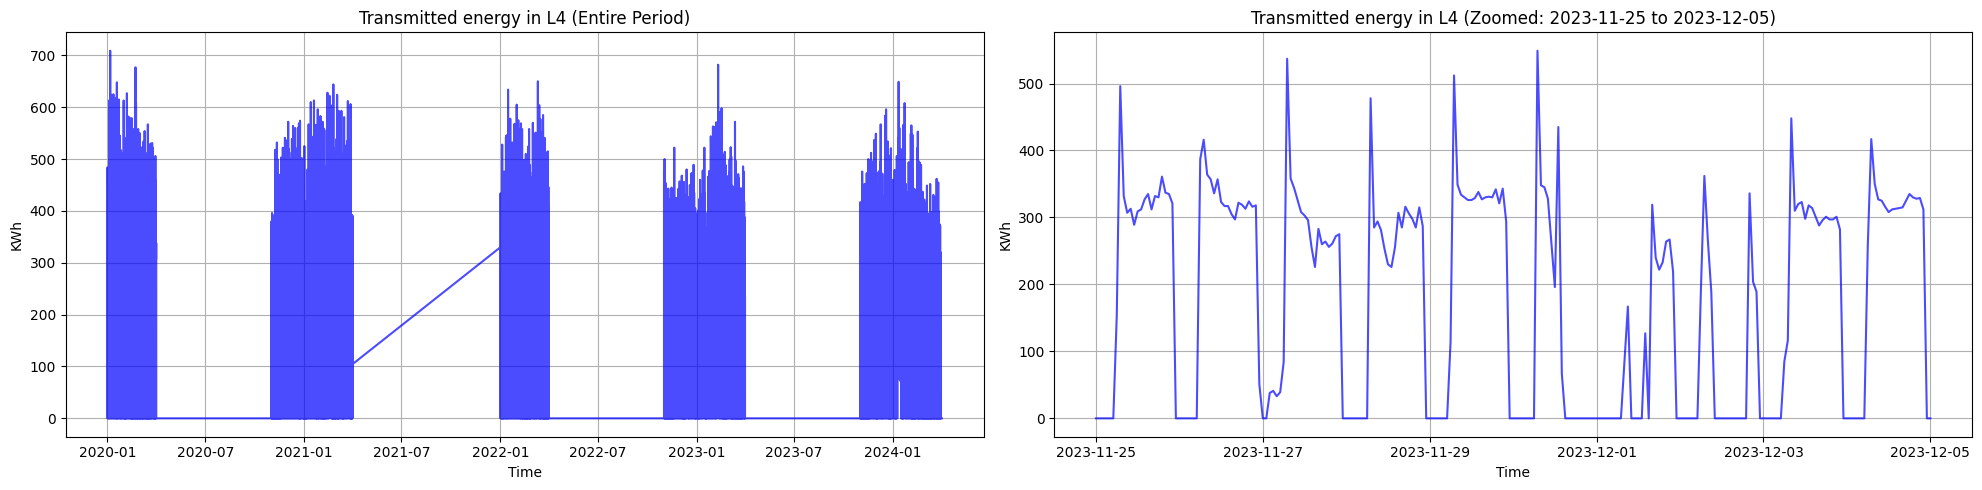

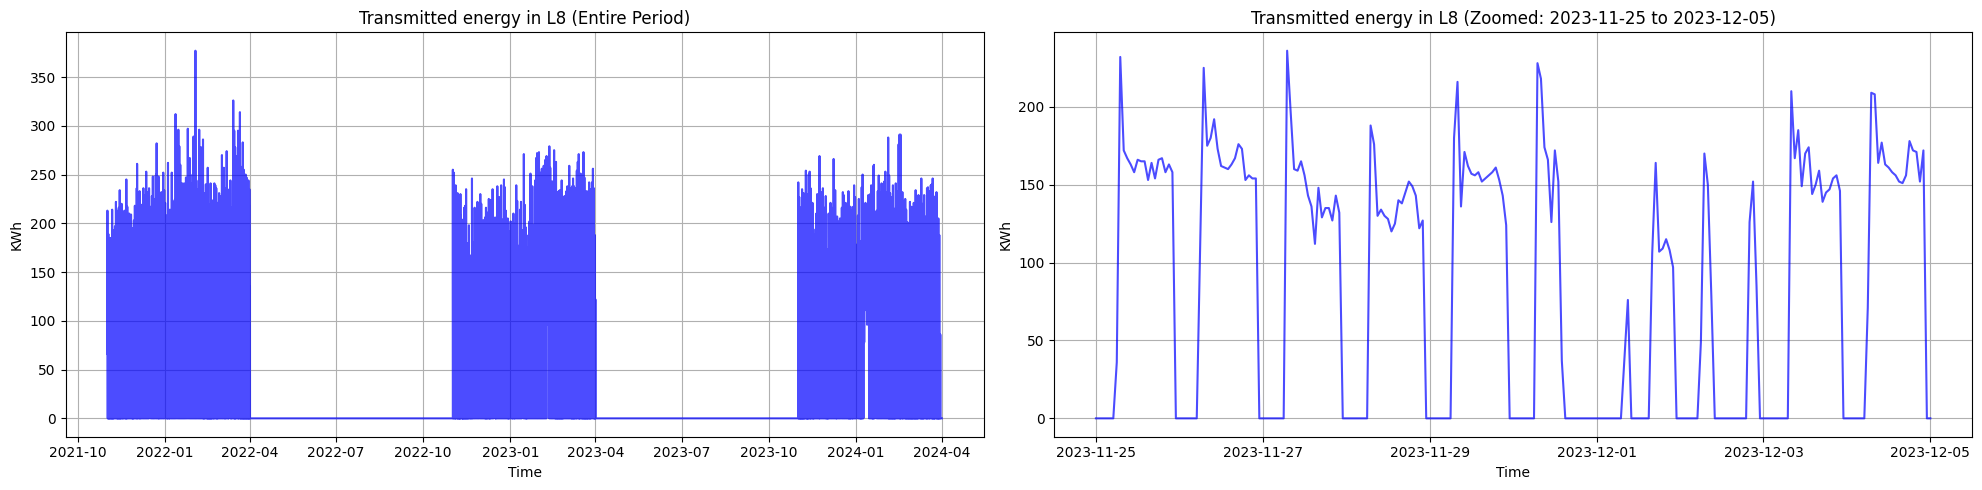

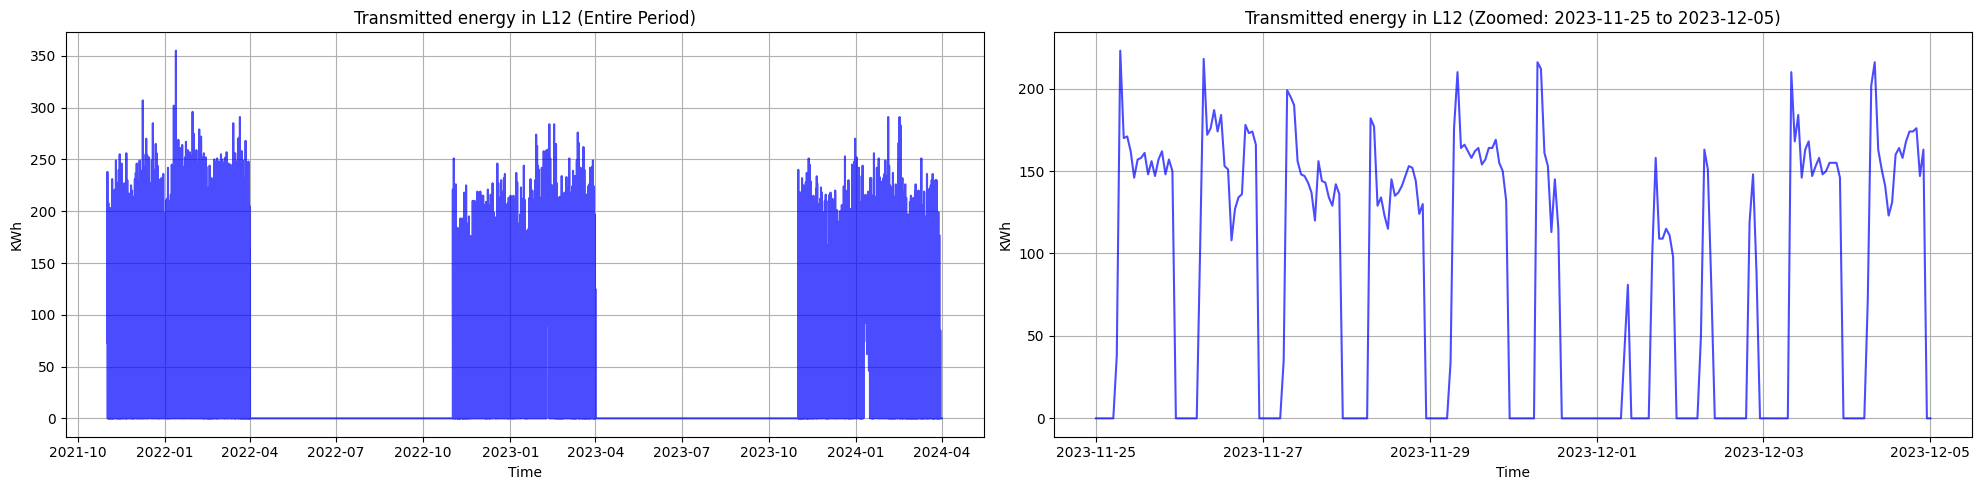

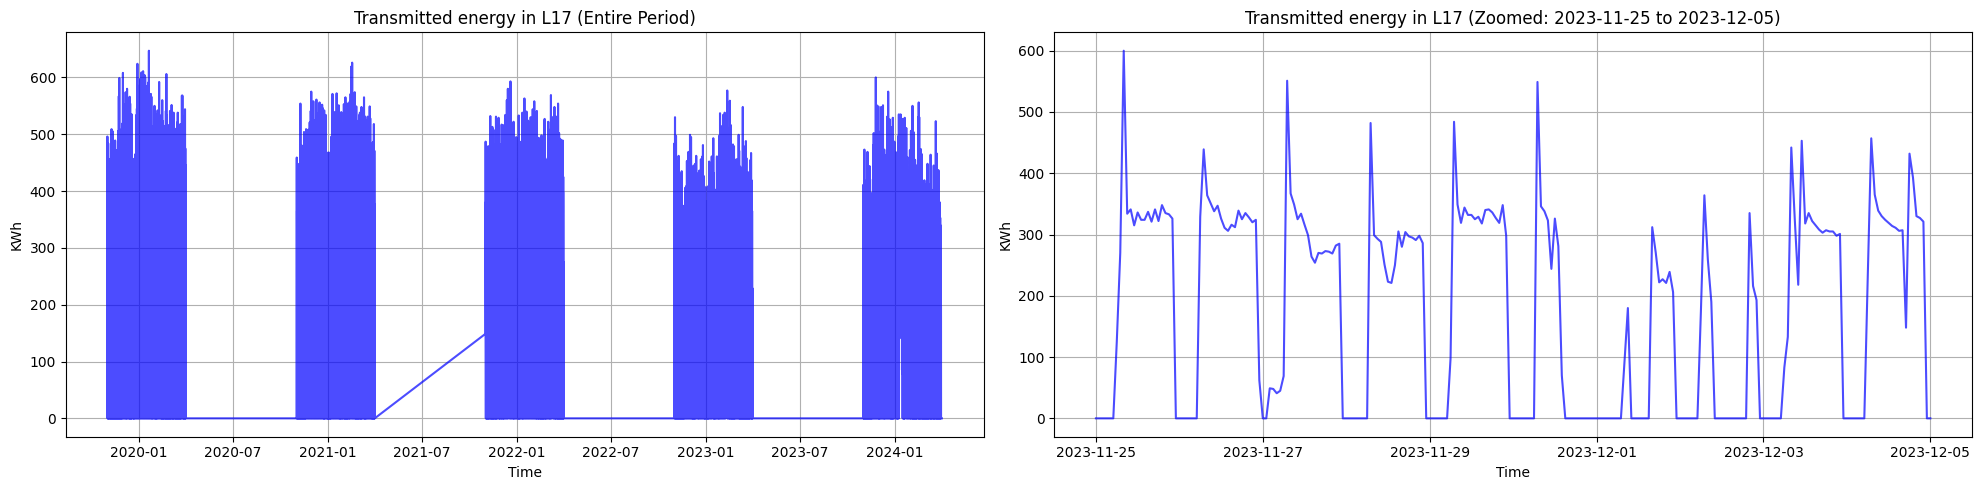

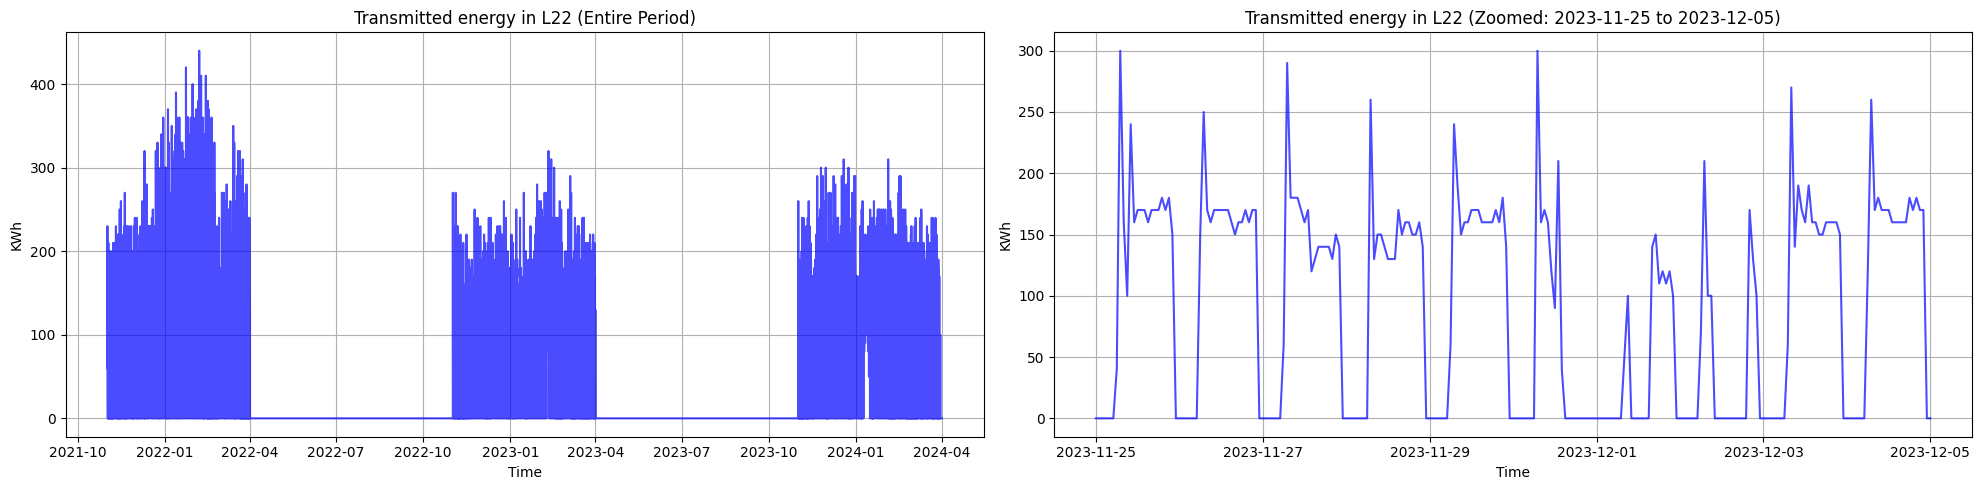

In [9]:
start_date = '2023-11-25'
end_date = '2023-12-05'

for i, df in enumerate(all_data):
    # Filter data for the zoomed-in period
    zoomed_df = df[(df.index >= start_date) & (df.index <= end_date)]

    # Plot the time series signals
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))

    axs[0].plot(df.index, df['deltae'], linestyle='-', color='b', alpha=0.7)
    axs[0].set_title(f'Transmitted energy in {substations[i]} (Entire Period)')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('KWh')
    axs[0].grid(True)

    axs[1].plot(zoomed_df.index, zoomed_df['deltae'], linestyle='-', color='b', alpha=0.7)
    axs[1].set_title(f'Transmitted energy in {substations[i]} (Zoomed: {start_date} to {end_date})')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('KWh')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

Hourly data on transmitted heat energy are highly characterized by intermittency, involving many data points with zero energy transmitted when DHS plant is turned off. There are approximately 4000 zero energy transmitted timepoints in L8, L12 and L22 data, and 5200 and 6551 timepoints in L4 and L17, respectively.

In [10]:
for i, df in enumerate(all_data):
  zero_count = (df['deltae'] == 0).sum().sum()
  #df.to_csv('test.csv')
  print(substations[i], 'Data count', df.shape[0], 'Zero transmitted energy count', zero_count)

L4 Data count 15217 Zero transmitted energy count 5256
L8 Data count 10875 Zero transmitted energy count 3996
L12 Data count 10875 Zero transmitted energy count 4014
L17 Data count 18133 Zero transmitted energy count 6551
L22 Data count 10875 Zero transmitted energy count 4074


Monthly median transmitted energy grouped barplot indicates that the highest heat demand is in January. It also shows that L4 and L17 substations are associated to higher demand, because of significantly larger consumer base. Also, daily total heat demand is plotted for each of the substations, together with daily average ambient temperature, indicating high inverse correlation between those. Median monthly values are normalized by using the total area heated in square meters.

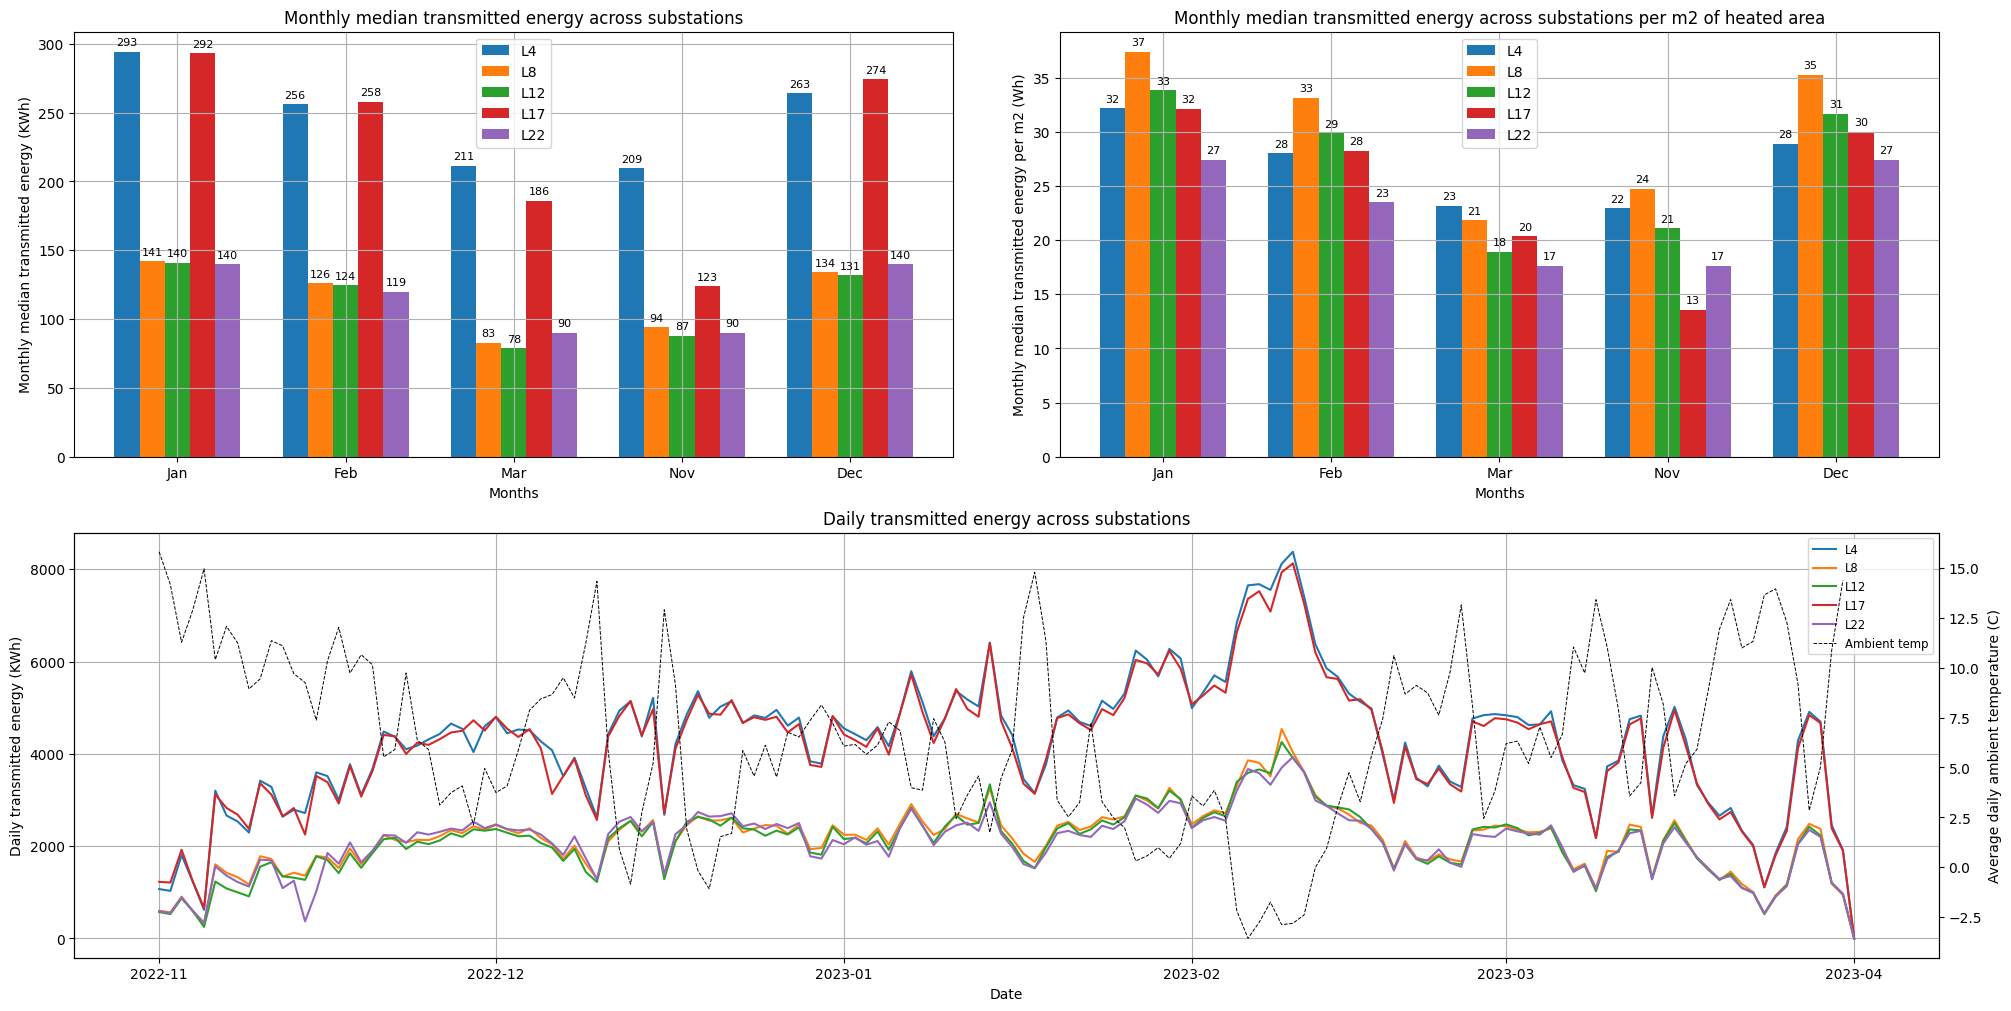

In [11]:
import matplotlib.gridspec as gridspec

monthly_medians = []
daily_sum = []

for i, dfa in enumerate(all_data):
  df=dfa.copy()
  df['month'] = df.index.month
  median_values = df.groupby(['month']).median()['deltae']
  monthly_medians.append(median_values)
  daily_sum.append(df.resample('D').sum())
  temp=df['temp'].resample('D').mean()



fig = plt.figure(figsize=(20, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

months = [0,1,2,3,4]
width = 0.15
heated_area=[9134.96, 3800.69, 4170.98, 9128.1, 5103.59]


ax1 = fig.add_subplot(gs[0, 0])

for i, medians in enumerate(monthly_medians):
    f=[]
    for v in months:
      f.append(v+i * width)
    bars=ax1.bar(f, medians, width=width, align='center', label=f'{substations[i]}')

    for bar, value in zip(bars, medians):
        ax1.annotate(f'{int(value)}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=8)

ticks=[]
for m in months:
  ticks.append(m+((len(all_data) - 1) / 2) * width)

ax1.set_xticks(ticks)  # centering x ticks
ax1.set_xticklabels(['Jan','Feb','Mar','Nov','Dec'])
ax1.set_xlabel('Months')
ax1.set_ylabel('Monthly median transmitted energy (KWh)')
ax1.set_title('Monthly median transmitted energy across substations')
ax1.legend()
ax1.grid(True)


ax2 = fig.add_subplot(gs[0, 1])

for i, medians in enumerate(monthly_medians):
    f=[]
    for v in months:
      f.append(v+i * width)
    bars=ax2.bar(f, 1000*medians/heated_area[i], width=width, align='center', label=f'{substations[i]}')
    for bar, value in zip(bars, 1000*medians/heated_area[i]):
        ax2.annotate(f'{int(value)}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom', fontsize=8)

ticks=[]
for m in months:
  ticks.append(m+((len(all_data) - 1) / 2) * width)

ax2.set_xticks(ticks)  # centering x ticks
ax2.set_xticklabels(['Jan','Feb','Mar','Nov','Dec'])
ax2.set_xlabel('Months')
ax2.set_ylabel('Monthly median transmitted energy per m2 (Wh)')
ax2.set_title('Monthly median transmitted energy across substations per m2 of heated area')
ax2.legend()
ax2.grid(True)


ax4 = fig.add_subplot(gs[1, :])

start_date = '2022-11-01'
end_date = '2023-04-01'
zoomed_temp = temp[(temp.index >= start_date) & (temp.index <= end_date)]
lines=[0,0,0,0,0,0]
for i, df in enumerate(daily_sum):
    zoomed_df = df[(df.index >= start_date) & (df.index <= end_date)]

    lines[i],=ax4.plot(zoomed_df.index, zoomed_df['deltae'], label=f'{substations[i]}')

ax3=ax4.twinx()
ax3.set_ylabel('Average daily ambient temperature (C)')
lines[5], = ax3.plot(zoomed_temp.index, zoomed_temp, linestyle='--', color='black', label='Ambient temp', linewidth=0.7)

ax4.set_xlabel('Date')
ax4.set_ylabel('Daily transmitted energy (KWh)')
ax4.set_title('Daily transmitted energy across substations')
labels = [line.get_label() for line in lines]
ax4.legend(lines, labels, fontsize='small')
ax4.grid(True)

#plt.tight_layout()
plt.show()

Transmitted energy data distributions are illustrated below. Histogram for L22 reveal that the values are in multiples of ten. The reason for that is the fact that the calorimeter was set to record values of absolute transmitted energy with insufficient prevision, namely with two decimal places. Given that this is communicated in MW, it appears that important information was lost.

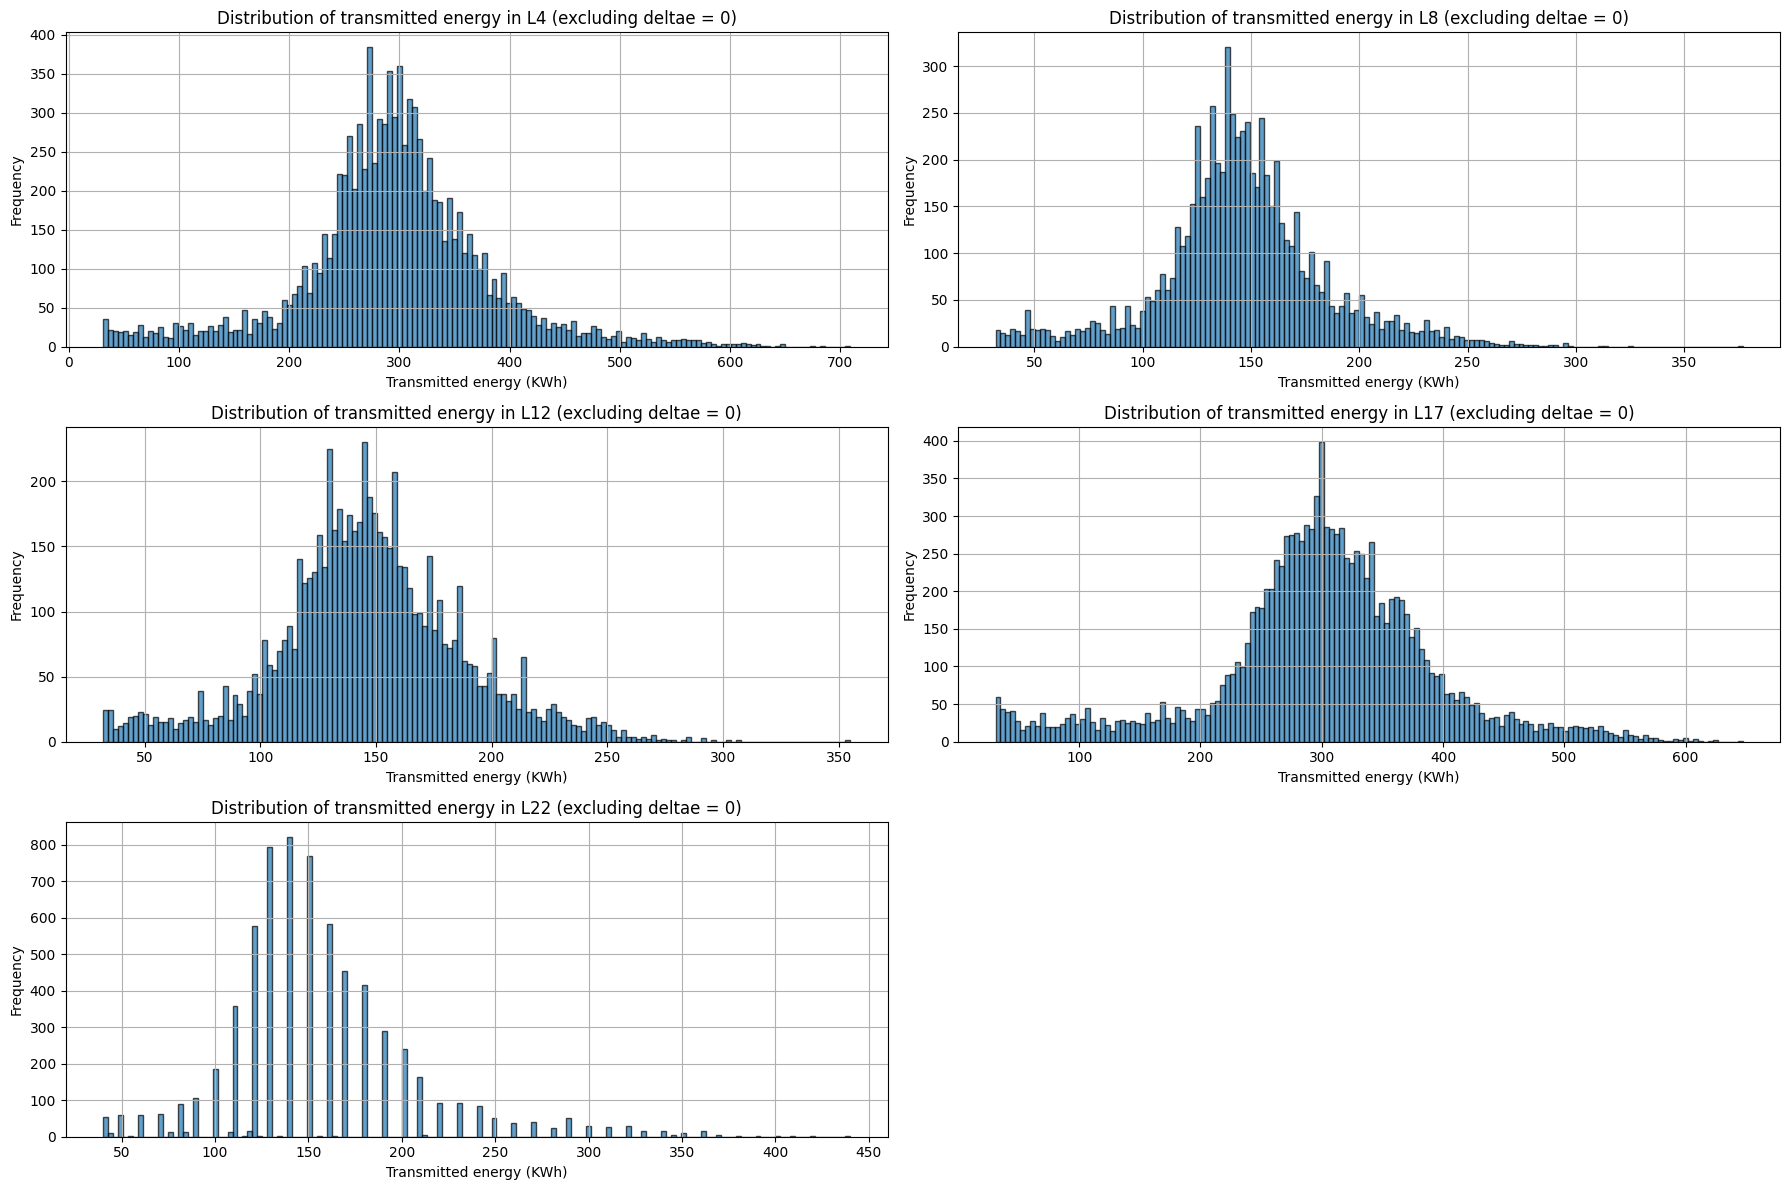

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes

for i, (ax, df) in enumerate(zip(axes, all_data)):
  filtered_df = df[df['deltae'] != 0]
  ax.hist(filtered_df['deltae'], bins=150, edgecolor='k', alpha=0.7)
  ax.set_title(f'Distribution of transmitted energy in {substations[i]} (excluding deltae = 0)')
  ax.set_xlabel('Transmitted energy (KWh)')
  ax.set_ylabel('Frequency')
  ax.grid(True)

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

## Forecasting

In this experiment, heat demand forecasting is defined as single-step forecasting. Single-step forecasting is useful for guiding the decisions at every hour, which is meaningful due to the fact that system inertia in the case of experimentation facility is only 15 mins.

Four metrics will be used in the experiment. Root Mean Squared Error (RMSE) is good for penalizing large errors but can be sensitive to the scale of the data and the presence of outliers. Mean Absolute Error (MAE) is less sensitive to large errors and outliers, providing a straightforward measure of average error magnitude. Mean Absolute Scaled Error (MASE) scales the MAE by the average in-sample forecast error from a naïve model, which is particularly useful for intermittent series because it normalizes the performance metric, making comparisons across different datasets more meaningful.

$$ \text{MASE} = \frac{\frac{1}{h} \sum_{t=n+1}^{n+h} |e_t|}{\frac{1}{n-1} \sum_{t=2}^{n} |y_t - y_{t-1}|} $$

where
- $h$ is the forecast horizon (number of periods ahead being forecasted).
- $n$ is the number of observations in the training set.
- $e_t$ is the forecast error (difference between the actual value and the forecasted value).
- $y_t$ are the actual values in the training set.

Symmetric Mean Absolute Percentage Error (sMAPE) is introduced as a metric commonly used to measure the accuracy of forecasts, particularly in cases where comparing errors in percentage terms is desired and where the scale of the data varies widely. It addresses some of the limitations of traditional MAPE, especially when dealing with intermittent or sporadic data.  sMAPE values are typically between 0% (perfect accuracy) and 200% (worst accuracy). A lower sMAPE indicates better forecasting accuracy. sMAPE is calculated as it follows.

$$ \text{sMAPE} = \frac{1}{n} \sum_{t=1}^{n} \frac{|A_t - F_t|}{(|A_t| + |F_t|)/2} \times 100\% $$

where
- $A_t$ is the actual value at timepoint t
- $F_t$ is the forecasted value for timepoint t
- $n$ is total number of timepoints

sMAPE is normally considered as much more relevant metric than MAPE for several reasons. It avoids the MAPE's problem of undefined metrics (division by zero) when actual values equal zero (which is often the case in DHS datasets). It equally penalizes over and under-predictions (symmetry), which is not the case with MAPE, and it reduces the effect of outliers.

The coefficient of determination R<sup>2</sup> is assessed, as a statistical measure that indicates how well the regression predictions approximate the real data points. It provides a measure of how much variation in the dependent variable (y) can be explained by the independent variables (x) in a regression model.

$$ R^2 = 1 - \frac{\sum_{i}(y_i - \hat{y}_i)^2}{\sum_{i}(y_i - \bar{y})^2} $$

where
- $y_i$ are the actual values of the dependent variable,
- $\hat{y}_i$ are the predicted values from the regression model,
- $\bar{y}$ is the mean of the actual values.

In [13]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0

    # Avoid division by zero by replacing denominator with a small value where true and pred are both zero
    denominator[np.where(denominator == 0)] = 1e-8

    smape = np.mean(numerator / denominator) * 100
    return smape

For all datasets and all methods used, two thirds of data will be used for training and one third, for testing the models.

### Implementation of ML models

Two ML algorithms will be used in this experiment, both known for great performance on tabular datasets and proven as the most succesful in great most of the Kaggle competitions: XGBoost and LightGBM.

XGBoost (Extreme Gradient Boosting) (Chen and Guestrin, 2016) is an implementation of gradient boosted decision trees, an ensemble learning method, specifically a boosting technique. It builds the model in stages, and each stage adds new models to correct the errors made by the existing ensemble of models. It operates within the gradient boosting framework (Breiman, 1997) by constructing a new model that adds to an existing ensemble of models in a way that minimizes the overall prediction error. The "gradient boosting" part refers to the algorithm's use of the gradient descent algorithm to minimize the loss when adding new models. XGBoost primarily uses decision trees as its base learners. Each new tree corrects the residual errors (differences between predicted and actual values) of the previous trees. A key feature that differentiates XGBoost from other gradient boosting methods is its built-in regularization (both L1 and L2), which helps to prevent overfitting and improve model generalization. XGBoost can automatically handle missing data, making it robust to problems with incomplete datasets. It is optimized to efficiently handle sparse data (data with many zeros). It incorporates a learning rate (also called shrinkage), which scales the contribution of each new tree added to the model. This can be used to prevent overfitting.

The Extra Trees (Extremely Randomized Trees) algorithm (Gerts et al, 2006) is an ensemble voting-based learning method, similar to well-known Random Forest. It implements random sampling of features at each split in a tree, which is also done randomly. Extra randomness contributes to the faster training (avoiding the computational cost of finding the best split) and reduced overfitting, but it is characterized by less interpretability than other tree ensembles. Normally, it is a good candidate for large tabular datasets with high dimensionality.

LightGBM (Light Gradient Boosting Machine) (Ke et al, 2017) is a gradient boosting framework developed by Microsoft, designed to be highly efficient with high performance. It can handle large-scale data and takes full advantage of hardware optimizations - it is capable of parallel and GPU learning, drastically reducing the training time when compared to other implementations of gradient boosting. One of the key features of LightGBM is Gradient-based One-Side Sampling (GOSS); it is a technique that improves efficiency by focusing on instances with larger gradients. It keeps all the instances with large gradients and randomly selects a subset of instances with small gradients during the training process. This allows the model to learn mostly from the more informative instances. It is faster at training than many of its competitors and requires less memory to run. With advanced techniques like GOSS, LightGBM often achieves higher accuracy with fewer trees than other gradient boosting techniques.

Feature engineering practices ensure that time dimensions are accurately reflected in the relevant features. Given the cyclic nature of district heating systems operation, it is clear that hour of day is one of the most significant features. Besides that, relevance of day of the week is expected to be non-trivial, especially when considering if the day is a working day or not.

Similarly to what has been done in preparing the data for training of LSTM model, 24 timepoints in the past are considered in individual data instance.

L4
-----------------------------------
The XGB training took 0.3867213726043701 seconds to execute
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11699
[LightGBM] [Info] Number of data points in the train set: 12173, number of used features: 63
[LightGBM] [Info] Start training from score 194.790150
The LGB training took 0.22363662719726562 seconds to execute
The XTR training took 10.070716142654419 seconds to execute
The XGB inference took 0.011037349700927734 seconds to execute
The XTR inference took 0.05951094627380371 seconds to execute
The LGB inference took 0.006495237350463867 seconds to execute
XGB Root Mean Squared Error (RMSE): 63.34571342855904
XGB Mean Absolute Error (MAE): 33.51321533326507
XGB Mean Absolute Scaled Error (MASE): 0.6069216369481963
XGB Symmetric Mean Absolute Percentage Error (sMAPE): 82.44588150212881
XGB R² Score: 

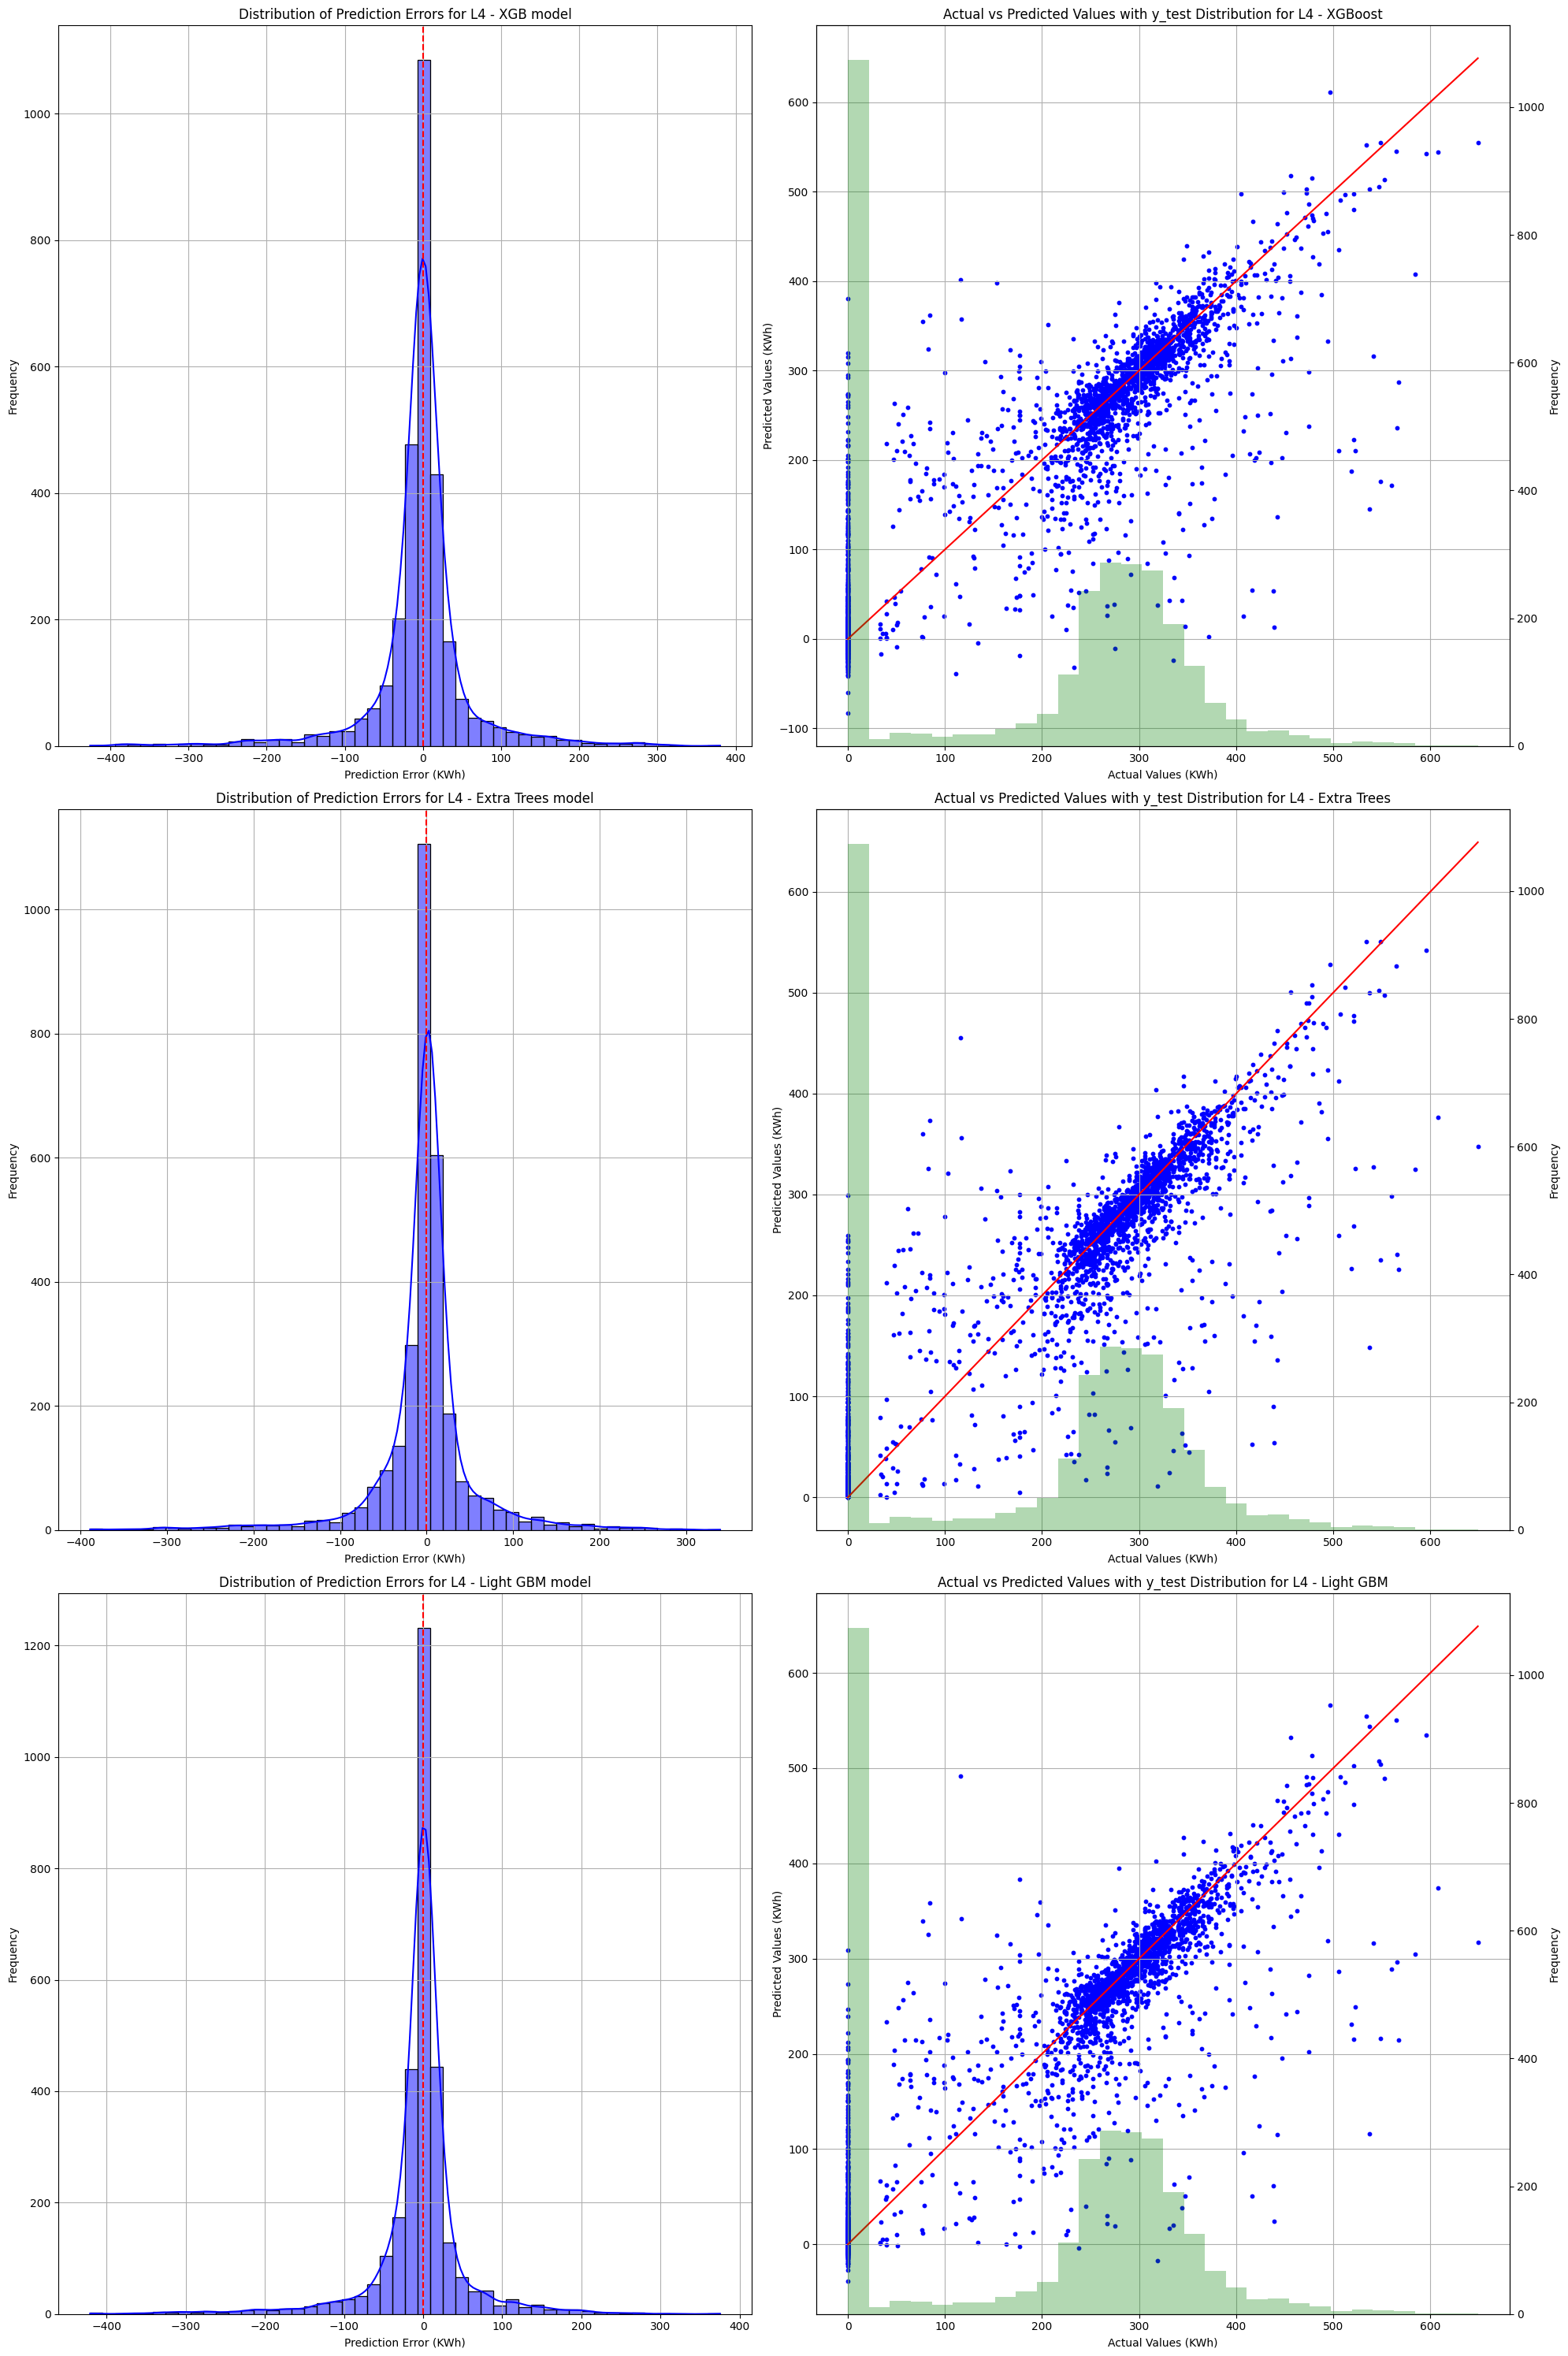

L8
-----------------------------------
The XGB training took 0.22394990921020508 seconds to execute
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11018
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 63
[LightGBM] [Info] Start training from score 93.166092
The LGB training took 0.11404848098754883 seconds to execute
The XTR training took 6.913381099700928 seconds to execute
The XGB inference took 0.009931564331054688 seconds to execute
The XTR inference took 0.04200005531311035 seconds to execute
The LGB inference took 0.006754875183105469 seconds to execute
XGB Root Mean Squared Error (RMSE): 28.512606812412024
XGB Mean Absolute Error (MAE): 15.4542868332479
XGB Mean Absolute Scaled Error (MASE): 0.5217384715206582
XGB Symmetric Mean Absolute Percentage Error (sMAPE): 87.3800214861907
XGB R² Score: 0.8

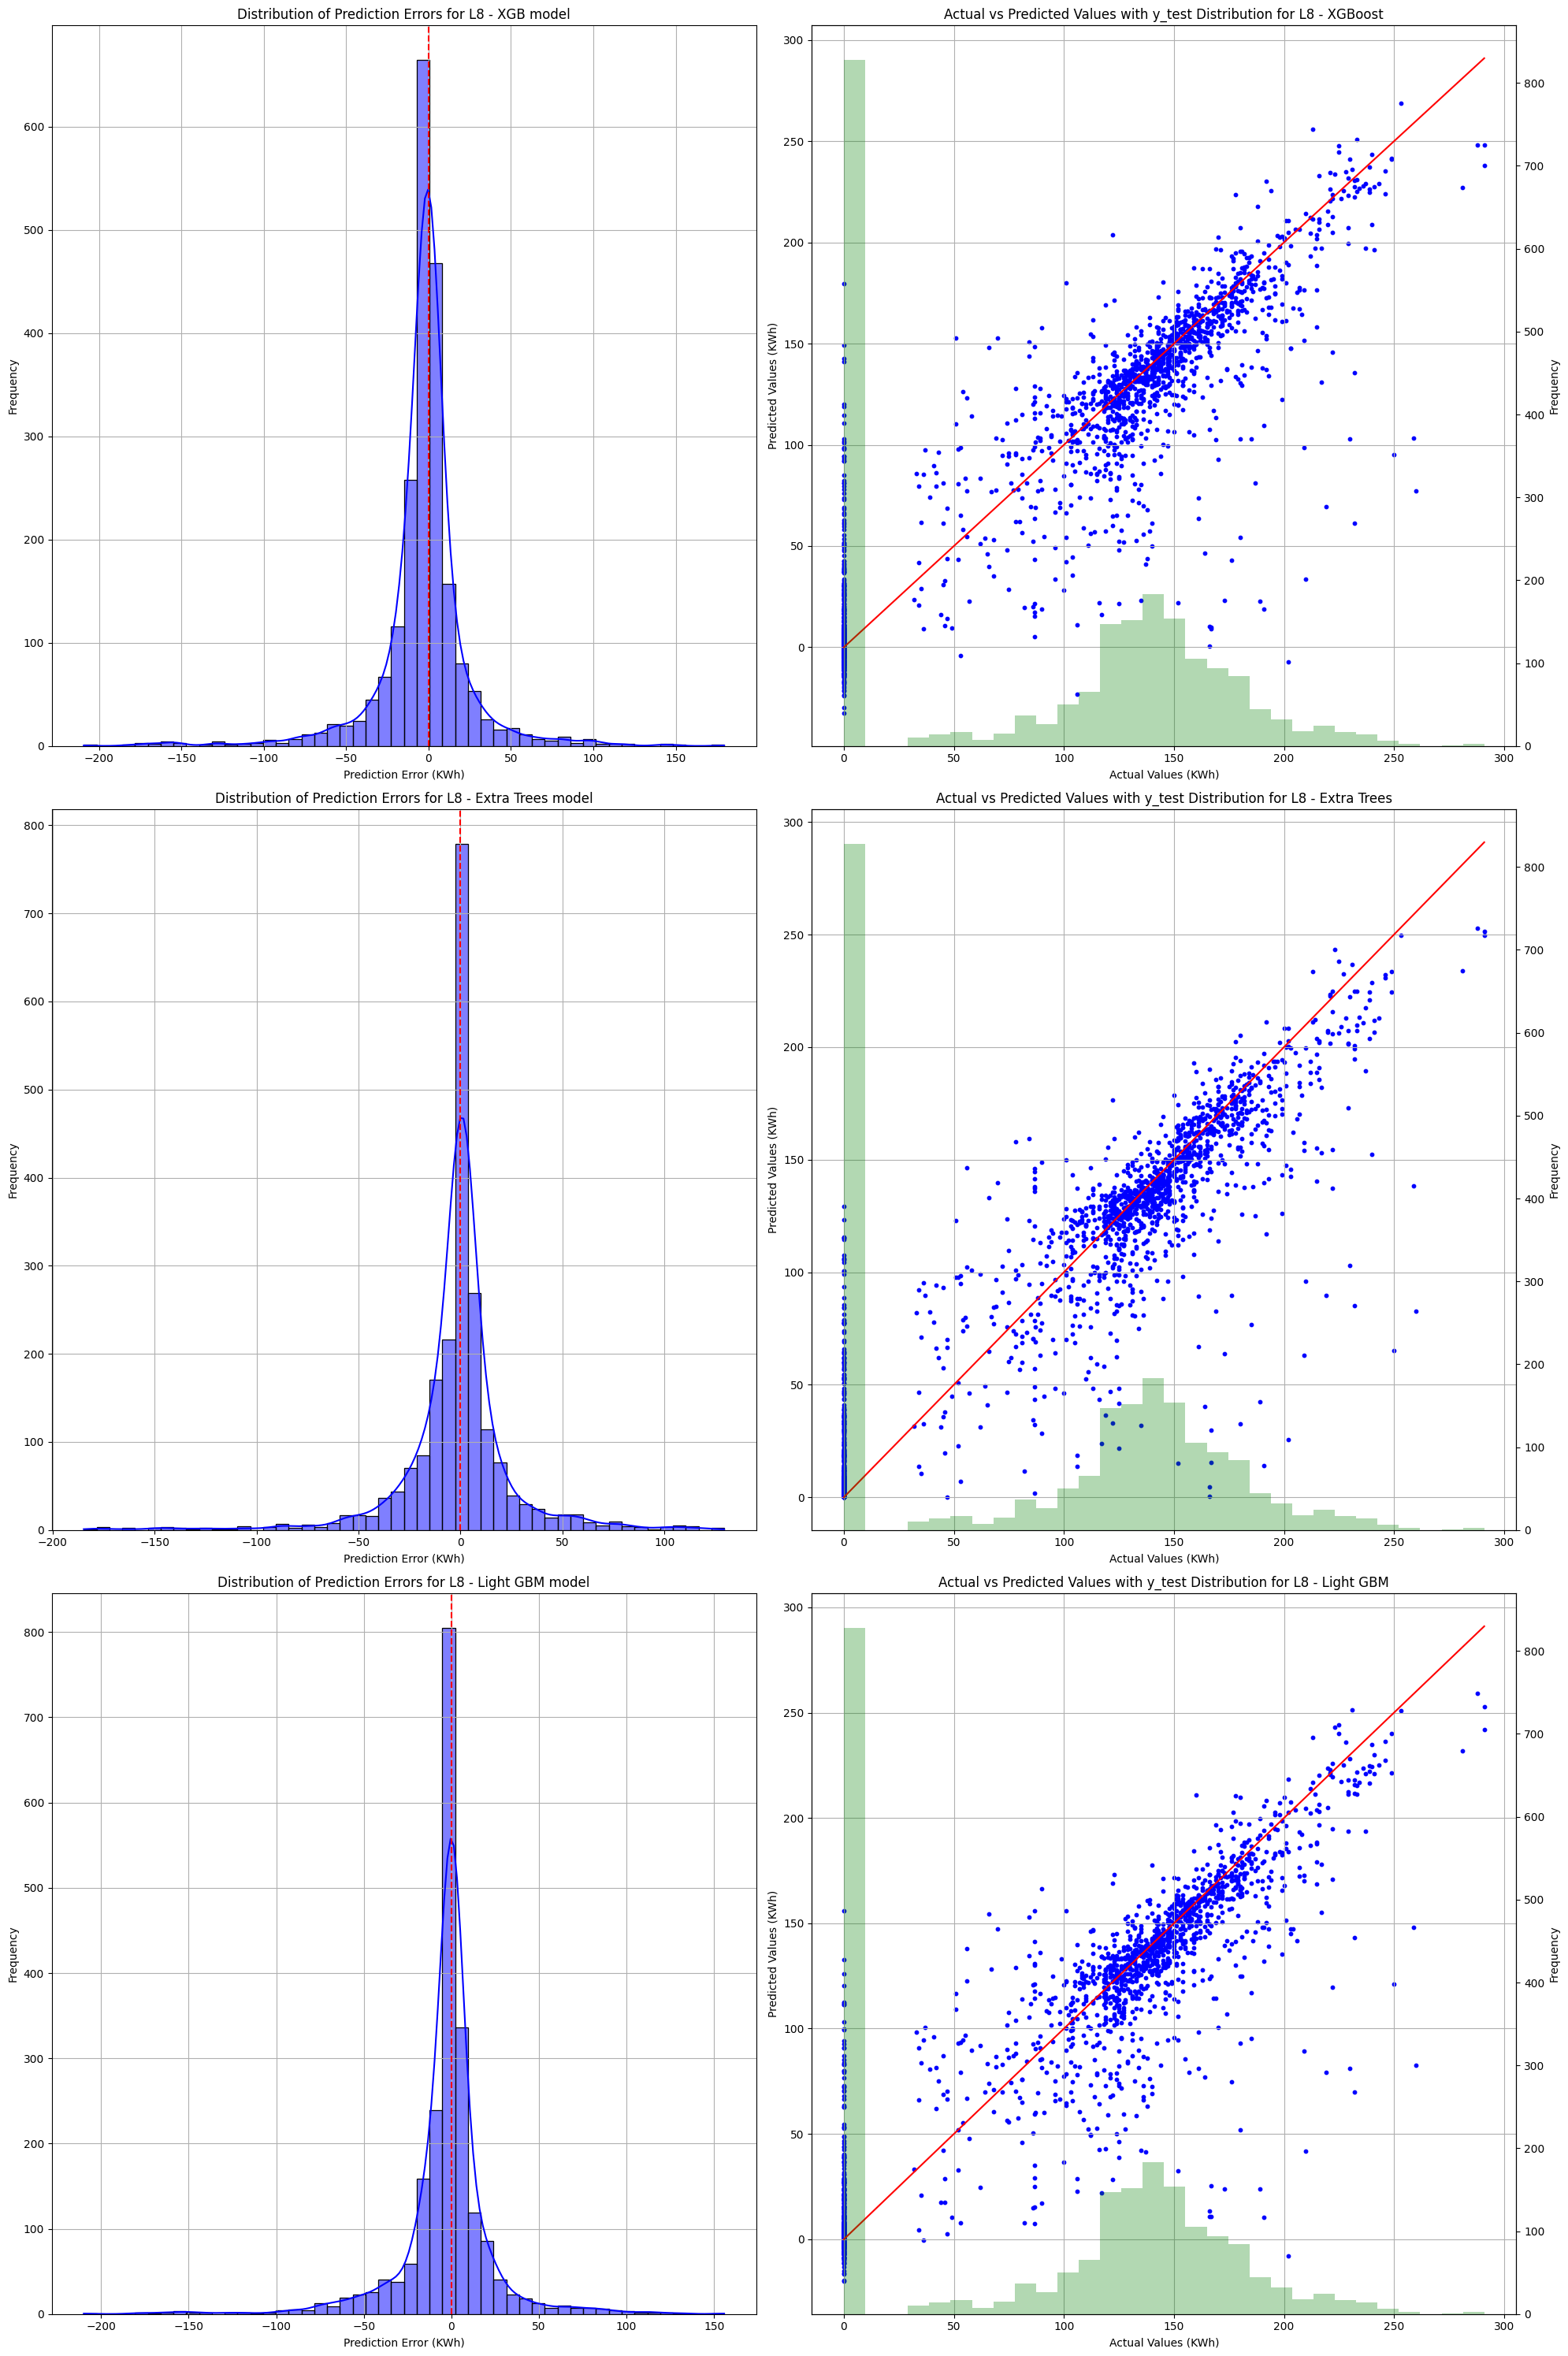

L12
-----------------------------------
The XGB training took 0.18756532669067383 seconds to execute
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11072
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 63
[LightGBM] [Info] Start training from score 94.349483
The LGB training took 0.1207582950592041 seconds to execute
The XTR training took 7.565846920013428 seconds to execute
The XGB inference took 0.012207746505737305 seconds to execute
The XTR inference took 0.03999805450439453 seconds to execute
The LGB inference took 0.007433652877807617 seconds to execute
XGB Root Mean Squared Error (RMSE): 28.714989478207926
XGB Mean Absolute Error (MAE): 15.903101151569505
XGB Mean Absolute Scaled Error (MASE): 0.5409012610145923
XGB Symmetric Mean Absolute Percentage Error (sMAPE): 87.71304536189288
XGB R² Score: 

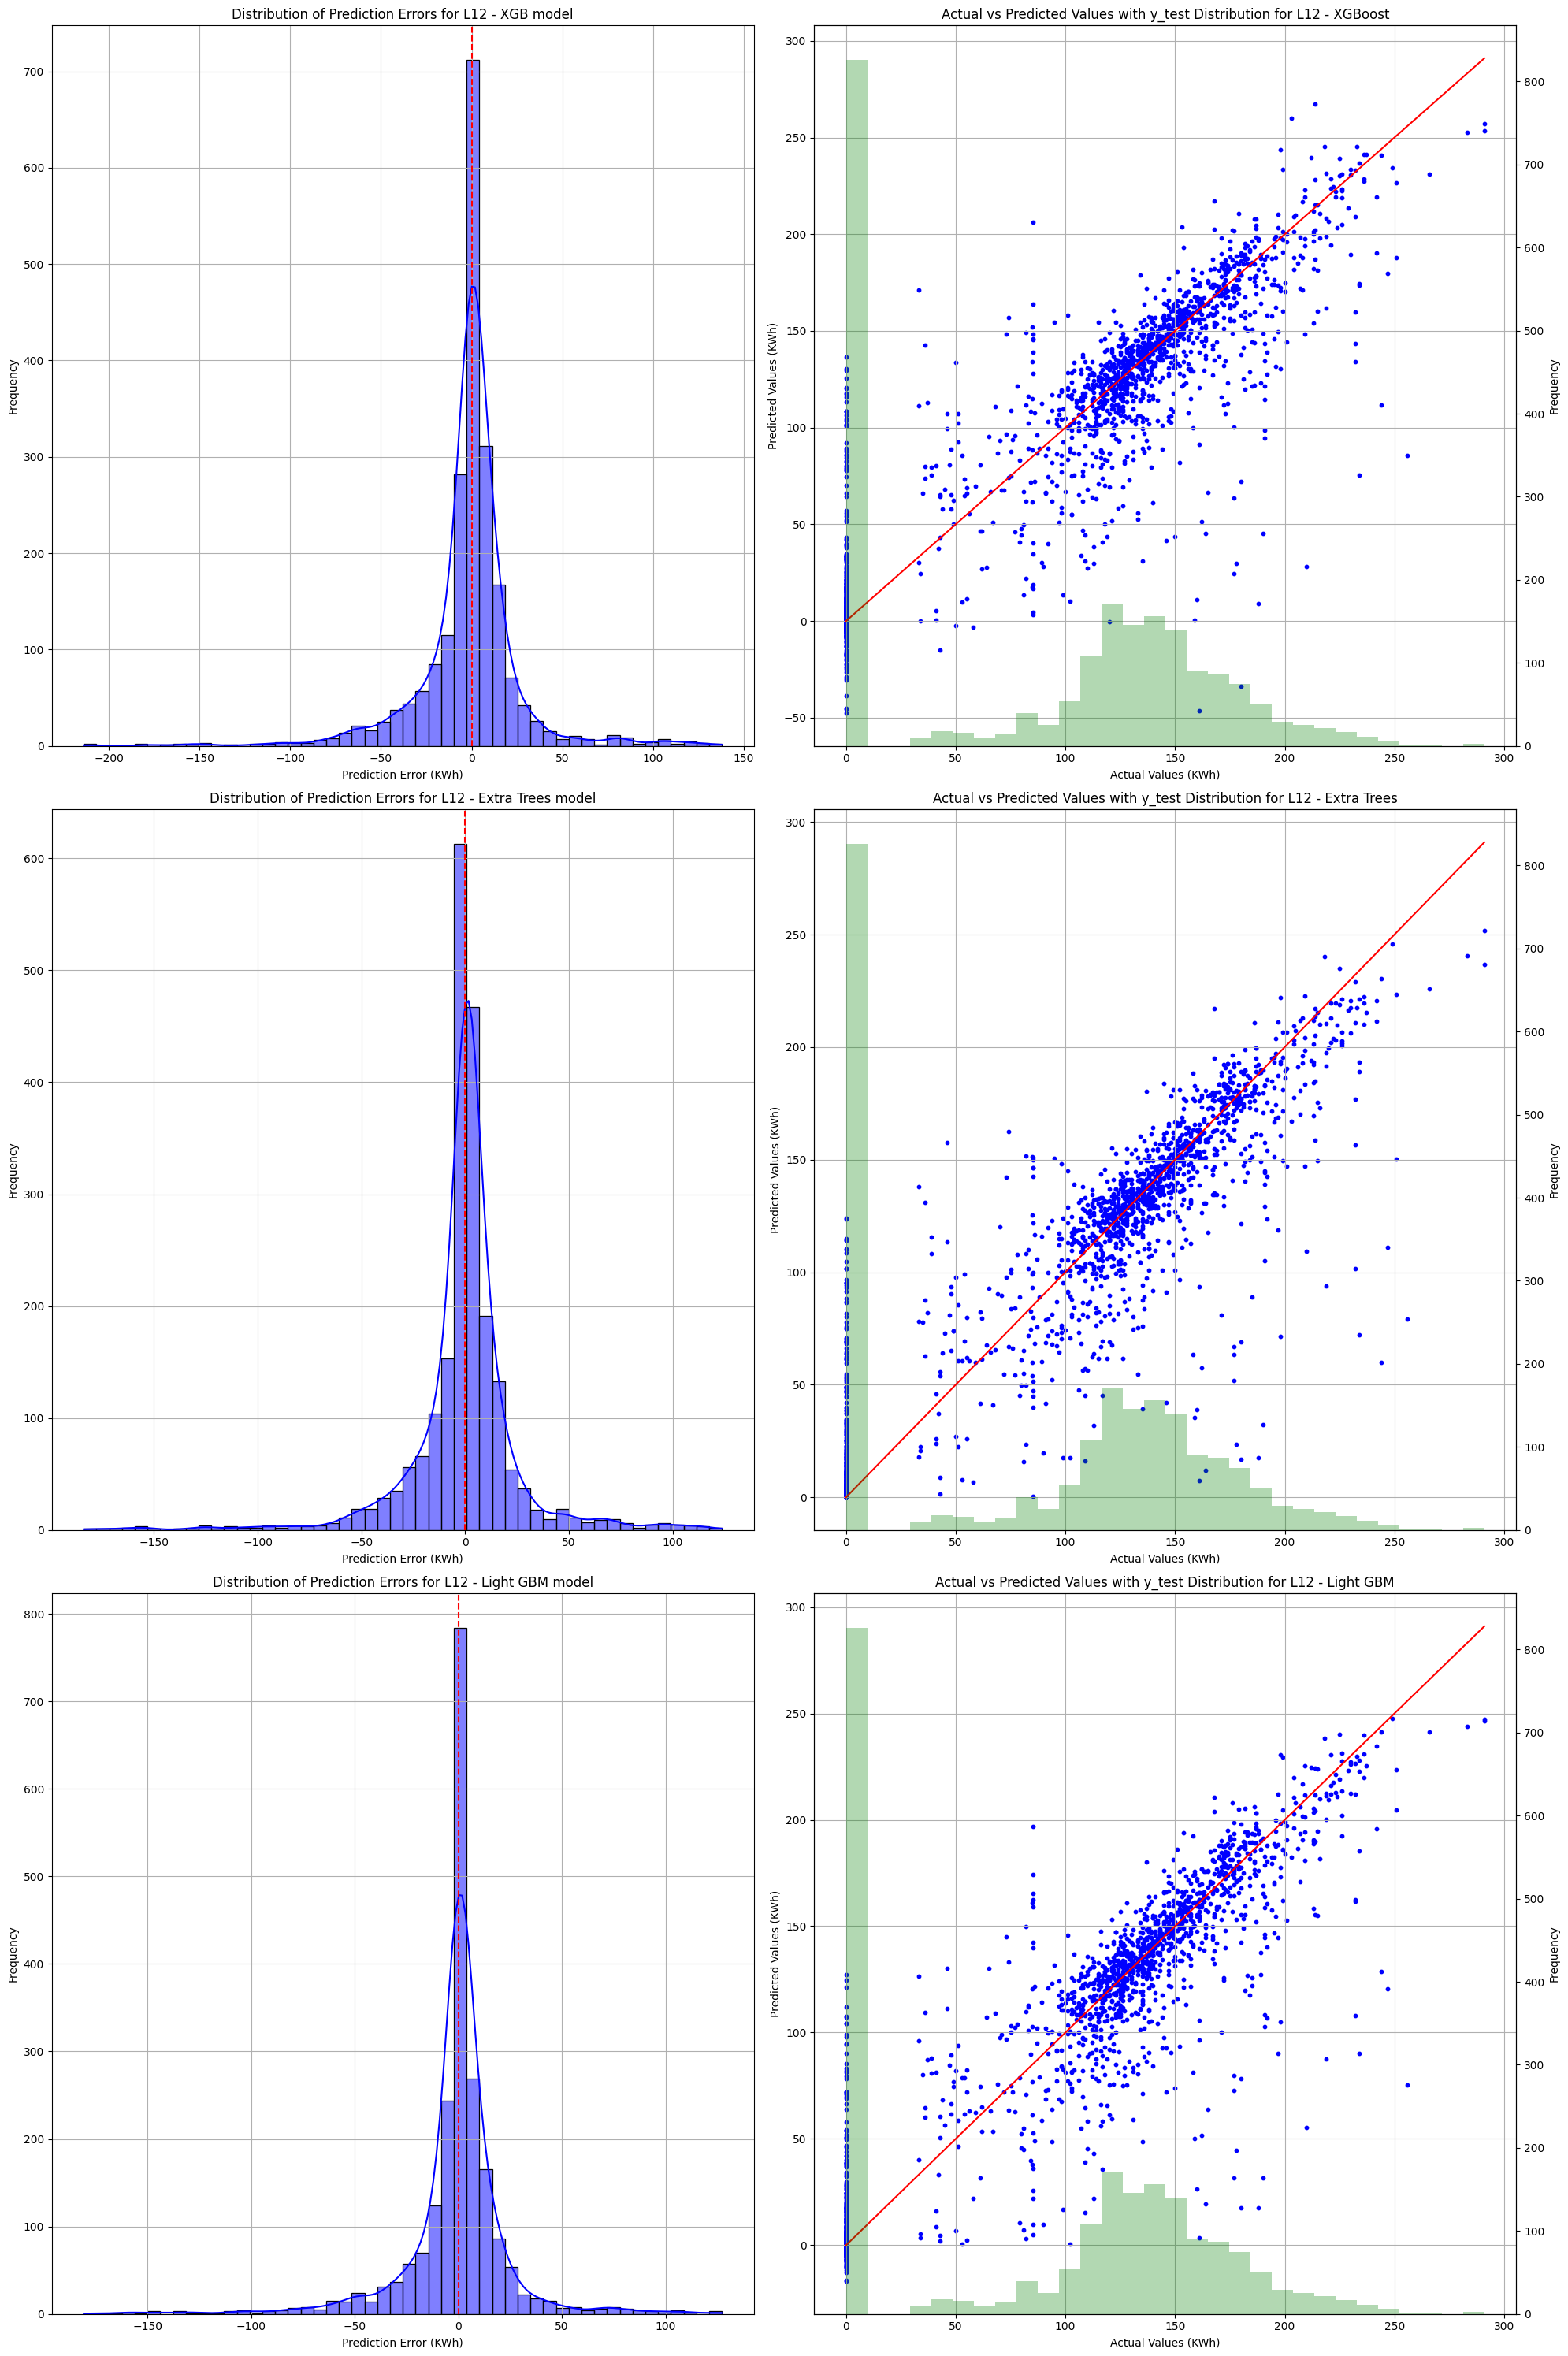

L17
-----------------------------------
The XGB training took 0.27611589431762695 seconds to execute
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11790
[LightGBM] [Info] Number of data points in the train set: 14506, number of used features: 63
[LightGBM] [Info] Start training from score 194.652420
The LGB training took 0.17809057235717773 seconds to execute
The XTR training took 15.121354103088379 seconds to execute
The XGB inference took 0.014007091522216797 seconds to execute
The XTR inference took 0.07251858711242676 seconds to execute
The LGB inference took 0.008508920669555664 seconds to execute
XGB Root Mean Squared Error (RMSE): 58.712658687880456
XGB Mean Absolute Error (MAE): 31.812961146226666
XGB Mean Absolute Scaled Error (MASE): 0.5709311299536791
XGB Symmetric Mean Absolute Percentage Error (sMAPE): 85.68118407838435
XGB R² Sco

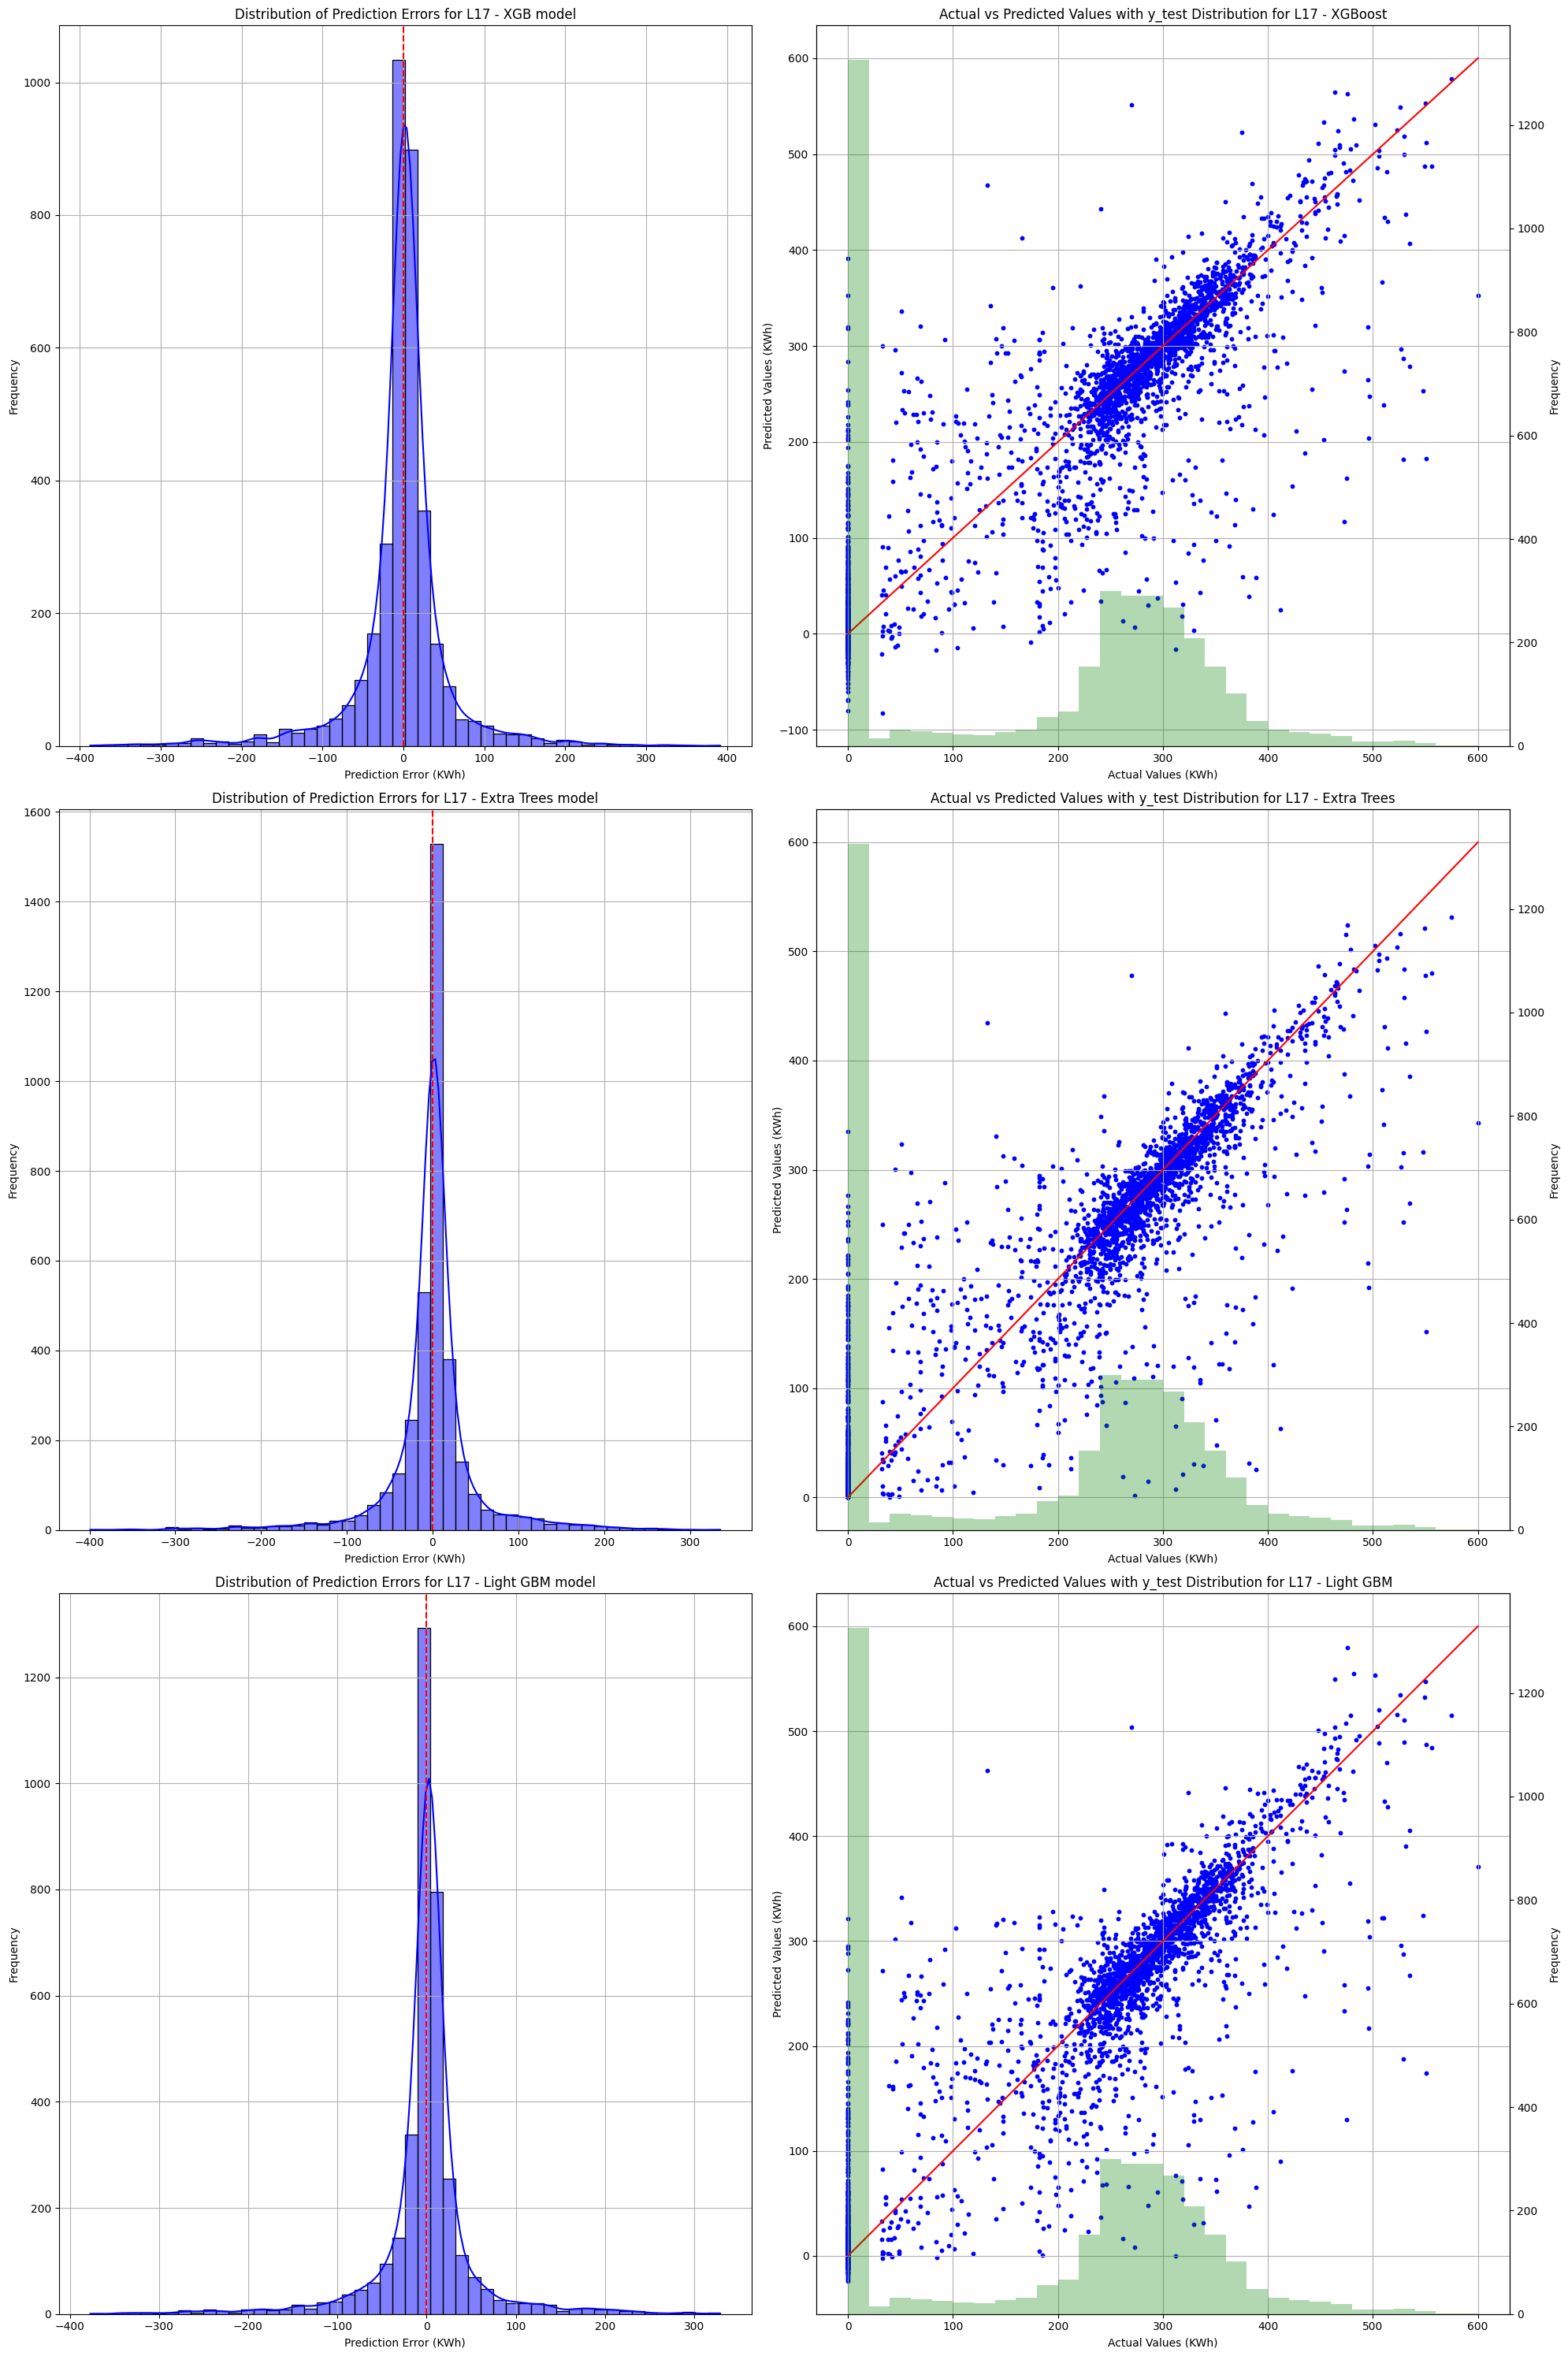

L22
-----------------------------------
The XGB training took 0.24268269538879395 seconds to execute
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6598
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 63
[LightGBM] [Info] Start training from score 99.726437
The LGB training took 0.10091614723205566 seconds to execute
The XTR training took 5.9974730014801025 seconds to execute
The XGB inference took 0.010085821151733398 seconds to execute
The XTR inference took 0.03500032424926758 seconds to execute
The LGB inference took 0.006121158599853516 seconds to execute
XGB Root Mean Squared Error (RMSE): 31.573950884615336
XGB Mean Absolute Error (MAE): 17.723804921938125
XGB Mean Absolute Scaled Error (MASE): 0.5975597235200586
XGB Symmetric Mean Absolute Percentage Error (sMAPE): 91.29570534435638
XGB R² Score:

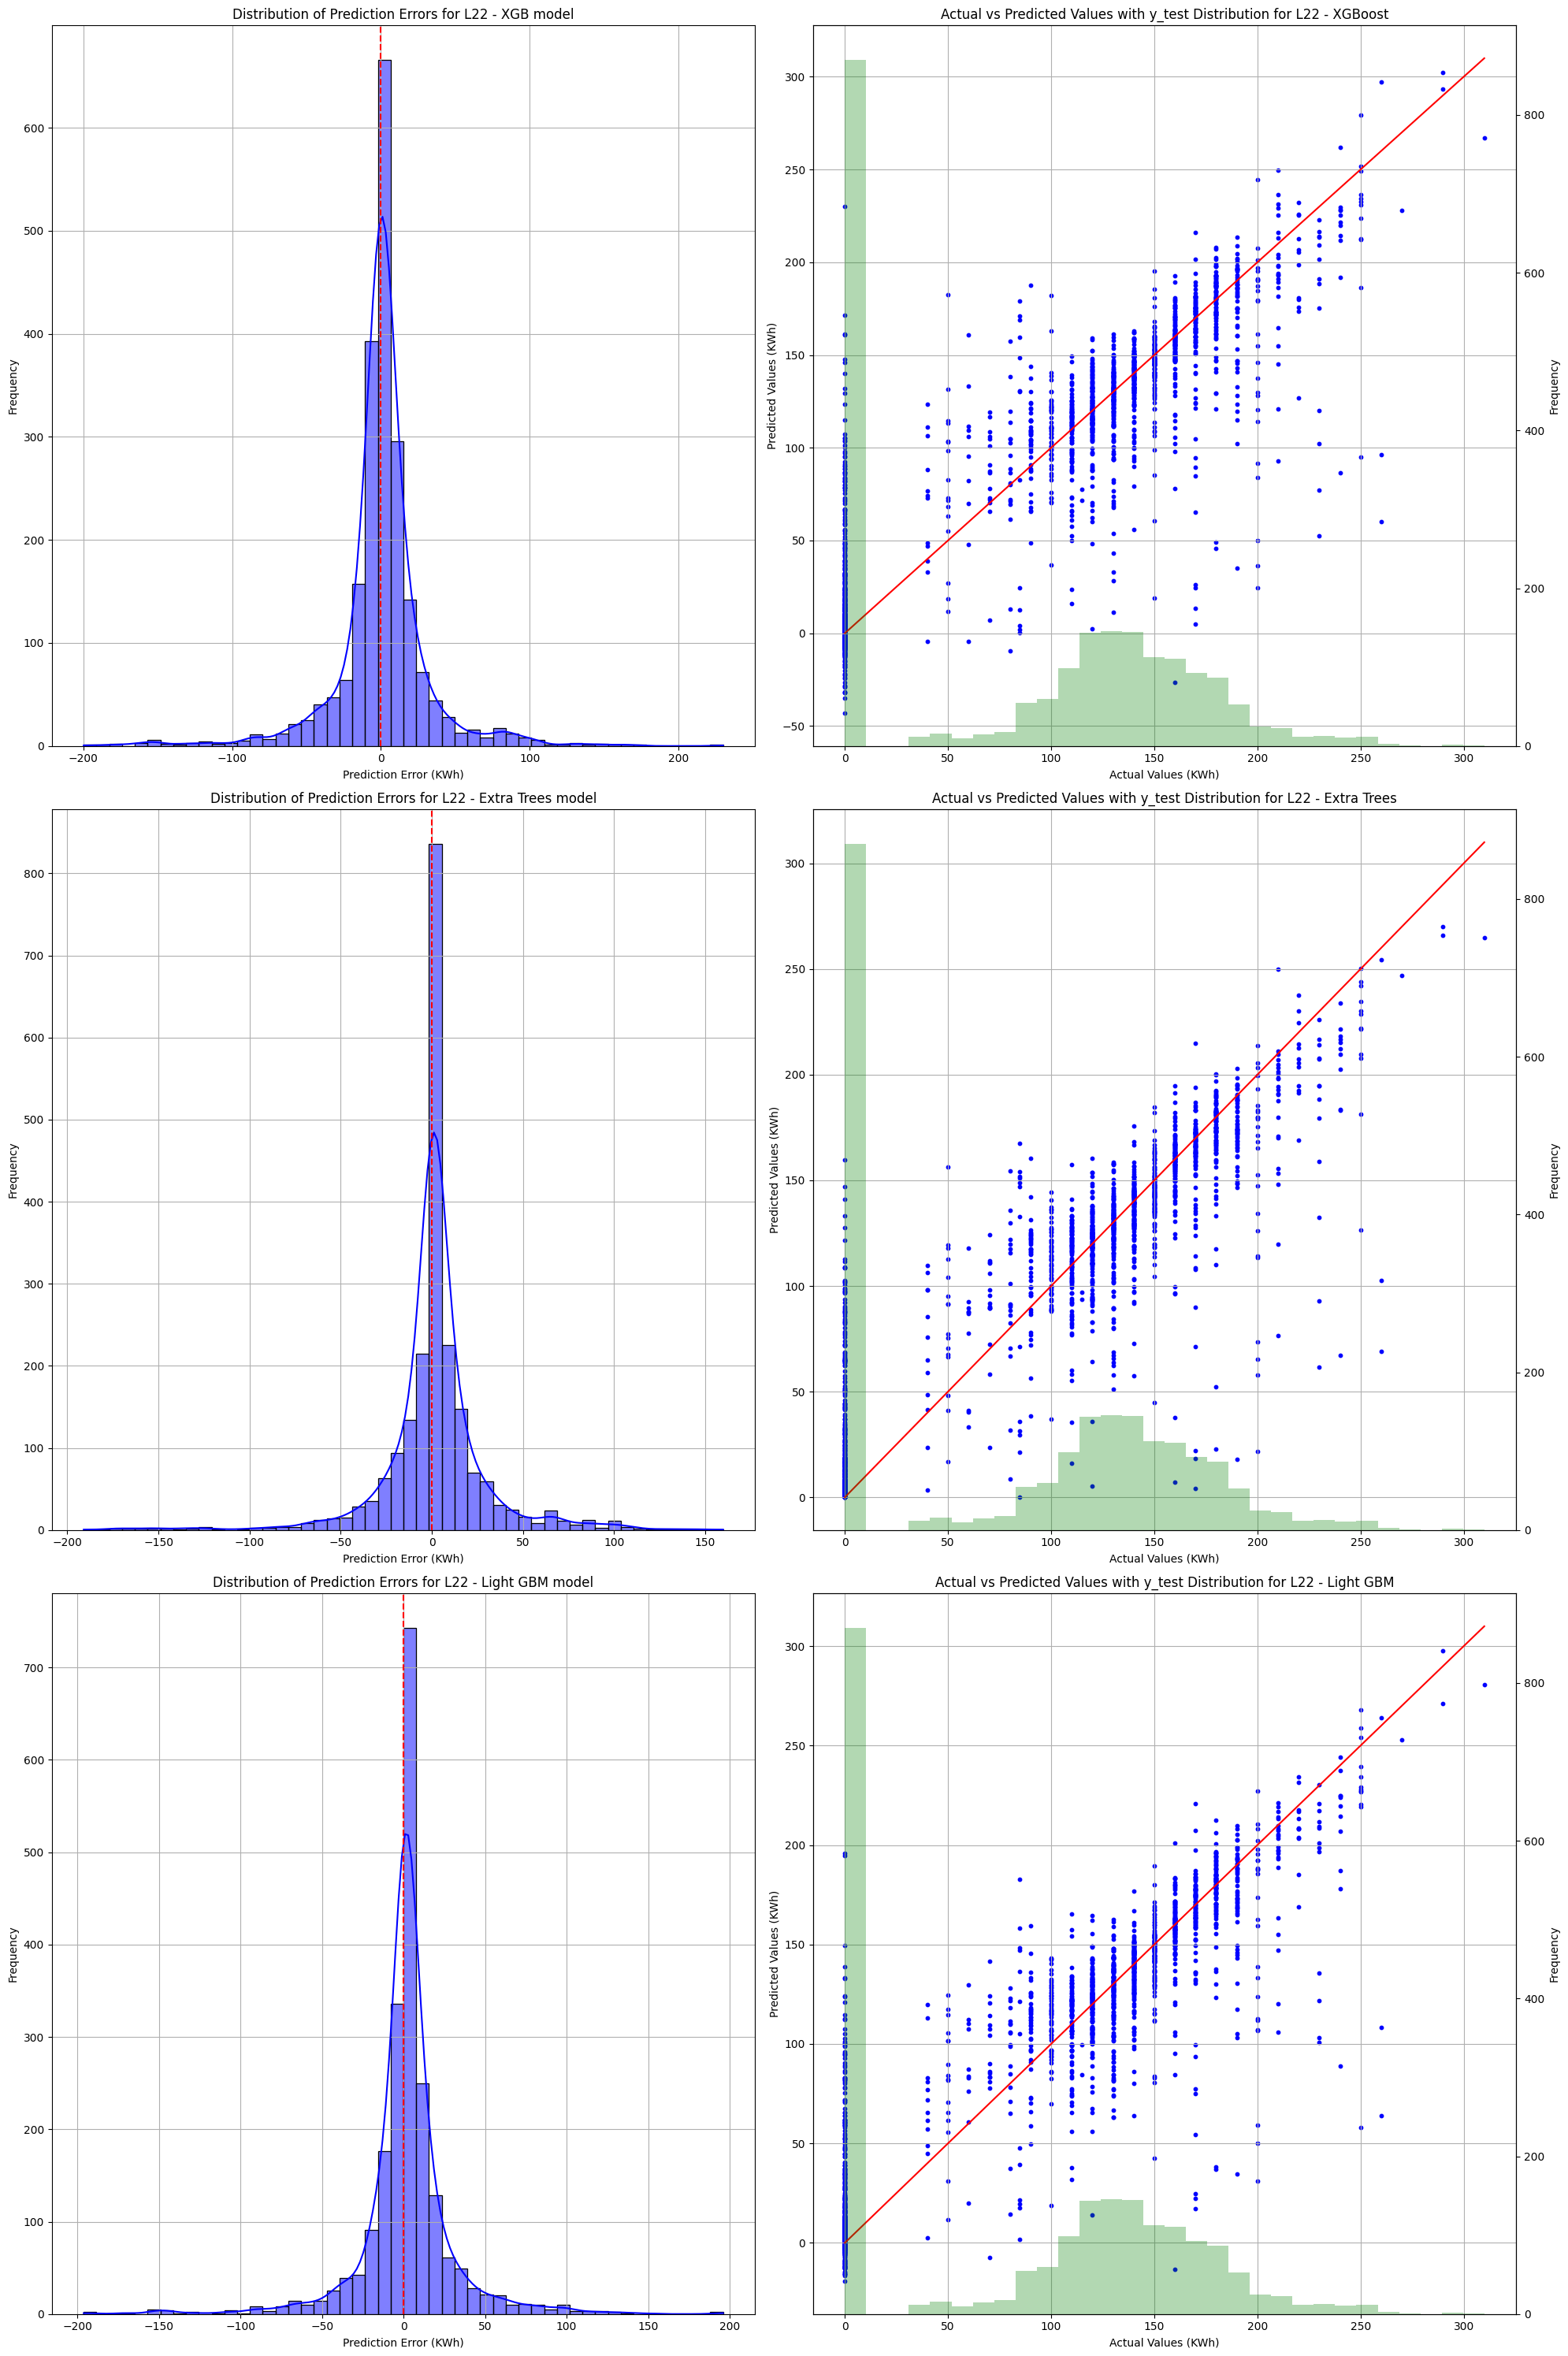

In [14]:
xgb_models=[]
lgb_models=[]
xtr_models=[]

a_ytest=[]
a_xtest=[]
a_xtrain=[]
a_ytrain=[]

a_xgb_mae=[]
a_xgb_mse=[]
a_xgb_mase=[]
a_xgb_smape=[]
a_xgb_r2=[]
a_xgb_execution_time=[]
a_xgb_inference_time=[]
a_xgb_ypred=[]

a_lgb_mae=[]
a_lgb_mse=[]
a_lgb_mase=[]
a_lgb_smape=[]
a_lgb_r2=[]
a_lgb_execution_time=[]
a_lgb_inference_time=[]
a_lgb_ypred=[]

a_xtr_mae=[]
a_xtr_mse=[]
a_xtr_mase=[]
a_xtr_smape=[]
a_xtr_r2=[]
a_xtr_execution_time=[]
a_xtr_inference_time=[]
a_xtr_ypred=[]

for i, dfa in enumerate(all_data):
  print(substations[i])
  print('-----------------------------------')
  df=dfa.copy()
  for c in range(24):
    df['deltae-'+str(c+1)]=df['deltae'].shift(c+1)
    df['temp-'+str(c+1)]=df['temp'].shift(c+1)


  train_size=int(0.8*len(df))

  df['deltae_forecast']=df['deltae'].shift(-1)
  df=df.dropna()

  X = df.drop(columns=['deltae_forecast'], axis=1)
  y = df['deltae_forecast']

  X_train = X[:train_size]
  y_train = y[:train_size]
  X_test = X[train_size:]
  y_test = y[train_size:]

  a_ytest.append(y_test)
  a_xtrain.append(X_train)
  a_xtest.append(X_test)
  a_ytrain.append(y_train)

  start_time=time.time()
  xgb_model = XGBRegressor()
  xgb_model.fit(X_train, y_train)
  end_time=time.time()
  xgb_execution_time=end_time-start_time
  a_xgb_execution_time.append(xgb_execution_time)
  print(f"The XGB training took {xgb_execution_time} seconds to execute")

  start_time=time.time()
  lgb_model = LGBMRegressor()
  lgb_model.fit(X_train, y_train)
  end_time=time.time()
  lgb_execution_time=end_time-start_time
  a_lgb_execution_time.append(lgb_execution_time)
  print(f"The LGB training took {lgb_execution_time} seconds to execute")

  start_time=time.time()
  xtr_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
  xtr_model.fit(X_train, y_train)
  end_time=time.time()
  xtr_execution_time=end_time-start_time
  a_xtr_execution_time.append(xtr_execution_time)
  print(f"The XTR training took {xtr_execution_time} seconds to execute")

  start_time=time.time()
  y_pred = xgb_model.predict(X_test)
  a_xgb_ypred.append(y_pred)
  end_time=time.time()
  xgb_inference_time=end_time-start_time
  a_xgb_inference_time.append(xgb_inference_time)
  print(f"The XGB inference took {xgb_inference_time} seconds to execute")

  start_time=time.time()
  y_pred_xtr = xtr_model.predict(X_test)
  a_xtr_ypred.append(y_pred_xtr)
  end_time=time.time()
  xtr_inference_time=end_time-start_time
  a_xtr_inference_time.append(xtr_inference_time)
  print(f"The XTR inference took {xtr_inference_time} seconds to execute")

  start_time=time.time()
  y_pred_lgb = lgb_model.predict(X_test)
  a_lgb_ypred.append(y_pred_lgb)
  end_time=time.time()
  lgb_inference_time=end_time-start_time
  a_lgb_inference_time.append(lgb_inference_time)
  print(f"The LGB inference took {lgb_inference_time} seconds to execute")

  xgb_mse = mean_squared_error(y_test, y_pred)
  xgb_mse = np.sqrt(xgb_mse)
  xgb_mae = mean_absolute_error(y_test, y_pred)
  xgb_r2 = r2_score(y_test, y_pred)
  xgb_smape=calculate_smape(y_test, y_pred)
  a_xgb_r2.append(xgb_r2)
  a_xgb_mse.append(xgb_mse)
  a_xgb_mae.append(xgb_mae)

  xtr_mse = mean_squared_error(y_test, y_pred_xtr)
  xtr_mse = np.sqrt(xtr_mse)
  xtr_mae = mean_absolute_error(y_test, y_pred_xtr)
  xtr_r2 = r2_score(y_test, y_pred_xtr)
  xtr_smape=calculate_smape(y_test, y_pred_xtr)
  a_xtr_r2.append(xtr_r2)
  a_xtr_mse.append(xtr_mse)
  a_xtr_mae.append(xtr_mae)

  lgb_mse = mean_squared_error(y_test, y_pred_lgb)
  lgb_mse = np.sqrt(lgb_mse)
  lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
  lgb_r2 = r2_score(y_test, y_pred_lgb)
  lgb_smape=calculate_smape(y_test, y_pred_lgb)
  a_lgb_r2.append(lgb_r2)
  a_lgb_mse.append(lgb_mse)
  a_lgb_mae.append(lgb_mae)

  naive_forecast = y_test[:-1].values
  actual_for_naive = y_test[1:].values

  xgb_mase=xgb_mae/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  xtr_mase=xtr_mae/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  lgb_mase=lgb_mae/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  a_xgb_mase.append(xgb_mase)
  a_xtr_mase.append(xtr_mase)
  a_lgb_mase.append(lgb_mase)

  a_xgb_smape.append(xgb_smape)
  a_xtr_smape.append(xtr_smape)
  a_lgb_smape.append(lgb_smape)

  print("XGB Root Mean Squared Error (RMSE):", xgb_mse)
  print("XGB Mean Absolute Error (MAE):", xgb_mae)
  print("XGB Mean Absolute Scaled Error (MASE):", xgb_mase)
  print("XGB Symmetric Mean Absolute Percentage Error (sMAPE):", xgb_smape)
  print("XGB R² Score:", xgb_r2)

  print("XTR Root Mean Squared Error (RMSE):", xtr_mse)
  print("XTR Mean Absolute Error (MAE):", xtr_mae)
  print("XTR Mean Absolute Scaled Error (MASE):", xtr_mase)
  print("XTR Symmetric Mean Absolute Percentage Error (sMAPE):", xtr_smape)
  print("XTR R² Score:", xtr_r2)

  print("LGB Root Mean Squared Error (RMSE):", lgb_mse)
  print("LGB Mean Absolute Error (MAE):", lgb_mae)
  print("LGB Mean Absolute Scaled Error (MASE):", lgb_mase)
  print("LGB Symmetric Mean Absolute Percentage Error (sMAPE):", lgb_smape)
  print("LGB R² Score:", lgb_r2)

  xgb_errors = y_pred - y_test
  xtr_errors = y_pred_xtr - y_test
  lgb_errors = y_pred_lgb - y_test

  plt.figure(figsize=(20, 30))

  plt.subplot(3, 2, 1)
  sns.histplot(xgb_errors, kde=True, bins=50, color='blue')
  plt.xlabel('Prediction Error (KWh)')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Prediction Errors for {substations[i]} - XGB model')
  plt.axvline(x=0, color='red', linestyle='--')
  plt.grid(True)

  plt.subplot(3, 2, 2)
  plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', s=10)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
  plt.xlabel('Actual Values (KWh)')
  plt.ylabel('Predicted Values (KWh)')
  plt.grid(True)
  ax2 = plt.twinx()
  ax2.hist(y_test, bins=30, alpha=0.3, color='green', orientation='vertical')
  #plt.xlabel('Actual Values (y_test)')
  ax2.set_ylabel('Frequency')
  plt.title(f'Actual vs Predicted Values with y_test Distribution for {substations[i]} - XGBoost')

  plt.subplot(3, 2, 3)
  sns.histplot(xtr_errors, kde=True, bins=50, color='blue')
  plt.xlabel('Prediction Error (KWh)')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Prediction Errors for {substations[i]} - Extra Trees model')
  plt.axvline(x=0, color='red', linestyle='--')
  plt.grid(True)

  plt.subplot(3, 2, 4)
  plt.scatter(y_test, y_pred_xtr, color='blue', label='Predicted vs Actual', s=10)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
  plt.xlabel('Actual Values (KWh)')
  plt.ylabel('Predicted Values (KWh)')
  plt.grid(True)
  ax2 = plt.twinx()
  ax2.hist(y_test, bins=30, alpha=0.3, color='green', orientation='vertical')
  #plt.xlabel('Actual Values (y_test)')
  ax2.set_ylabel('Frequency')
  plt.title(f'Actual vs Predicted Values with y_test Distribution for {substations[i]} - Extra Trees')

  plt.subplot(3, 2, 5)
  sns.histplot(lgb_errors, kde=True, bins=50, color='blue')
  plt.xlabel('Prediction Error (KWh)')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Prediction Errors for {substations[i]} - Light GBM model')
  plt.axvline(x=0, color='red', linestyle='--')
  plt.grid(True)

  plt.subplot(3, 2, 6)
  plt.scatter(y_test, y_pred_lgb, color='blue', label='Predicted vs Actual', s=10)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
  plt.xlabel('Actual Values (KWh)')
  plt.ylabel('Predicted Values (KWh)')
  plt.grid(True)
  ax2 = plt.twinx()
  ax2.hist(y_test, bins=30, alpha=0.3, color='green', orientation='vertical')
  #plt.xlabel('Actual Values (y_test)')
  ax2.set_ylabel('Frequency')
  plt.title(f'Actual vs Predicted Values with y_test Distribution for {substations[i]} - Light GBM')

  xgb_models.append(xgb_model)
  lgb_models.append(lgb_model)
  xtr_models.append(xtr_model)

  plt.tight_layout()
  plt.show()

Scatter plots indicate relatively large number of predictions of negative transmitted energy by XGBoost and LGB models (not the case for ExtraTrees models), mostly when actual deltae=0. Replacing negative values with zeros somewhat improves the accuracy of those regression models. Mean Absolute Scaled Error improvements after this transformation range in 0.02-0.03.

In [15]:
print('XGB')
print('-----------------------------------')
for i, y_pred in enumerate(a_xgb_ypred):
  y_pred_corrected = np.where(y_pred < 0, 0, y_pred)
  print(substations[i])
  mae=mean_absolute_error(a_ytest[i], y_pred)
  smape=calculate_smape(a_ytest[i], y_pred)
  smape_corrected=calculate_smape(a_ytest[i], y_pred_corrected)
  print('MAE: '+ str(mae))
  mae_corrected=mean_absolute_error(a_ytest[i], y_pred_corrected)
  print('MAE with corrected data: '+ str(mae_corrected))
  print('SMAPE: '+ str(smape))
  print('SMAPE with corrected data: '+ str(smape_corrected))
  naive_forecast = a_ytest[i][:-1].values
  actual_for_naive = a_ytest[i][1:].values
  mase=mae/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  mase_corrected=mae_corrected/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  print('MASE: '+ str(mase))
  print('MASE with corrected data: '+ str(mase_corrected))

print('LGB')
print('-----------------------------------')
for i, y_pred in enumerate(a_lgb_ypred):
  y_pred_corrected = np.where(y_pred < 0, 0, y_pred)
  print(substations[i])
  mae=mean_absolute_error(a_ytest[i], y_pred)
  smape=calculate_smape(a_ytest[i], y_pred)
  smape_corrected=calculate_smape(a_ytest[i], y_pred_corrected)
  print('MAE: '+ str(mae))
  mae_corrected=mean_absolute_error(a_ytest[i], y_pred_corrected)
  print('MAE with corrected data: '+ str(mae_corrected))
  print('SMAPE: '+ str(smape))
  print('SMAPE with corrected data: '+ str(smape_corrected))
  naive_forecast = a_ytest[i][:-1].values
  actual_for_naive = a_ytest[i][1:].values
  mase=mae/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  mase_corrected=mae_corrected/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  print('MASE: '+ str(mase))
  print('MASE with corrected data: '+ str(mase_corrected))

XGB
-----------------------------------
L4
MAE: 33.51321533326507
MAE with corrected data: 32.364077703092356
SMAPE: 82.44588150212881
SMAPE with corrected data: 52.43594443687542
MASE: 0.6069216369481963
MASE with corrected data: 0.5861108467972757
L8
MAE: 15.4542868332479
MAE with corrected data: 14.68847209578518
SMAPE: 87.3800214861907
SMAPE with corrected data: 52.12420753270233
MASE: 0.5217384715206582
MASE with corrected data: 0.49588447936281865
L12
MAE: 15.903101151569505
MAE with corrected data: 15.183114283661375
SMAPE: 87.71304536189288
SMAPE with corrected data: 59.0618825711952
MASE: 0.5409012610145923
MASE with corrected data: 0.5164128419915505
L17
MAE: 31.812961146226666
MAE with corrected data: 30.690107460992134
SMAPE: 85.68118407838435
SMAPE with corrected data: 59.029324000649765
MASE: 0.5709311299536791
MASE with corrected data: 0.550779842547991
L22
MAE: 17.723804921938125
MAE with corrected data: 16.978398578478455
SMAPE: 91.29570534435638
SMAPE with corrected d

Additional potential for the improvement of the forecasting model is the finding from the analysis of the scatter plots that models make it difficult to predict if the heating is turned on (deltae=0) or not. To address this, we introduced the approach of separating the problems of forecasting on the plant level and substations level, namely by using a two-stage model where the first stage predicts the occurrence of an event (zero or non-zero) and the second stage predicts the magnitude for non-zero events.

For intermittent time series like it is the case with heat demand in DHS, from the automation point of view, we can distinguish between two sets of decisions that guide the data. First one is control of the main plant, which is basically a binary decision, while the second one is related to determining the temperature of heating fluid in the supply line of the secondary flow. While the first one is manual, the second one is automatic and it is currently made by using the control curve. Since those two control decisions are fully independent, we can adopt the approach to separating the forecasting problem. First one is related to forecasting the decision of the operator and second one - forecasting the actual heat demand at the substation level. That implies the use of combined classification and regression model.

Such approach has brought significant improvements. Gradient boosting classifier without hyperparameter optimization was used for predicting if the heating plant is turned on in next time point, with accuracy of 0.96, for all substations' data. Mean Absolute Scaled Error improvements after this transformation range in 0.04-0.11, where larger improvements are associated for the larger datasets.

In [16]:
print('XGB')
print('-----------------------------------')
for i, y_pred in enumerate(a_xgb_ypred):
  print(substations[i])
  y_pred = np.where(y_pred < 0, 0, y_pred)

  y_train= a_ytrain[i].apply(lambda x: 1 if x > 0 else 0)
  y_test= a_ytest[i].apply(lambda x: 1 if x > 0 else 0)
  X_train = a_xtrain[i]
  X_test = a_xtest[i]

  # Gradient boosting classification model trained and tested on accuracy
  gbc=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  gbc.fit(X_train, y_train)
  y_pred_c = gbc.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred_c)
  print(f"GB Accuracy: {accuracy:.2f}")
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred_c))

  # Transformation
  y_pred_transformed = np.where(y_pred_c == 0, 0, y_pred)


  mae=mean_absolute_error(a_ytest[i], y_pred)
  smape=calculate_smape(a_ytest[i], y_pred)
  smape_corrected=calculate_smape(a_ytest[i], y_pred_transformed)
  print('MAE: '+ str(mae))
  mae_corrected=mean_absolute_error(a_ytest[i], y_pred_transformed)
  print('MAE with corrected data: '+ str(mae_corrected))
  print('SMAPE: '+ str(smape))
  print('SMAPE with corrected data: '+ str(smape_corrected))
  naive_forecast = a_ytest[i][:-1].values
  actual_for_naive = a_ytest[i][1:].values
  mase=mae/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  mase_corrected=mae_corrected/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  print('MASE: '+ str(mase))
  print('MASE with corrected data: '+ str(mase_corrected))


XGB
-----------------------------------
L4
GB Accuracy: 0.96
Confusion Matrix:
[[1020   54]
 [  73 1872]]
MAE: 32.364077703092356
MAE with corrected data: 27.58462504980168
SMAPE: 52.43594443687542
SMAPE with corrected data: 16.851379050619666
MASE: 0.5861108467972757
MASE with corrected data: 0.49955534326812606
L8
GB Accuracy: 0.96
Confusion Matrix:
[[ 792   36]
 [  50 1272]]
MAE: 14.68847209578518
MAE with corrected data: 13.376517052226253
SMAPE: 52.12420753270233
SMAPE with corrected data: 15.798530544983109
MASE: 0.49588447936281865
MASE with corrected data: 0.4515927286973887
L12
GB Accuracy: 0.96
Confusion Matrix:
[[ 796   30]
 [  60 1264]]
MAE: 15.183114283661375
MAE with corrected data: 14.295317866833086
SMAPE: 59.0618825711952
SMAPE with corrected data: 16.573661355296224
MASE: 0.5164128419915505
MASE with corrected data: 0.48621683199262866
L17
GB Accuracy: 0.96
Confusion Matrix:
[[1259   67]
 [  93 2183]]
MAE: 30.690107460992134
MAE with corrected data: 27.746933497621534

Methodology also aim to show another advantage of traditional ML methods, in specific, of tree-based ensembles over the Deep Learning approaches - explainability. Gradient boosting algorithms are inherently explainable as they provide out-of-the-box analysis of the feature importance in the aspects of gain, cover and frequency.

Gain measures the improvement in accuracy (or reduction in loss) that a feature provides when it is used in a split. Gain is a direct measure of a feature's contribution to the accuracy of the model. If a feature consistently results in large gains when used in splits, it means that this feature is very effective in making accurate predictions.

Cover measures the relative quantity of observations (or data points) that are affected by a feature when it is used in a split. Higher cover indicates that the feature is used in splits that affect a large portion of the dataset. If a feature has high cover, it means that it was consistently found as significant for all or large number of predictions.

Finally, frequency (or weight) measures the number of times a feature is used in all the trees of the model. Higher frequency indicates that the feature is frequently used to make splits in the model. It shows how often the feature is chosen to make a decision. If a feature has a high frequency, it suggests that it is a key decision point in the model.

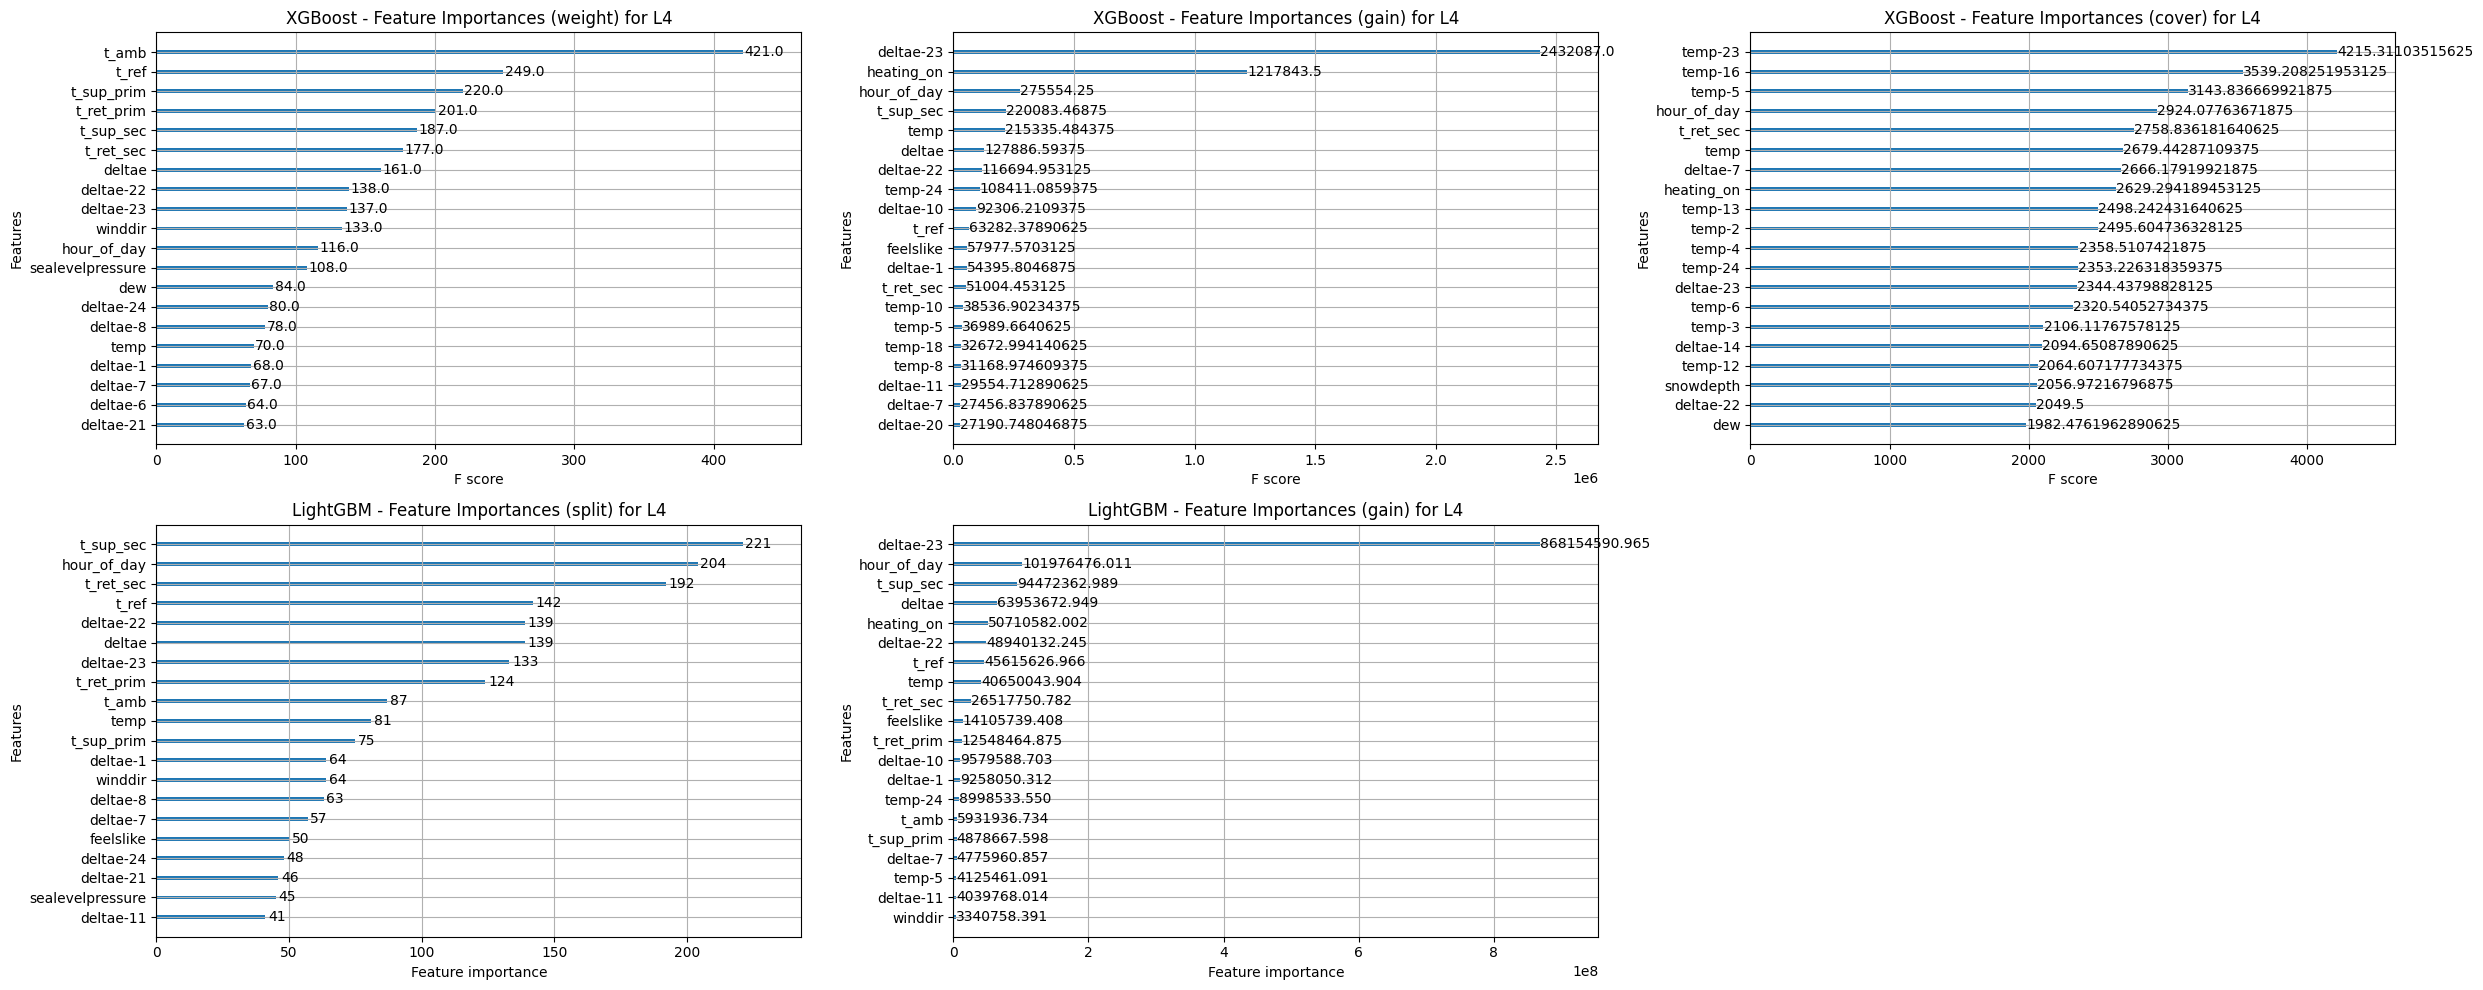

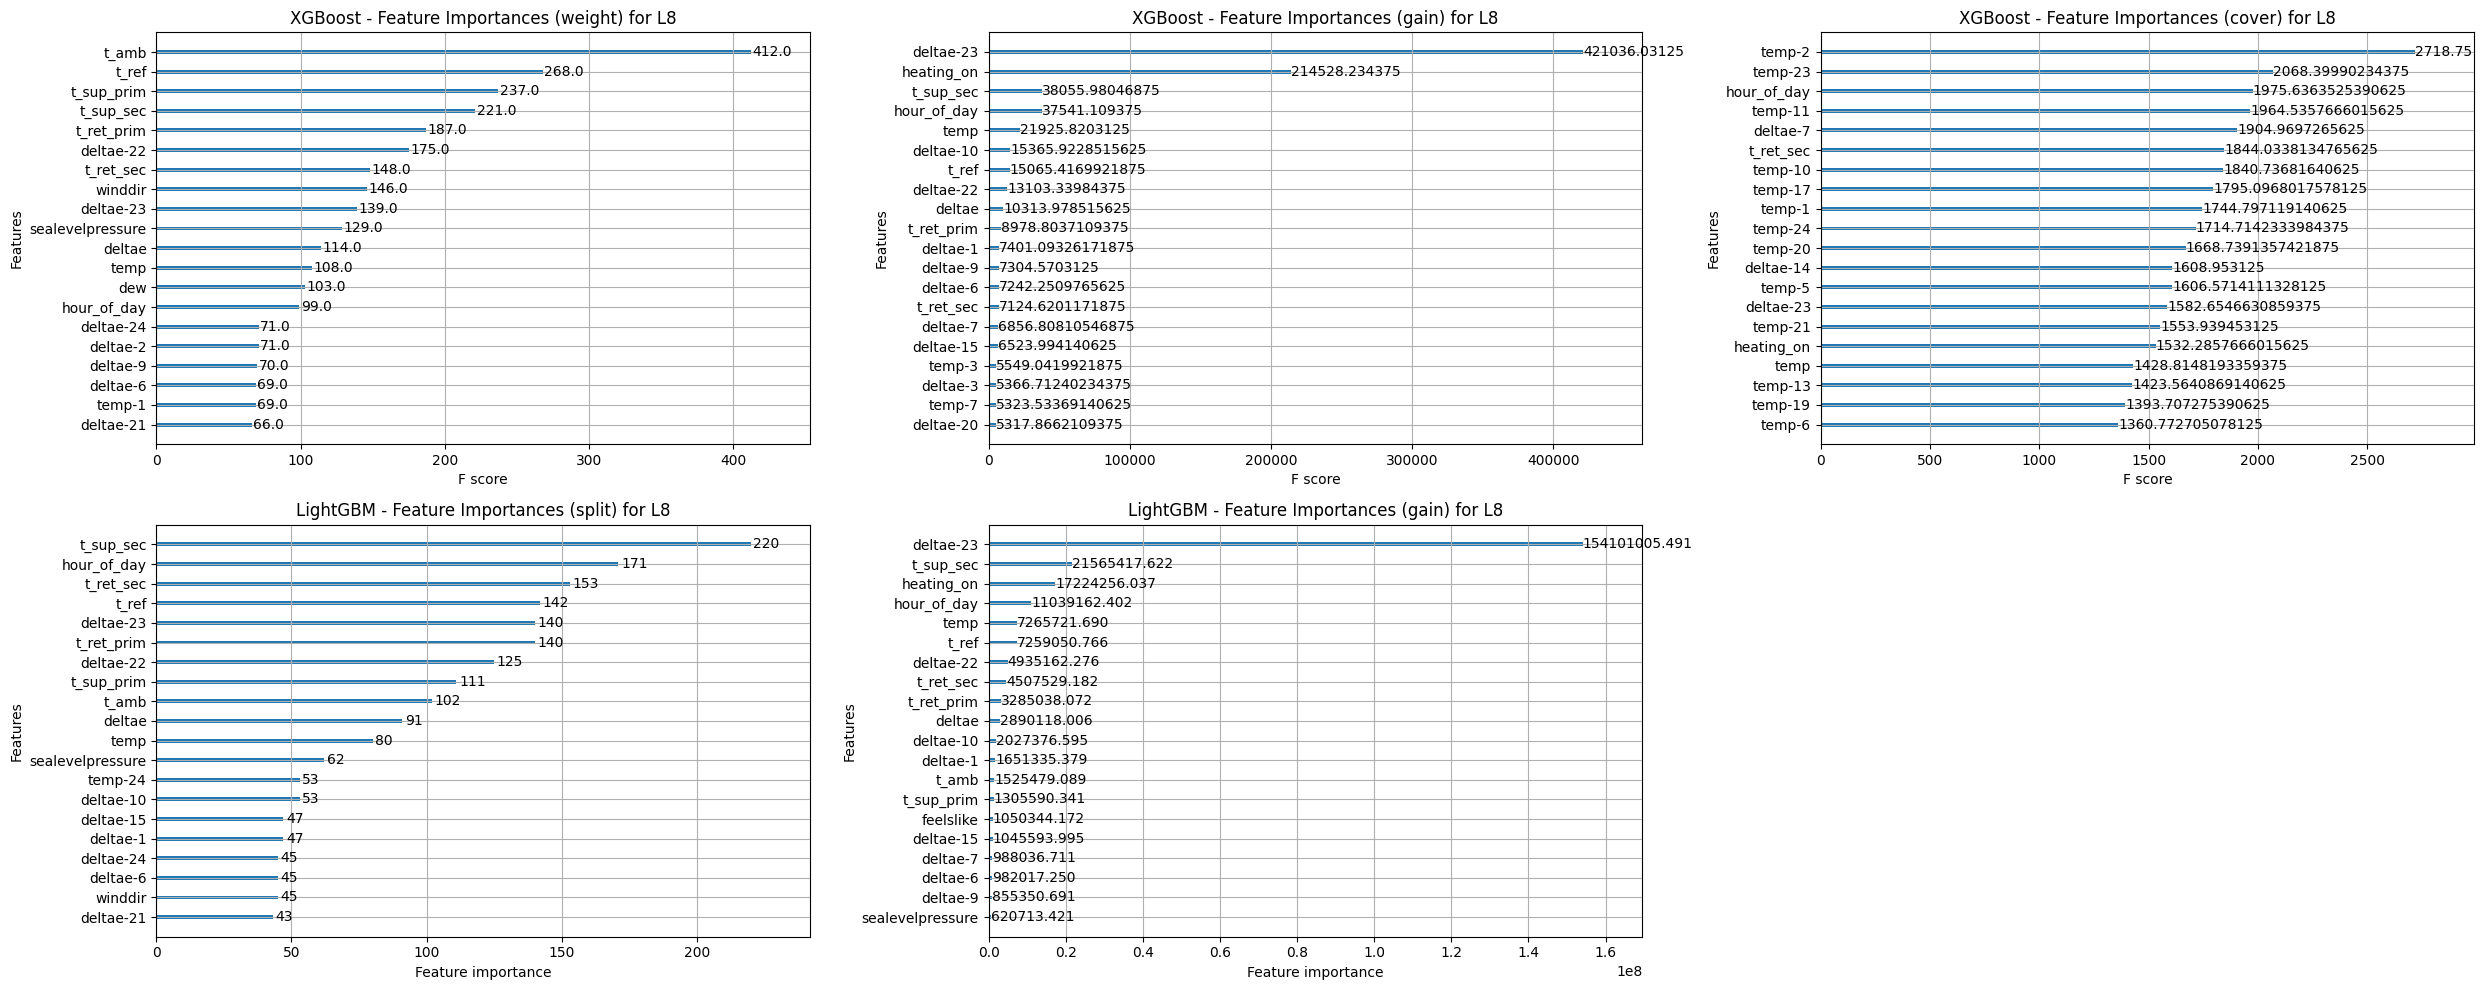

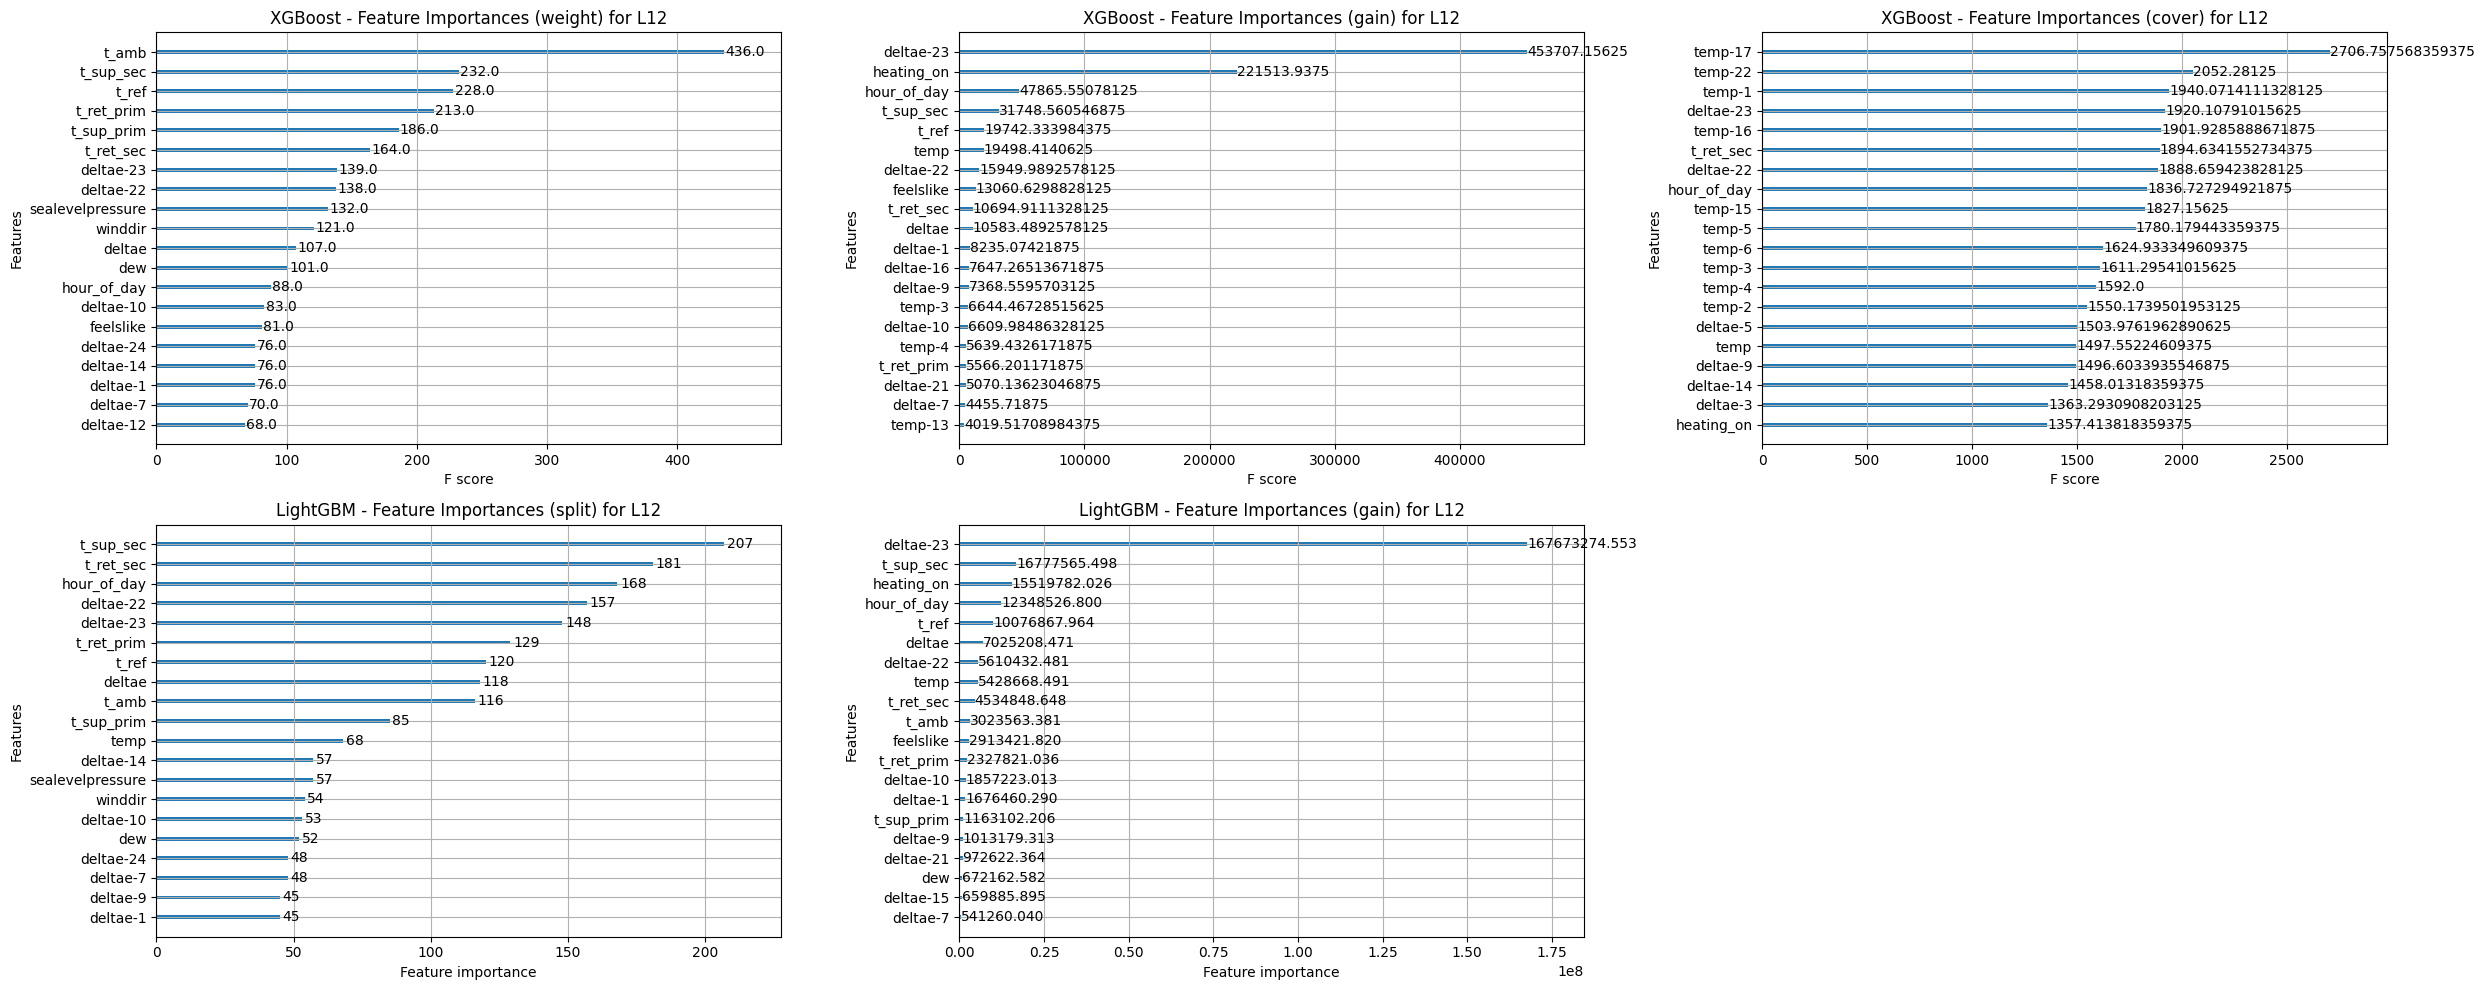

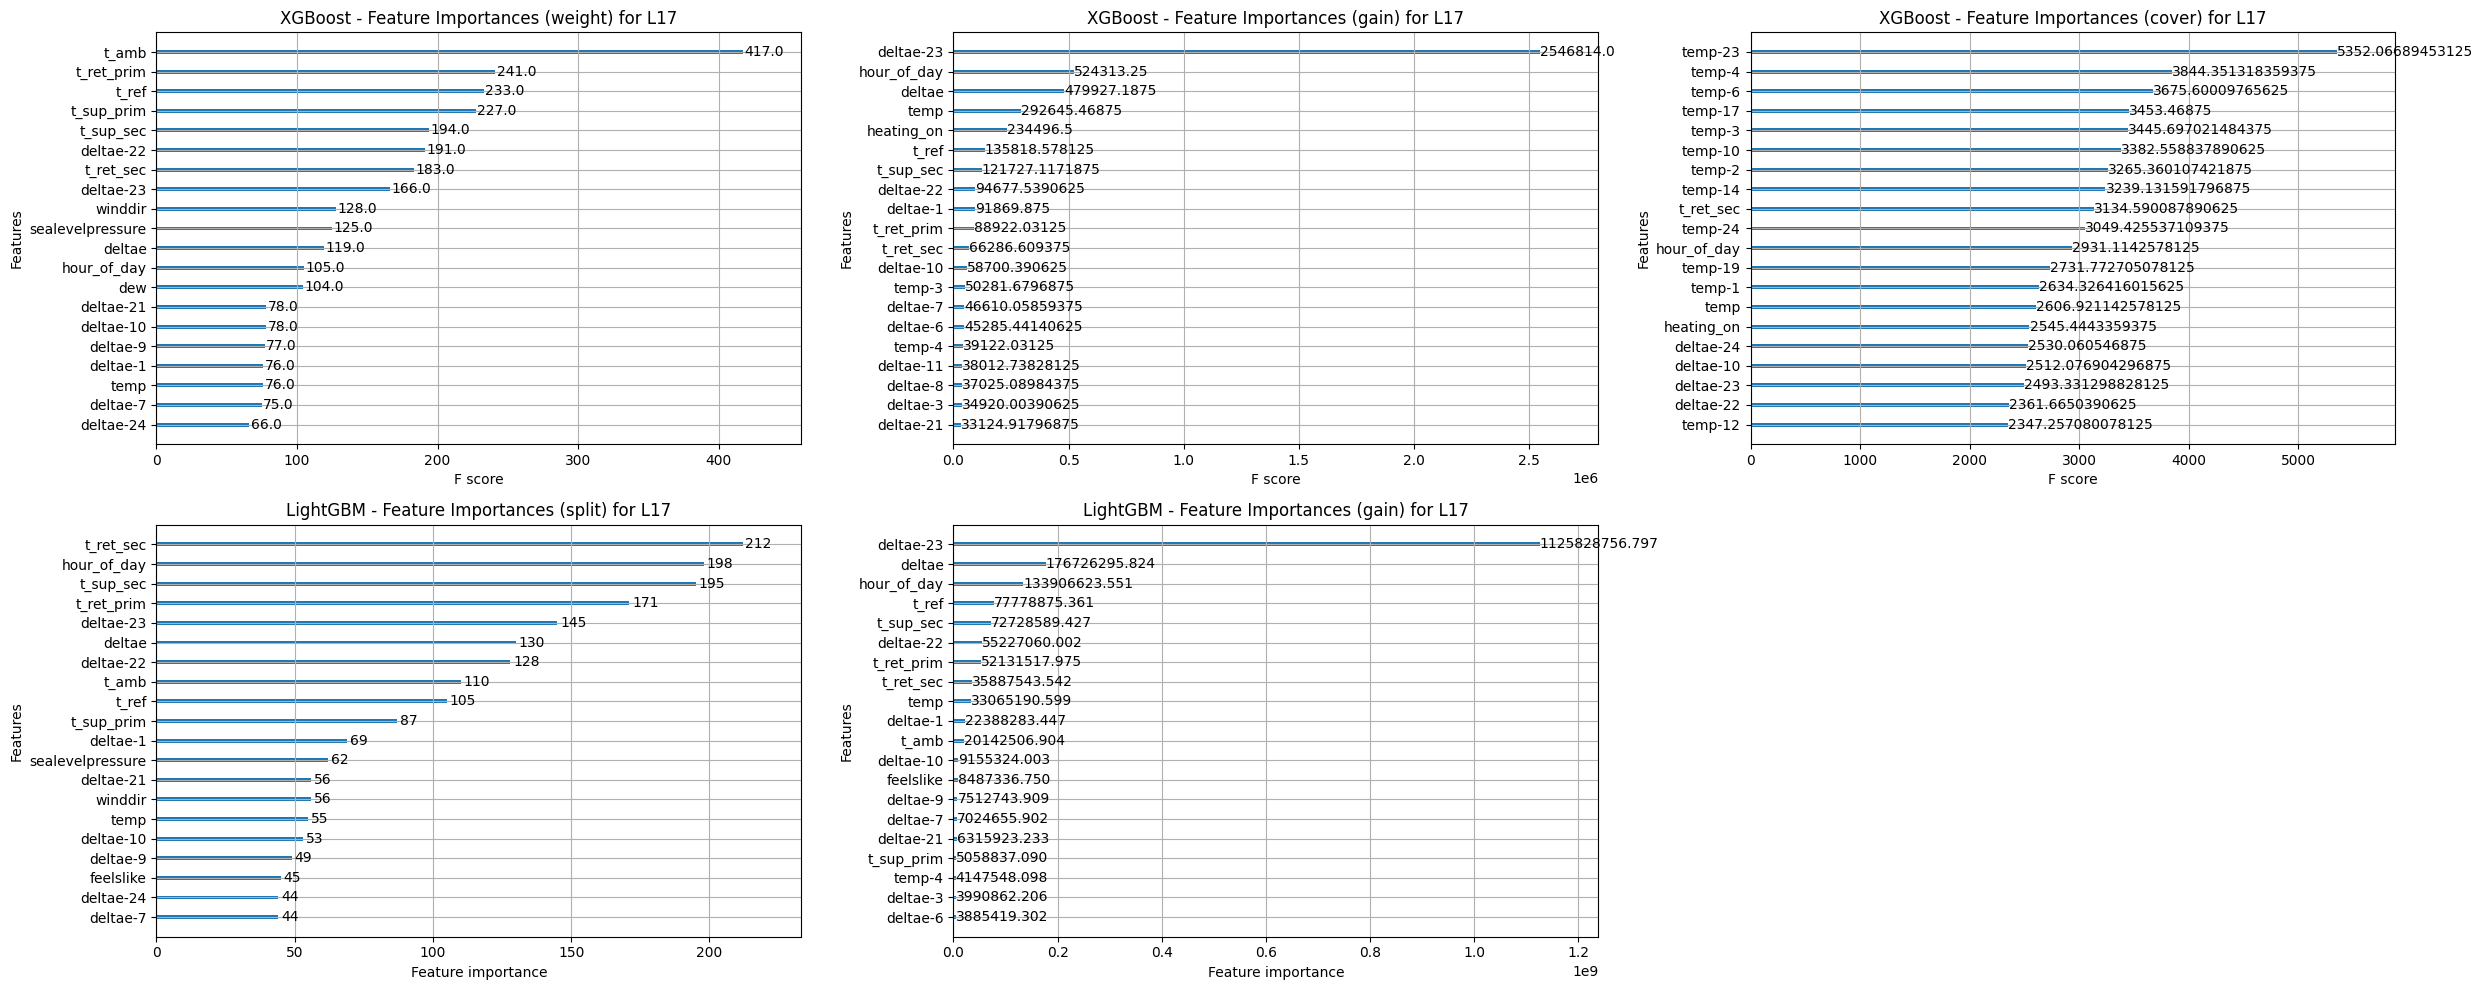

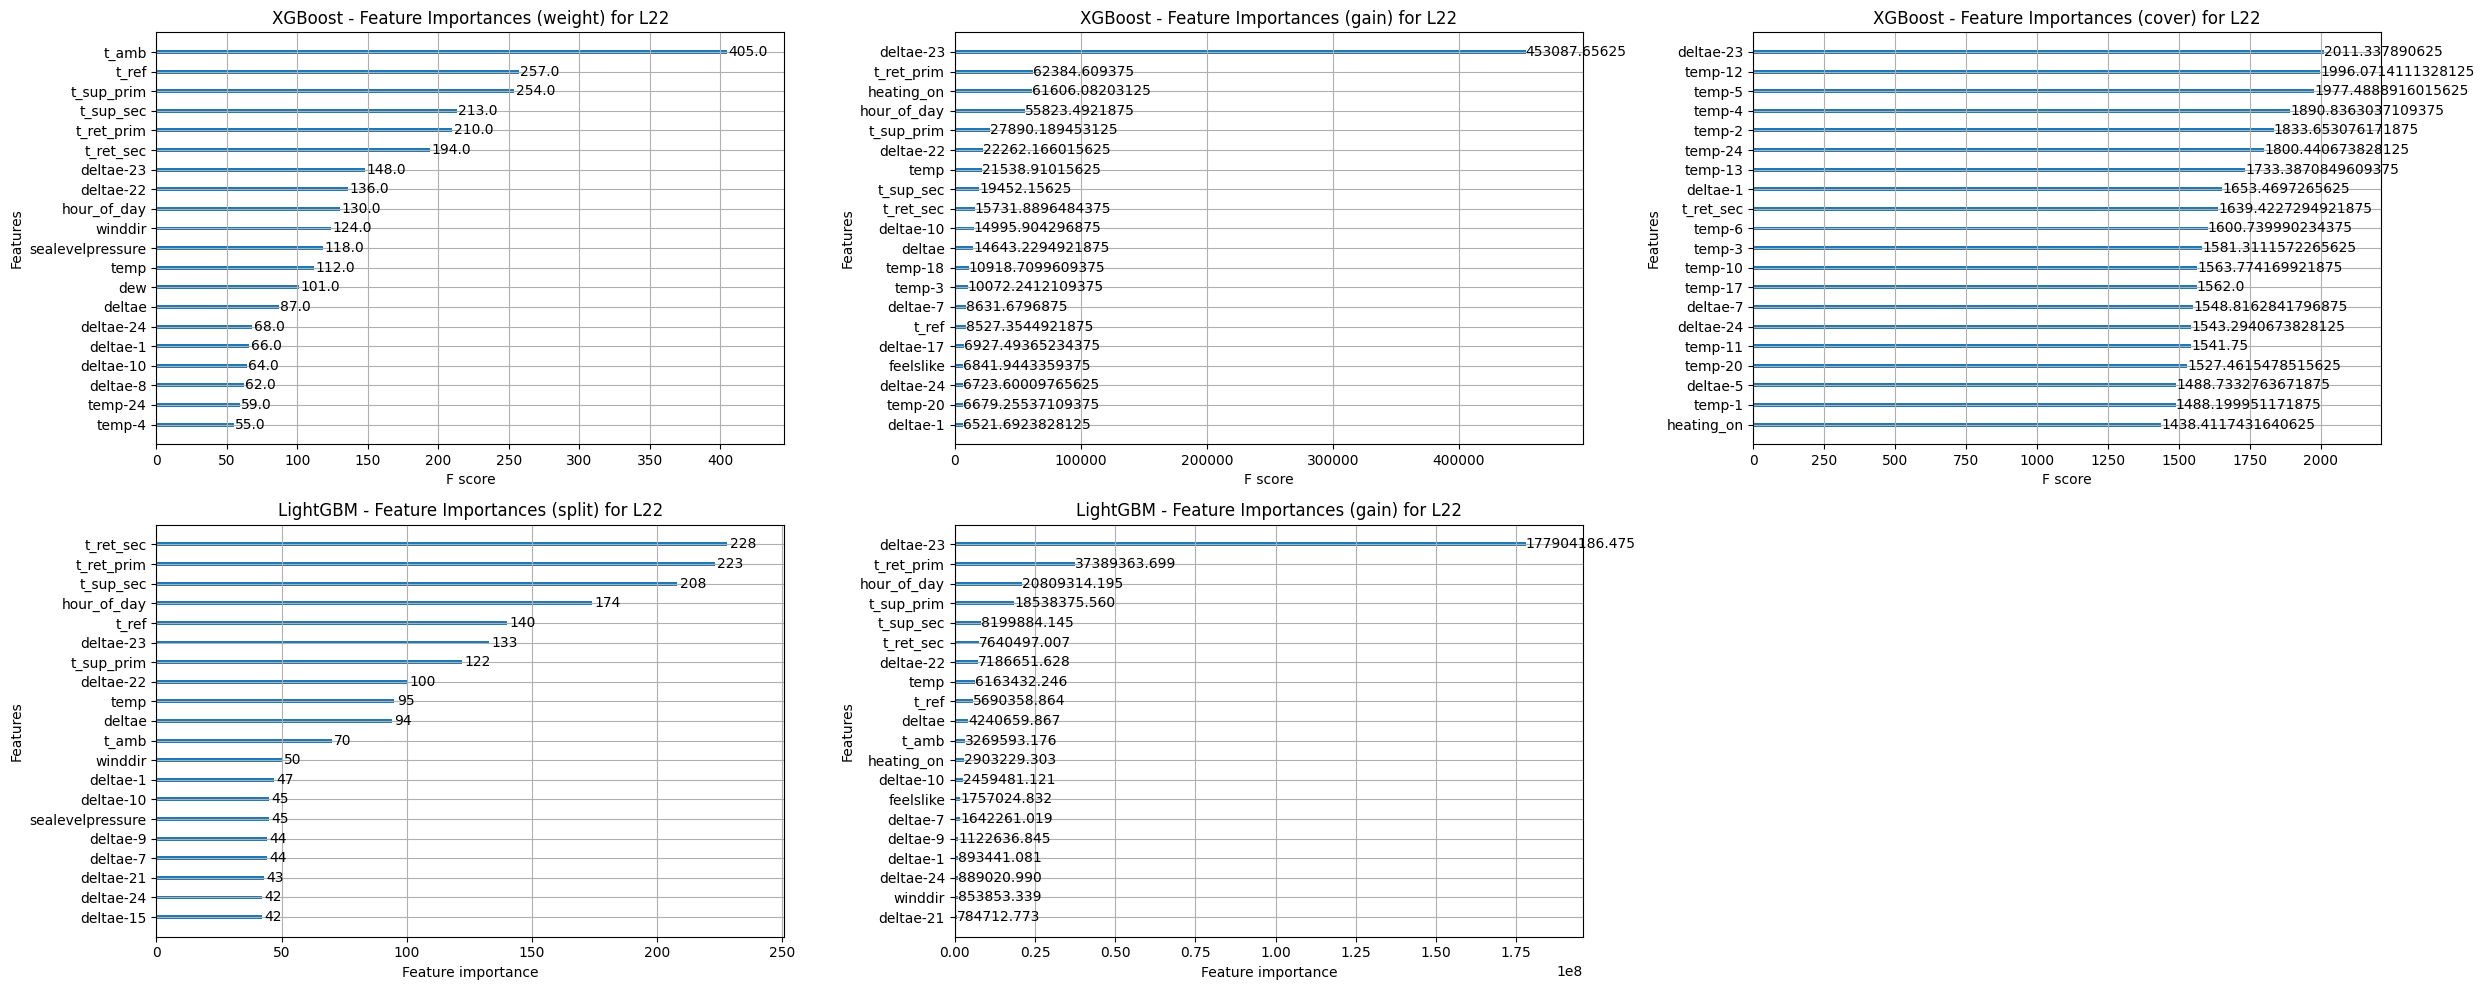

In [17]:
for i, dfa in enumerate(all_data):
  xm=xgb_models[i]
  lm=lgb_models[i]
  fig, axs = plt.subplots(2, 3, figsize=(25, 10))

  xgb.plot_importance(xm, max_num_features=20, ax=axs[0,0], importance_type='weight')
  axs[0,0].set_title(f"XGBoost - Feature Importances (weight) for {substations[i]}")
  xgb.plot_importance(xm, max_num_features=20, ax=axs[0,1], importance_type='gain')
  axs[0,1].set_title(f"XGBoost - Feature Importances (gain) for {substations[i]}")
  xgb.plot_importance(xm, max_num_features=20, ax=axs[0,2], importance_type='cover')
  axs[0,2].set_title(f"XGBoost - Feature Importances (cover) for {substations[i]}")

  lgb.plot_importance(lm, max_num_features=20, importance_type='split', ax=axs[1,0])
  axs[1,0].set_title(f"LightGBM - Feature Importances (split) for {substations[i]}")
  lgb.plot_importance(lm, max_num_features=20, importance_type='gain', ax=axs[1,1])
  axs[1,1].set_title(f"LightGBM - Feature Importances (gain) for {substations[i]}")

  fig.delaxes(axs[1,2])
  plt.tight_layout()
  plt.show()

### Implementation of Stacked LSTM model

Long Short-Term Memory (LSTM) (Hochreiter and Schmidhuber, 1997) networks are a special kind of Recurrent Neural Network (RNN) (Rumelhart et al, 1985), specifically designed to learn from sequences of data and remember long-term dependencies in the data. They are widely used for sequence prediction problems, such as time series forecasting, natural language processing, and speech recognition. LSTMs are design to address the specific limitation of traditional RNNs related to struggling to capture long-term dependencies in a sequence due to the vanishing gradient problem.

LSTMs maintain a hidden state vector and a cell state vector across time steps, which help them store and manage long-term dependencies in the data. An LSTM unit consists of three main components: forget gate which "decides" what information should be thrown away or kept, input gate that updates the cell state, and output gate which "decides" what the next hidden state should be. In each time step, the LSTM cell takes three pieces of information: the current input data, the previous hidden state, and the previous cell state. Based on these inputs, it produces a new hidden state and a new cell state, which are passed to the next time step (see Figure below).

In [7]:
filename='https://www.researchgate.net/profile/Gonzalo-Napoles/publication/340493274/figure/fig1/AS:877838903308288@1586304512343/Architecture-of-a-typical-vanilla-LSTM-block.png'

display(Image(url=filename, width=900))

Source: (Van Houdt et al, 2020)

LSTM networks take structured data transposed to supervised regression problem format by introducing certain number of datapoints from the past in one instance, namely lagged timepoints. 24 timepoints in the past will be considered in each data instance as a short memory. The experiment uses configuration of LSTM network that has been already proven performant in the previous works (Zdravković et al, 2022), so no additional optimization has been done in scope of this research. This configuration is characterized by two stacked hidden layers, each with 100 LSTM units, followed by the dropout regularization layers with the rate of 40% each and one fully connected layer with 50 units. Each of the LSTM layers use hyperbolic tangent (tanh) activation function, while dense layer is using Rectified Linear Unit (ReLU) as an activation. MAE is used as a loss function as well as the adaptive learning rate optimization (Adam) algorithm. The configuration is trained in 50 epochs, with a batch size of 24. 20% of data from the training set is used for validation.

L4
-----------------------------------
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


406/406 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1853 - val_loss: 0.1170
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1129 - val_loss: 0.0901
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0931 - val_loss: 0.0758
Epoch 4/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0791 - val_loss: 0.0727
Epoch 5/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0737 - val_loss: 0.0577
Epoch 6/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0692 - val_loss: 0.0560
Epoch 7/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0660 - val_loss: 0.0558
Epoch 8/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0640 - val_loss: 0.0558
Epoch 9/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0639 - val_loss: 0.0515
Epoch 10/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0628 - val_loss: 0.0566
Epoch 11/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0621 - val_loss: 0.0513
Epoch 12/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.

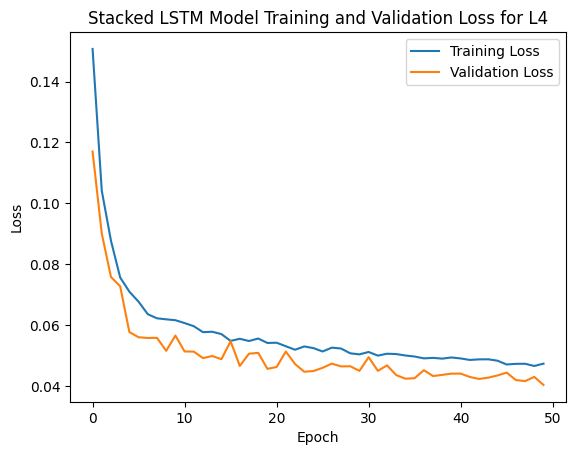

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
The LSTM inference took 0.6991076469421387 seconds to execute
GB Accuracy: 0.96
Root Mean Squared Error (RMSE): 68.74419009541825
Mean Absolute Error (MAE): 30.439666748046875
Mean Absolute Scaled Error (MASE): 0.5531505399465925
Symmetric Mean Absolute Percentage Error (sMAPE): 19.40772980451584
R² Score: 0.7958458065986633


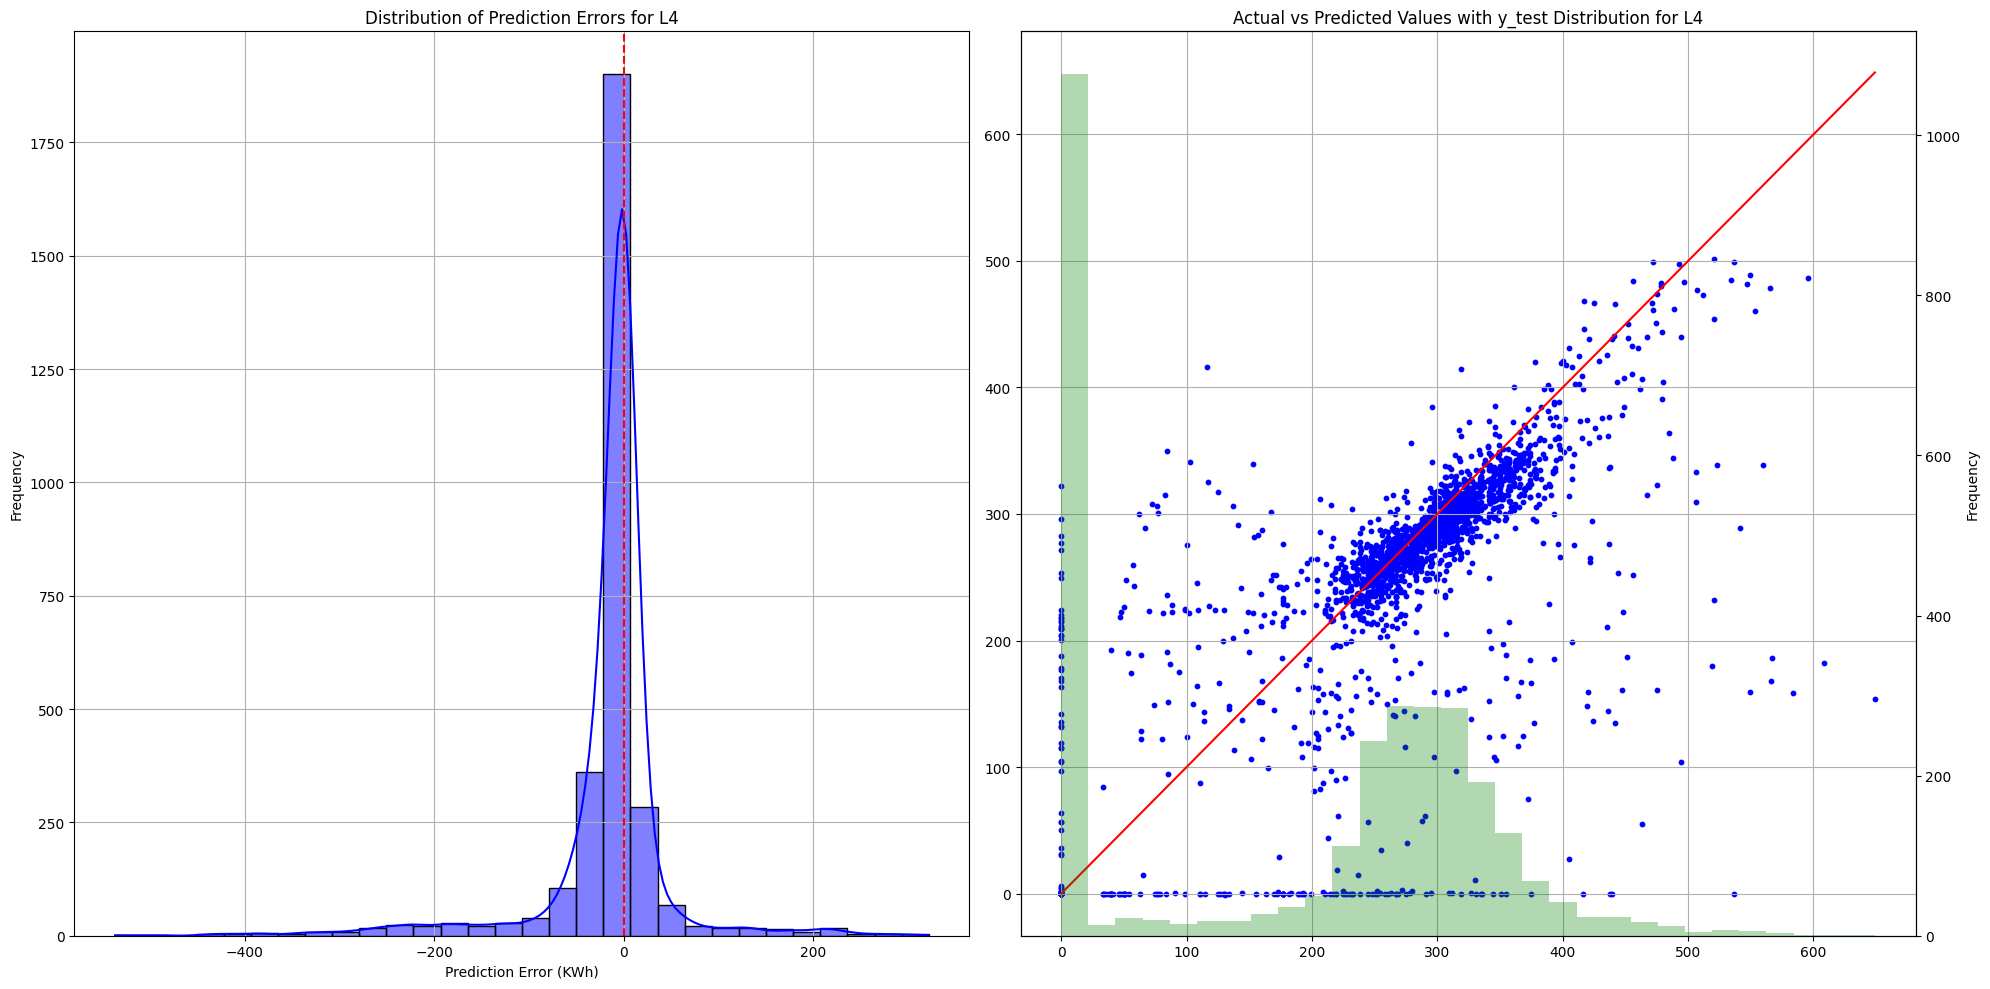

L8
-----------------------------------
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1538 - val_loss: 0.0986
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0969 - val_loss: 0.0988
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0851 - val_loss: 0.0845
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0785 - val_loss: 0.0809
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0705 - val_loss: 0.0669
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0637 - val_loss: 0.0567
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0585 - val_loss: 0.0563
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0569 - val_loss: 0.0550
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0545 - val_loss: 0.0520
Epoch 10/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0491 - val_loss: 0.0481
Epoch 11/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0499 - val_loss: 0.0482
Epoch 12/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 

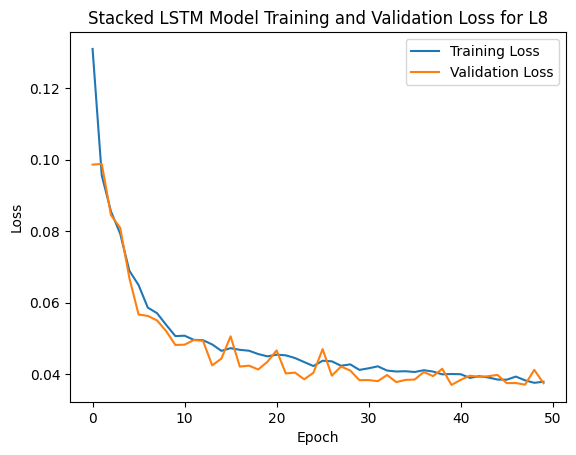

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
The LSTM inference took 0.6906943321228027 seconds to execute
GB Accuracy: 0.96
Root Mean Squared Error (RMSE): 31.28186266258173
Mean Absolute Error (MAE): 14.268077850341797
Mean Absolute Scaled Error (MASE): 0.4826307730859566
Symmetric Mean Absolute Percentage Error (sMAPE): 17.76321828365326
R² Score: 0.8313331604003906


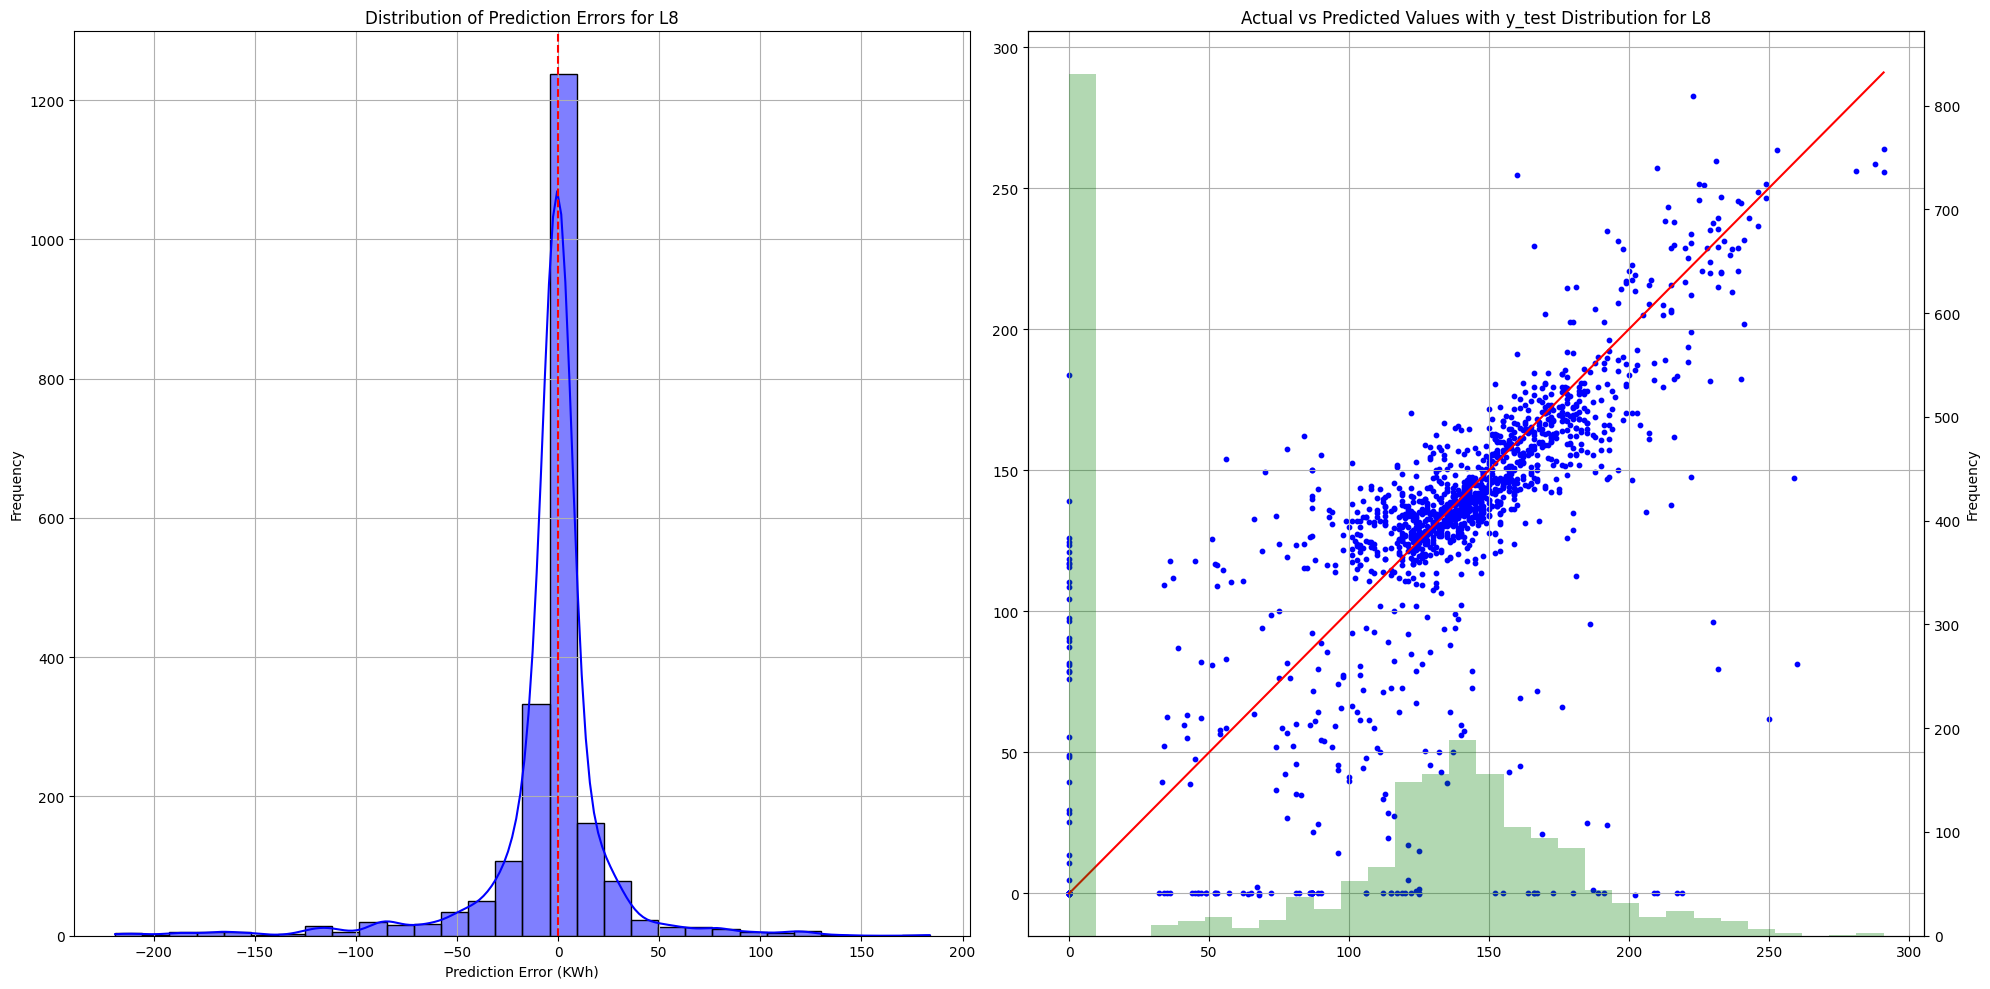

L12
-----------------------------------
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1776 - val_loss: 0.1206
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1124 - val_loss: 0.0996
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0948 - val_loss: 0.0797
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0827 - val_loss: 0.0707
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0738 - val_loss: 0.0610
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0662 - val_loss: 0.0555
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0616 - val_loss: 0.0508
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0582 - val_loss: 0.0505
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0580 - val_loss: 0.0488
Epoch 10/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0549 - val_loss: 0.0469
Epoch 11/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0537 - val_loss: 0.0442
Epoch 12/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 

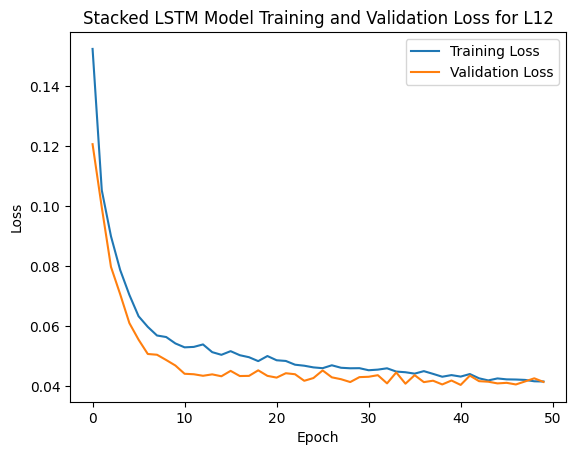

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
The LSTM inference took 0.6949572563171387 seconds to execute
GB Accuracy: 0.96
Root Mean Squared Error (RMSE): 34.57032750705889
Mean Absolute Error (MAE): 16.073169708251953
Mean Absolute Scaled Error (MASE): 0.5434355307888569
Symmetric Mean Absolute Percentage Error (sMAPE): 21.334263682365417
R² Score: 0.7884957790374756


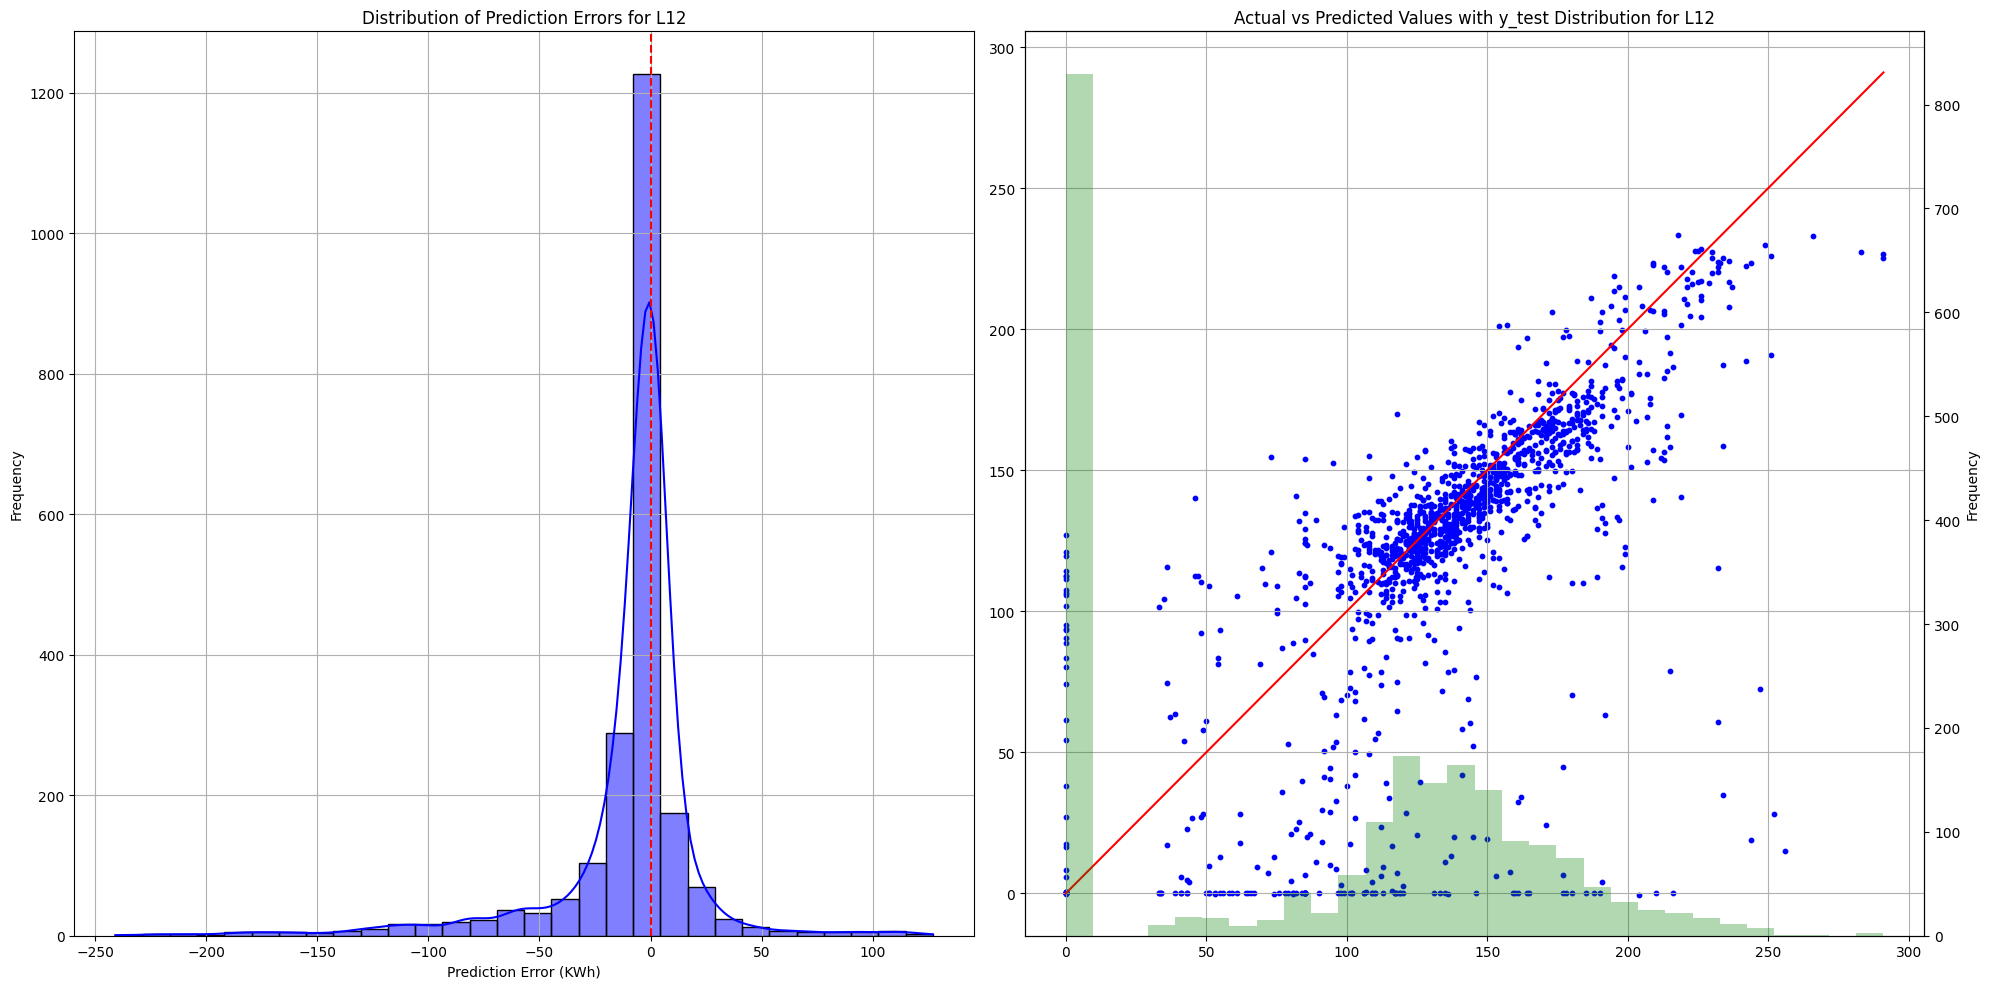

L17
-----------------------------------
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


483/483 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1846 - val_loss: 0.1042
Epoch 2/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1244 - val_loss: 0.0831
Epoch 3/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1014 - val_loss: 0.0758
Epoch 4/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0867 - val_loss: 0.0730
Epoch 5/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0819 - val_loss: 0.0637
Epoch 6/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0738 - val_loss: 0.0589
Epoch 7/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0713 - val_loss: 0.0630
Epoch 8/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0698 - val_loss: 0.0592
Epoch 9/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0652 - val_loss: 0.0546
Epoch 10/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0646 - val_loss: 0.0539
Epoch 11/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0635 - val_loss: 0.0532
Epoch 12/50
483/483 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss:

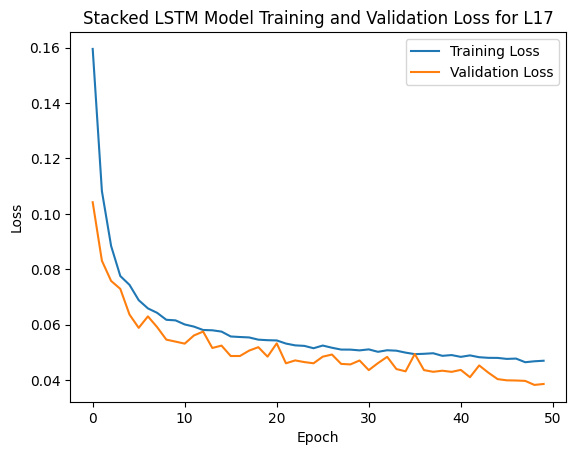

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
The LSTM inference took 0.7051525115966797 seconds to execute
GB Accuracy: 0.96
Root Mean Squared Error (RMSE): 66.90971280740001
Mean Absolute Error (MAE): 29.27681541442871
Mean Absolute Scaled Error (MASE): 0.5255527563174596
Symmetric Mean Absolute Percentage Error (sMAPE): 21.024090051651
R² Score: 0.8051437735557556


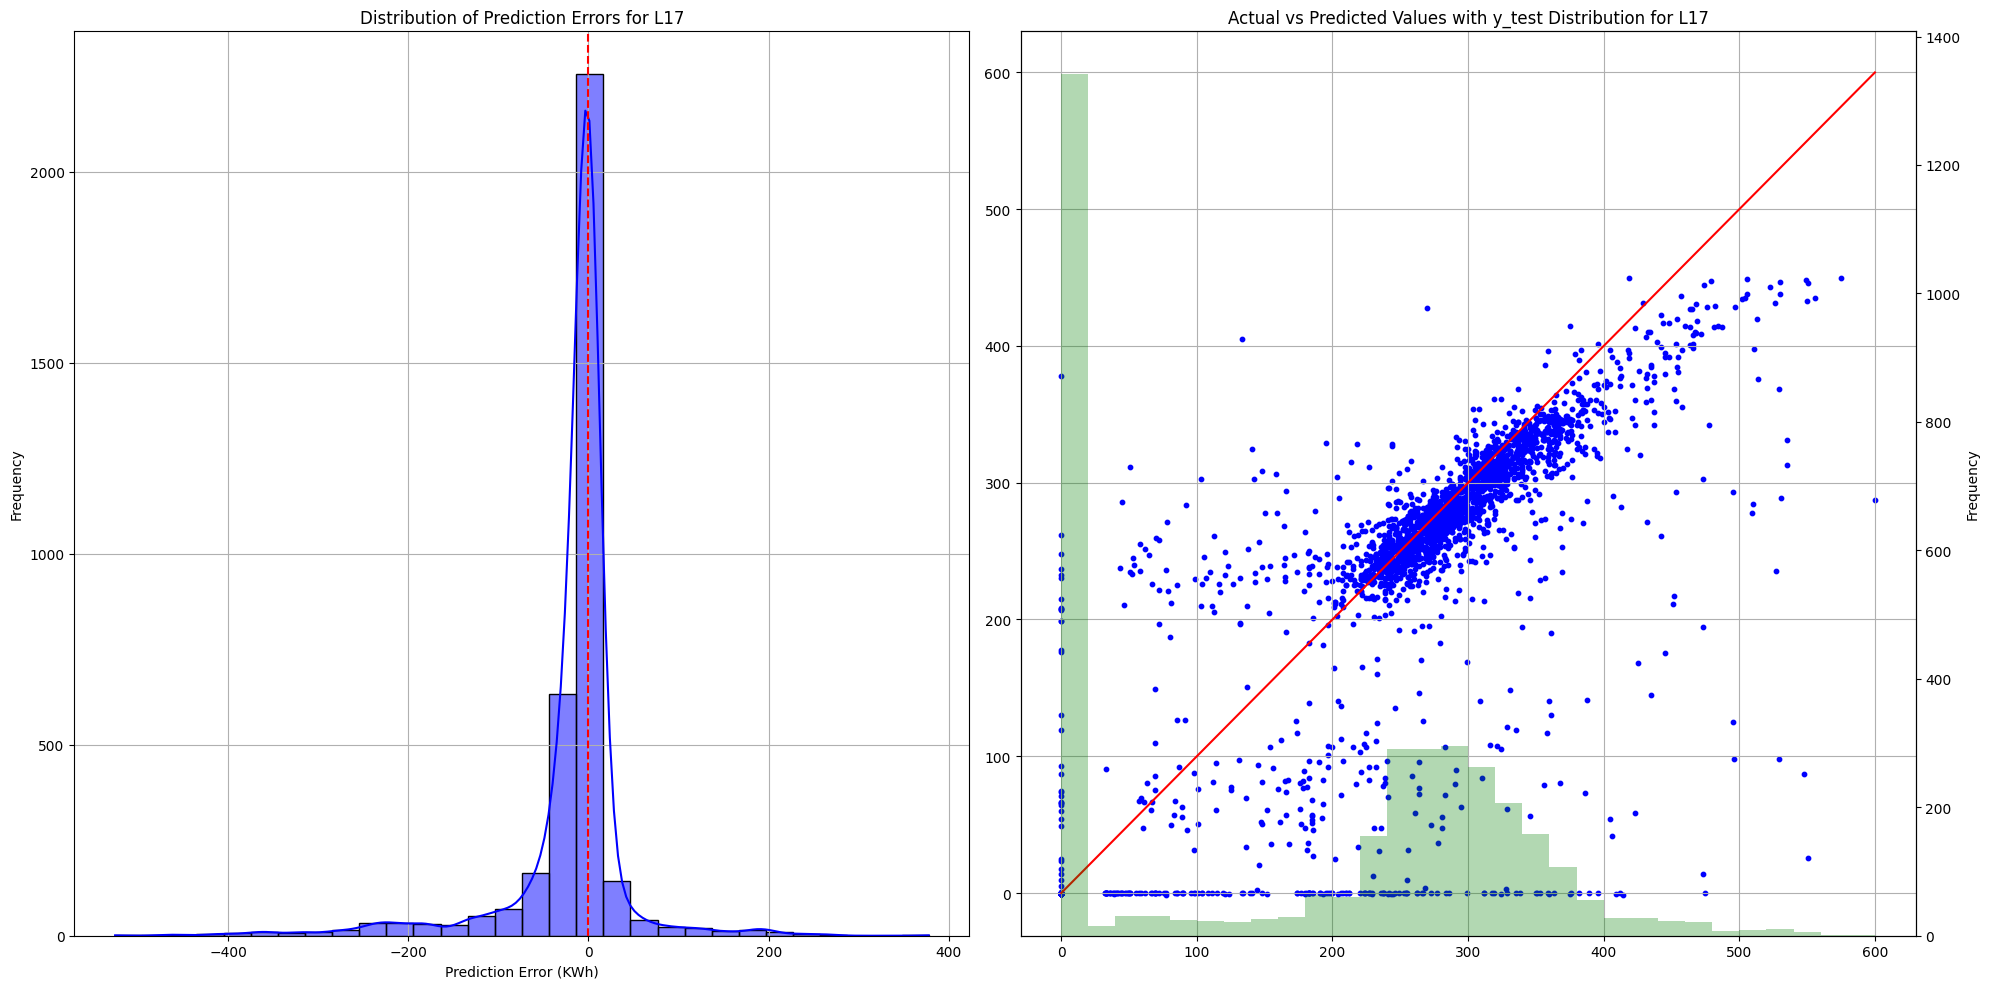

L22
-----------------------------------
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1533 - val_loss: 0.1042
Epoch 2/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1042 - val_loss: 0.0878
Epoch 3/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0901 - val_loss: 0.0742
Epoch 4/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0802 - val_loss: 0.0616
Epoch 5/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0706 - val_loss: 0.0546
Epoch 6/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0671 - val_loss: 0.0584
Epoch 7/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0633 - val_loss: 0.0545
Epoch 8/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0601 - val_loss: 0.0469
Epoch 9/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0591 - val_loss: 0.0460
Epoch 10/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0552 - val_loss: 0.0491
Epoch 11/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0537 - val_loss: 0.0491
Epoch 12/50
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss

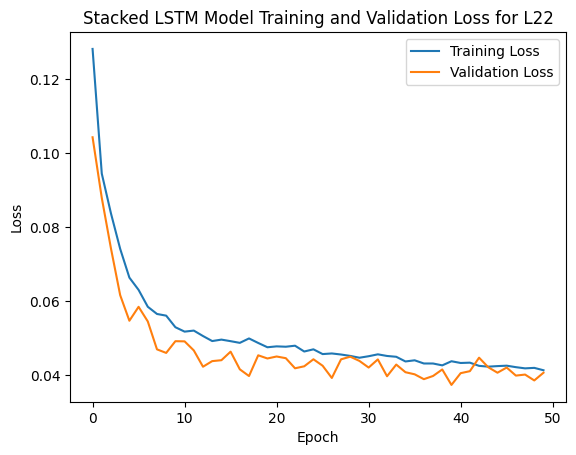

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
The LSTM inference took 0.5744879245758057 seconds to execute
GB Accuracy: 0.95
Root Mean Squared Error (RMSE): 35.62355054617135
Mean Absolute Error (MAE): 17.755393981933594
Mean Absolute Scaled Error (MASE): 0.5993032354857787
Symmetric Mean Absolute Percentage Error (sMAPE): 21.309994161128998
R² Score: 0.7807843685150146


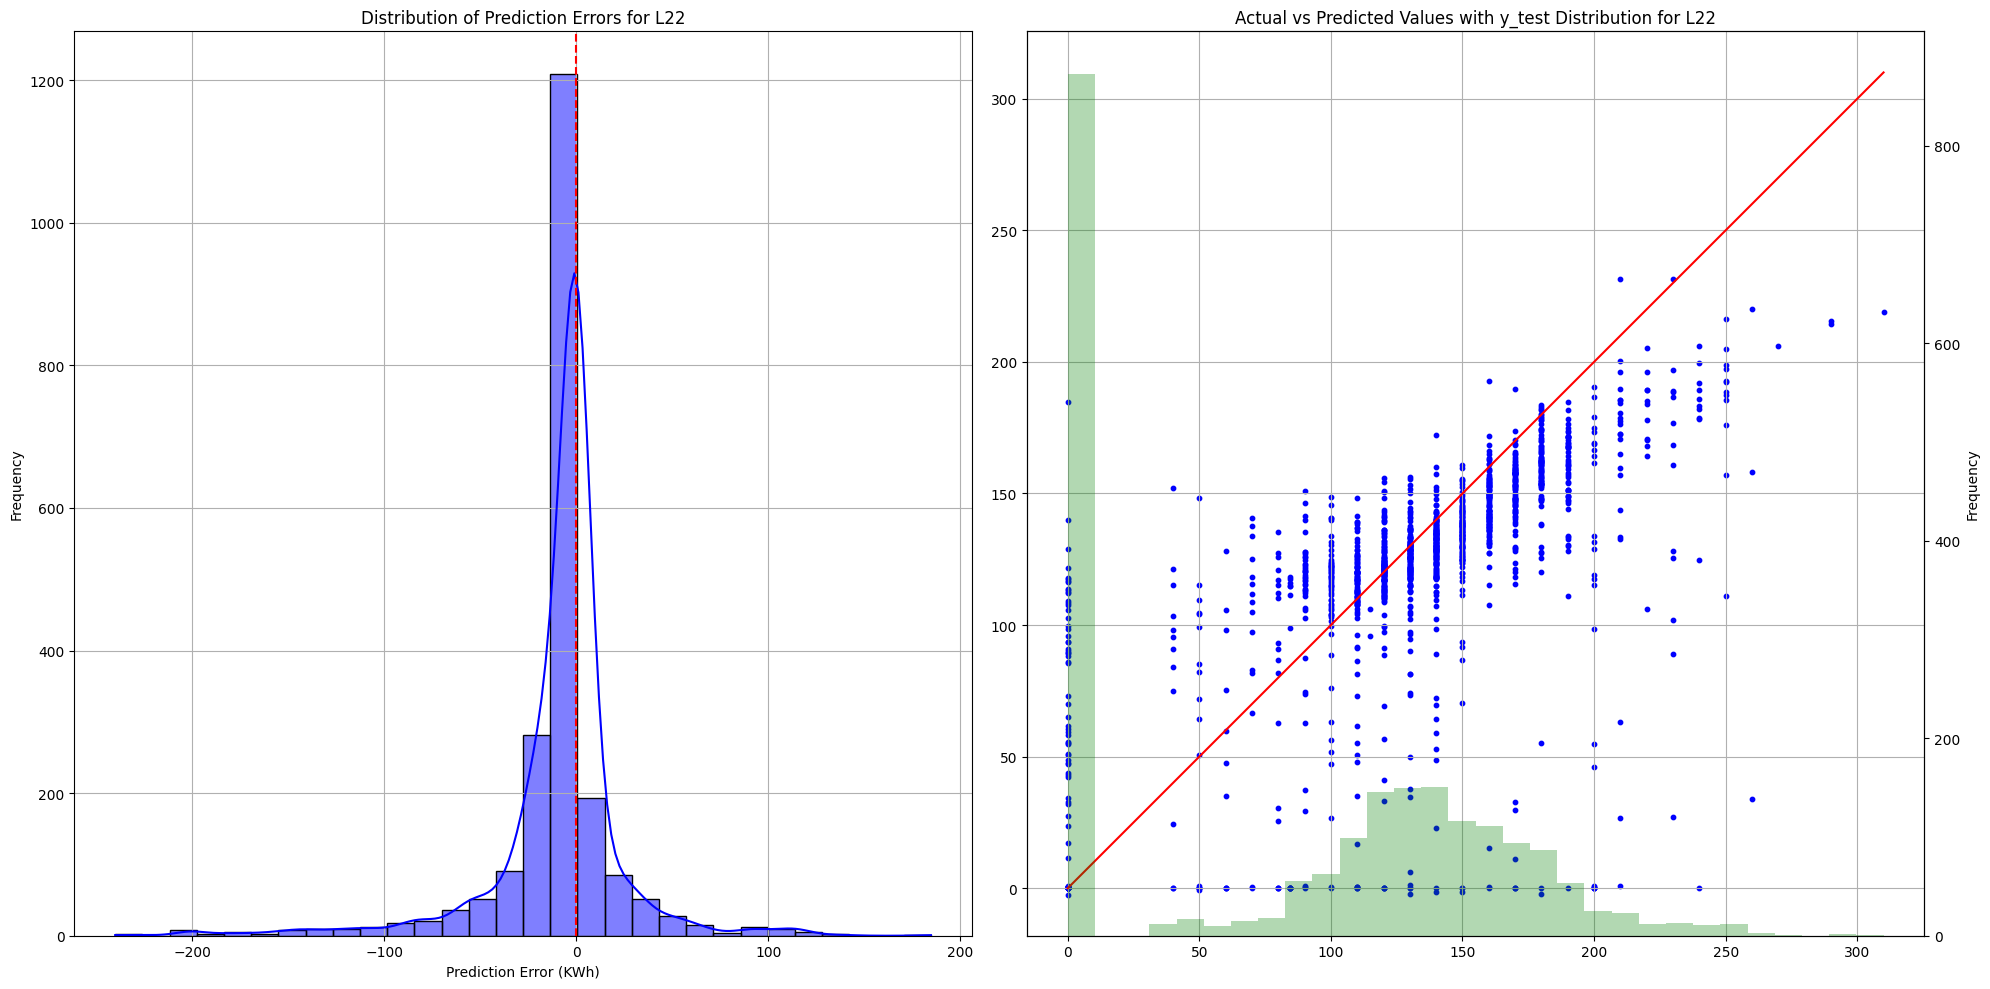

CPU times: user 17min 23s, sys: 42.6 s, total: 18min 6s
Wall time: 19min 32s


In [ ]:
%%time

a_lstm_mae=[]
a_lstm_mse=[]
a_lstm_mase=[]
a_lstm_smape=[]
a_lstm_r2=[]
a_lstm_execution_time=[]
a_lstm_inference_time=[]

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def getLSTMModel(ttrain_X):
  model = Sequential()
  model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(ttrain_X.shape[1], ttrain_X.shape[2])))
  model.add(Dropout(0.4))
  model.add(LSTM(100, activation='tanh'))
  model.add(Dropout(0.4))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
  return model

def plotHistory(history, ss):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Stacked LSTM Model Training and Validation Loss for {ss}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

def getPerformance(model, ttest_X, n_hours, n_features, scaler, test_y):
  yhat = model.predict(ttest_X)
  tttest_X = ttest_X.reshape((ttest_X.shape[0], n_hours*n_features))
  inv_yhat = np.concatenate((tttest_X, yhat), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  ttest_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((tttest_X, ttest_y), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_yhat = inv_yhat[:,n_hours*n_features]
  inv_y = inv_y[:,n_hours*n_features]
  return inv_y, inv_yhat

n_hours=24
histories=[]

for i, df in enumerate(all_data):
  print(substations[i])
  print('-----------------------------------')
  n_features=df.shape[1]
  reframed = series_to_supervised(df.values, n_hours, 1, dropnan=True)
  for f in range(1,n_features):
    reframed = reframed.drop(columns=['var'+str(f)+'(t)'])
  train_size=int(0.8*len(reframed))

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(reframed.values.astype('float32'))

  n_obs = scaled.shape[1]
  train = scaled[:train_size, :]
  test = scaled[train_size:, :]
  train_X, train_y = train[:, :n_obs-1], train[:, n_obs-1]
  test_X, test_y = test[:, :n_obs-1], test[:, n_obs-1]

  ttrain_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
  ttest_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

  model=getLSTMModel(ttrain_X)
  start_time = time.time()
  history = model.fit(ttrain_X, train_y, epochs=50, batch_size=24, validation_split=0.2, verbose=1, shuffle=False)
  histories.append(history)
  end_time = time.time()
  lstm_execution_time = end_time - start_time
  print(f"The LSTM training took {lstm_execution_time} seconds to execute")
  a_lstm_execution_time.append(lstm_execution_time)

  plotHistory(history, substations[i])

  start_time = time.time()
  inv_y, inv_yhat = getPerformance(model, ttest_X, n_hours, n_features, scaler, test_y)
  end_time = time.time()
  lstm_inference_time=end_time-start_time
  print(f"The LSTM inference took {lstm_inference_time} seconds to execute")

  # Gradient boosting classification model trained and tested on accuracy
  train_yc = np.where(train_y > 0, 1, 0)
  test_yc = np.where(test_y > 0, 1, 0)

  gbc=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
  gbc.fit(train_X, train_yc)
  y_pred_c = gbc.predict(test_X)
  accuracy = accuracy_score(test_yc, y_pred_c)
  print(f"GB Accuracy: {accuracy:.2f}")

  inv_yhat = np.where(y_pred_c == 0, 0, inv_yhat)

  lstm_rmse = mean_squared_error(inv_y, inv_yhat)
  lstm_rmse = np.sqrt(lstm_rmse)
  lstm_mae = mean_absolute_error(inv_y, inv_yhat)
  lstm_smape=calculate_smape(inv_y, inv_yhat)
  lstm_r2 = r2_score(inv_y, inv_yhat)


  a_lstm_inference_time.append(lstm_inference_time)
  a_lstm_mse.append(lstm_rmse)
  a_lstm_mae.append(lstm_mae)
  a_lstm_r2.append(lstm_r2)
  a_lstm_smape.append(lstm_smape)

  naive_forecast = inv_y[:-1]
  actual_for_naive = inv_y[1:]

  lstm_mase=lstm_mae/(np.mean(np.abs(actual_for_naive - naive_forecast)))
  a_lstm_mase.append(lstm_mase)

  print("Root Mean Squared Error (RMSE):", lstm_rmse)
  print("Mean Absolute Error (MAE):", lstm_mae)
  print("Mean Absolute Scaled Error (MASE):", lstm_mase)
  print("Symmetric Mean Absolute Percentage Error (sMAPE):", lstm_smape)
  print("R² Score:", lstm_r2)

  lstm_errors = inv_yhat - inv_y
  plt.figure(figsize=(20, 10))

  plt.subplot(1, 2, 1)
  sns.histplot(lstm_errors, kde=True, bins=30, color='blue')
  plt.xlabel('Prediction Error (KWh)')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Prediction Errors for {substations[i]}')
  plt.axvline(x=0, color='red', linestyle='--')
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.scatter(inv_y, inv_yhat, color='blue', label='Predicted vs Actual', s=10)
  plt.plot([min(inv_y), max(inv_y)], [min(inv_y), max(inv_y)], color='red', label='Ideal Line')
  plt.grid(True)
  ax2 = plt.twinx()
  ax2.hist(inv_y, bins=30, alpha=0.3, color='green', orientation='vertical')
  plt.xlabel('Actual Values (y_test) (KWh)')
  ax2.set_ylabel('Frequency')
  plt.title(f'Actual vs Predicted Values with y_test Distribution for {substations[i]}')

  plt.tight_layout()
  plt.show()

# Results and discussion

As it was introduced before, the objective of the research behind this paper was to demonstrate the performance of traditional ML vs Deep Learning models, by also considering the context of energy consumption involved in model training and inference. In order to better explain this context, we introduce the following assumptions.

The complete experiment was conducted on the Google Colab platform, utilizing freely available T4 GPU resources. The energy consumption for training a neural network on a T4 GPU is influenced by various factors, including the complexity of the network architecture, the size of the training dataset, batch size, choice of optimizer, and learning rate. According to the manufacturer's technical specifications (https://www.nvidia.com/en-eu/data-center/tesla-t4/), the NVidia T4 GPU has a power usage of 70 watts, equivalent to an energy consumption of 0.07 kWh. This measurement is associated to low-power scenarios, such as small, simple networks with small datasets and low batch sizes, as exemplified in the single-step forecasting of heat demand.

The average CO2 emission factor for thermal power plants is 0.998 kg/kWh (Chowdhury et al., 2004), though actual emissions can vary based on the specific fuel mix and efficiency of the power plants. Assuming the energy is generated by thermal plants, the CO2 emission per unit time of ML training is 0.0699 kg/h. This calculation involves several simplifications, the most significant being: 1) a constant GPU energy consumption, 2) the assumption that GPU and CPU have the same energy consumption, with the latter used for training the XGBoost model, and 3) the constant availability of resources, which renders comparisons based on training and inference times questionable. Nonetheless, for the purpose of this study, the results interpreted under these assumptions offer a sufficiently accurate indication of the substantial advantages that can be achieved by appropriately selecting methods to address time series forecasting problems.

The summary results are presented in the table below. Light GBM and XGBoost models outperform or are competitive to stacked LSTM model in all metrics. At all substations, in all metrics, Light GBM based approach shows the best results. Approach implemented by using XGBoost is a runner up in all cases except for MAE and MASE for L4, L17 and L22 where LSTM performs better.

In all cases, RMSE is almost double the MAE. RMSE gives more weight to larger errors due to the squaring of each error before averaging, while MAE treats all errors equally. RMSE being significantly higher than MAE suggests wider spread of errors or the presence of some large errors in predictions. In general, the model shows good accuracy, but it makes a few substantial errors. In our case, error distribution plots illustrates that LSTM driven method produces more extreme predictions compared to the others, namely it tends to confuse more the periods of working (predicted values at ypred=0) and non-working DHS. For this reason, in L8 and L12, LSTM approach shows better results than XGBoost in MAE, but worse in RMSE.

MASE values indicate that trained models are clearly superior to Naive model, which is somewhat expected due to high variance of the transmitted energy during one daily cycle. MASE is the only scaled metrics, meaning that the accuracy can be compared across substations. When looking at the best performing method, namely Light GBM, there are no notable differences between MASE values across substations. The best achieved MASE accuracy is MASE=0.468 for L8. Given the circumstance of having much more data for L4 and L17 (5 heating seasons) than for the others (3 heating seasons), we conclude that increasing the size of the dataset will not lead to improved results and that 3 seasons of data is sufficient for the succesful forecasting method. This is expected, given the absence of longer seasonalities in the data or some complex patterns that needs consideration in longer lookback periods.

As for the energy consumption, training times of LSTM are considerably longer than for the other methods. Light GBM was proven as a very efficient method, producing the shortest training times. LSTM training times for a given computational infrastructure are in approximate ranges of 2-4 minutes. The training may be misunderstood as one time effort, which actually is not the case; in our scenarios of intelligent control of DHS, training is done every hour by considering new data. The substantial difference in energy consumption between traditional ML and LSTM models is even more notable when considering that training of Light GBM and XGBoost did not consume GPU resources. That difference would be much greater if both approaches were using only CPU.

Finally, the analysis of the feature importances produces appropriate and relevant conclusions as they directly corresponds to the expected behavior of DHS system. Some key remarks regarding gain, cover and frequency aspects of the feature importances are following.

Gain score is significantly larger for deltae-23 (transmitted energy at the same hour in previous day) and heating_on (binary feature indicating whether the plan is turned on or off) features in L4, L8 and L12 data, than for the other features. For L17 and L22, deltae-23 is the top scored feature by far, without a convincing runner up. Similarly, Light GBM driven models show highest scores for deltae-23 feature. That is expected due to highly cyclic nature of DHS operations.

The coverage analysis is inconclusive as there is no strong commonality across different models and datasets.

XGBoost algorithm assigns the top frequency score to t_amb (ambient temperature measured at the level of substation) feature, largest by far. That is expected as t_amb is directly used by the control curve to manage the delivery of the heat energy at the level of substation. In contrast, Light GBM highlights a number of features per dataset as relevant in context of decision making (tree split) impact. For each of L4, L8, L12 and L17 substations, three features stand out: t_sup_sec (temperature of heating fluid in supply line of secondary flow), t_ret_sec (temperature of heating fluid in return line of secondary flow) and hour_of_day. This is somewhat similar to explanations on XGBoost decision making strength as t_sup_sec is inferred by the control curve, based on t_amb and (t_sup_sec - t_ret_sec) difference is directly proportional to the transmitted heat energy.

In [ ]:
cr = 0.0699  # in kg/h
faktor = cr * 1000 / 3600  # in gr/sec

# Create a multi-index for columns
columns = pd.MultiIndex.from_product([['L4', 'L8', 'L12', 'L17', 'L22'], ['LSTM', 'XGB', 'Extra Trees', 'Light GBM']])

# Initialize an empty DataFrame
dfr = pd.DataFrame(columns=columns, index=['RMSE (KWh)', 'MAE (KWh)',
                                           'MASE', 'sMAPE',
                                           'R2', 'Training time (in sec)', 'Inference time (in sec)', 'Training CO2 (in gr)', 'Inference CO2 (per 1000, in gr)'])

# Populate the DataFrame
for i, v in enumerate(substations):
    dfr[(v, 'LSTM')] = [
        a_lstm_mse[i],
        a_lstm_mae[i],
        a_lstm_mase[i],
        a_lstm_smape[i],
        a_lstm_r2[i],
        a_lstm_execution_time[i],
        a_lstm_inference_time[i],
        a_lstm_execution_time[i] * faktor,
        a_lstm_inference_time[i] * faktor * 1000
    ]
    dfr[(v, 'XGB')] = [
        a_xgb_mse[i],
        a_xgb_mae[i],
        a_xgb_mase[i],
        a_xgb_smape[i],
        a_xgb_r2[i],
        a_xgb_execution_time[i],
        a_xgb_inference_time[i],
        a_xgb_execution_time[i] * faktor,
        a_xgb_inference_time[i] * faktor * 1000
    ]
    dfr[(v, 'Extra Trees')] = [
        a_xtr_mse[i],
        a_xtr_mae[i],
        a_xtr_mase[i],
        a_xtr_smape[i],
        a_xtr_r2[i],
        a_xtr_execution_time[i],
        a_xtr_inference_time[i],
        a_xtr_execution_time[i] * faktor,
        a_xtr_inference_time[i] * faktor * 1000
    ]
    dfr[(v, 'Light GBM')] = [
        a_lgb_mse[i],
        a_lgb_mae[i],
        a_lgb_mase[i],
        a_lgb_smape[i],
        a_lgb_r2[i],
        a_lgb_execution_time[i],
        a_lgb_inference_time[i],
        a_lgb_execution_time[i] * faktor,
        a_lgb_inference_time[i] * faktor * 1000
    ]



# Convert DataFrame to HTML and display
html_table = dfr.to_html(notebook=True)
display(HTML(html_table))
dfr.to_csv('results.csv')

In [ ]:
# Apply styling
styled_df = dfr.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [('background-color', '#D3D3D3'),  # Gray background in header
                  ('color', 'black'),
                  ('border', '2px solid black'),
                  ('padding', '4px')]
    },
    {
        'selector': 'td',
        'props': [('background-color', 'white'),    # White background in cells
                  ('color', 'black'),
                  ('border', '2px solid black'),
                  ('padding', '4px')]
    },
    {
        'selector': 'table',
        'props': [('border-collapse', 'collapse')]  # Ensures the borders collapse into a single border
    }]
)

styled_df

#Conclusions and future work

In this paper, we demonstrated that traditional ML models are better or competitive alternatives to modern DL approaches in the domain of heat demand forecasting, from accuracy, computation cost and explainability points of view. It is shown that the efficient tree-based ensemble algorithms clearly exceed the performance of stacked LSTM Deep Learning architecture.

To further build on this proven hypothesis in the future, we plan to explore the strength of combining different ML models, in particular in the aspects of dynamically weighted combinations and using cross-learning to build unified model with high performance for all substations in one DHS.

When dealing with time series data that has a high degree of intermittency, a few specialized methods and metrics can be particularly effective, even more than the use of combined model. They are all based on separation of concerns related to forecasting zero and non-zero values. For example, the most commonly used (with many of its variants) Croston's method (Croston, 1972) for forecasting intermittent demand in inventory systems separately forecasts the non-zero demand levels and the intervals between non-zero demands. Another method is Zero-Inflated Poisson Regression (Lambert, 1992), used when the count data have an excess of zeros.

Combining different time series forecasting has been clearly proven as the best practice (Makridakis et al, 2022). While equally-weighted combinations have been adopted as good-enough solution, we aim to further extend this concept by introducing dynamic, learned weights. The concept involves: 1) optimal selection of models trained on the same dataset, with different algorithms and/or different sets of hyperparameters, 2) prediction on the validation subset of data constituting the new dataset consisting of predictions of all models and true value of heat demand, 3) training a linear regression model that fits the predictions of the different models to the true values, and 4) using learnt coefficients as weights for combining the predictions of the selection of models at the test subset.

Finally, we will explore the feasibility of using cross-learning approach to training the unified model on the different normalized datasets, corresponding to the individual substations in the DHS.

#References

Makridakis, S., A. Andersen, R. Carbone, R. Fildes, M. Hibon, R. Lewandowski, J. Newton, E. Parzen, and R. Winkler. 1982. “The Accuracy of Extrapolation (Time Series) Methods: Results of a Forecasting Competition.” Journal of Forecasting 1(2):111-53. doi: 10.1002/for.3980010202.

Semenoglou, Artemios-Anargyros, Evangelos Spiliotis, Spyros Makridakis, and Vassilios Assimakopoulos. 2021. “Investigating the Accuracy of Cross-Learning Time Series Forecasting Methods.” International Journal of Forecasting 37(3):1072-84. doi: 10.1016/j.ijforecast.2020.11.009.

Makridakis, Spyros, Evangelos Spiliotis, and Vassilios Assimakopoulos. 2022. “M5 Accuracy Competition: Results, Findings, and Conclusions.” International Journal of Forecasting 38(4):1346-64. doi: 10.1016/j.ijforecast.2021.11.013.

Ke, Guolin, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. 2017. “LightGBM: A Highly Efficient Gradient Boosting Decision Tree.” Pp. 3149-57 in Proceedings of the 31st International Conference on Neural Information Processing Systems, NIPS'17. Red Hook, NY, USA: Curran Associates Inc.

Hyndman, Rob J., and Anne B. Koehler. 2006. “Another Look at Measures of Forecast Accuracy.” International Journal of Forecasting 22(4):679-88. doi: 10.1016/j.ijforecast.2006.03.001.

Croston, J. D. 1972. “Forecasting and Stock Control for Intermittent Demands.” Operational Research Quarterly (1970-1977) 23(3):289. doi: 10.2307/3007885.

Lambert, Diane. 1992. “Zero-Inflated Poisson Regression, with an Application to Defects in Manufacturing.” Technometrics 34(1):1. doi: 10.2307/1269547.

Chen, T., Guestrin, C. (2016) XGBoost: A Scalable Tree Boosting System. KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. Pages 785-794. https://doi.org/10.1145/2939672.2939785

Hochreiter, S., Schmidhuber, J. (1997) Long Short-Term Memory. Neural Computation 9, 1735-1780

Chen, T., Guestrin, C. (2016) XGBoost: A Scalable Tree Boosting System. KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. Pages 785-794. https://doi.org/10.1145/2939672.2939785

Ke, Guolin, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. 2017. “LightGBM: A Highly Efficient Gradient Boosting Decision Tree.” Pp. 3149-57 in Proceedings of the 31st International Conference on Neural Information Processing Systems, NIPS'17. Red Hook, NY, USA: Curran Associates Inc.

Oreshkin, Boris N., Dmitri Carpov, Nicolas Chapados, and Yoshua Bengio. 2019. “N-BEATS: Neural Basis Expansion Analysis for Interpretable Time Series Forecasting.”

Salinas, David, Valentin Flunkert, Jan Gasthaus, and Tim Januschowski. 2020. “DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks.” International Journal of Forecasting 36(3):1181–91. doi: 10.1016/j.ijforecast.2019.07.001.

Petropoulos, Fotios, and Ivan Svetunkov. 2020. “A Simple Combination of Univariate Models.” International Journal of Forecasting 36(1):110–15. doi: 10.1016/j.ijforecast.2019.01.006.

Chowdhury, S., Chakraborty, S., Bhattacharya, S., Garg, A., Mitra, A.P., Mukherjee, I., Chakraborty, N. (2004) An emission estimation of greenhouse gas emission from thermal power plants in India during 2002-03. In Proceedings, Workshop on Uncertainty Reduction in Greenhouse Gas Inventories. Ed.; A.P. Mitra, Subodh K. Sharma, S. Bhattachrya & A. Garg, Published by Ministry of Environment and Forests, Government of India, New Delhi, 2004; pp. 16-22.

Runge, Jason, and Etienne Saloux. 2023. “A Comparison of Prediction and Forecasting Artificial Intelligence Models to Estimate the Future Energy Demand in a District Heating System.” Energy 269:126661. doi: 10.1016/j.energy.2023.126661.

Zdravković, Milan, Ivan Ćirić, and Marko Ignjatović. 2022. “Explainable Heat Demand Forecasting for the Novel Control Strategies of District Heating Systems.” Annual Reviews in Control 53:405–13. doi: 10.1016/j.arcontrol.2022.03.009.

Xue, Puning, Yi Jiang, Zhigang Zhou, Xin Chen, Xiumu Fang, and Jing Liu. 2019. “Multi-Step Ahead Forecasting of Heat Load in District Heating Systems Using Machine Learning Algorithms.” Energy 188:116085. doi: 10.1016/j.energy.2019.116085.

Gong, Mingju, Yin Zhao, Jiawang Sun, Cuitian Han, Guannan Sun, and Bo Yan. 2022. “Load Forecasting of District Heating System Based on Informer.” Energy 253:124179. doi: 10.1016/j.energy.2022.124179.

Kurek, Teresa, Artur Bielecki, Konrad Świrski, Konrad Wojdan, Michał Guzek, Jakub Białek, Rafał Brzozowski, and Rafał Serafin. 2021. “Heat Demand Forecasting Algorithm for a Warsaw District Heating Network.” Energy 217:119347. doi: 10.1016/j.energy.2020.119347.

Song, Jiancai, Liyi Zhang, Guixiang Xue, YunPeng Ma, Shan Gao, and QingLing Jiang. 2021. “Predicting Hourly Heating Load in a District Heating System Based on a Hybrid CNN-LSTM Model.” Energy and Buildings 243:110998. doi: 10.1016/j.enbuild.2021.110998.

Chung, Won Hee, Yeong Hyeon Gu, and Seong Joon Yoo. 2021. “District Heater Load Forecasting Based on Machine Learning and Parallel CNN-LSTM Attention.” SSRN Electronic Journal. doi: 10.2139/ssrn.3914854.

Yao, Fulong, Wenju Zhou, Mostafa Al Ghamdi, Yang Song, and Wanqing Zhao. 2022. “An Integrated D-CNN-LSTM Approach for Short-Term Heat Demand Prediction in District Heating Systems.” Energy Reports 8:98–107. doi: 10.1016/j.egyr.2022.08.087.

Zhang, Ji, Yuxin Hu, Yonggong Yuan, Han Yuan, and Ning Mei. 2024. “Accuracy Improvement of the Load Forecasting in the District Heating System by the Informer-Based Framework with the Optimal Step Size Selection.” Energy 291:130347. doi: 10.1016/j.energy.2024.130347.

Bünning, Felix, Philipp Heer, Roy S. Smith, and John Lygeros. 2020. “Improved Day Ahead Heating Demand Forecasting by Online Correction Methods.” Energy and Buildings 211:109821. doi: 10.1016/j.enbuild.2020.109821.

Cui, Mianshan. 2022. “District Heating Load Prediction Algorithm Based on Bidirectional Long Short-Term Memory Network Model.” Energy 254:124283. doi: 10.1016/j.energy.2022.124283.

Wei, Ziqing, Tingwei Zhang, Bao Yue, Yunxiao Ding, Ran Xiao, Ruzhu Wang, and Xiaoqiang Zhai. 2021. “Prediction of Residential District Heating Load Based on Machine Learning: A Case Study.” Energy 231:120950. doi: 10.1016/j.energy.2021.120950.

Huang, Yaohui, Yuan Zhao, Zhijin Wang, Xiufeng Liu, Hanjing Liu, and Yonggang Fu. 2023. “Explainable District Heat Load Forecasting with Active Deep Learning.” Applied Energy 350:121753. doi: 10.1016/j.apenergy.2023.121753.

Gong, Mingju, Yin Bai, Juan Qin, Jin Wang, Peng Yang, and Sheng Wang. 2020. “Gradient Boosting Machine for Predicting Return Temperature of District Heating System: A Case Study for Residential Buildings in Tianjin.” Journal of Building Engineering 27:100950. doi: 10.1016/j.jobe.2019.100950.

Wang, Zhijin, Xiufeng Liu, Yaohui Huang, Peisong Zhang, and Yonggang Fu. 2023. “A Multivariate Time Series Graph Neural Network for District Heat Load Forecasting.” Energy 278:127911. doi: 10.1016/j.energy.2023.127911.

Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. Machine Learning, 63(1), 3–42. https://doi.org/10.1007/s10994-006-6226-1







